In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import torch # not used

[WARN] no Optuna JSON found for 'AAPL' in 'optuna_results', using defaults
[WARN] no Optuna JSON found for 'AAPL' in 'optuna_results', using defaults


In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


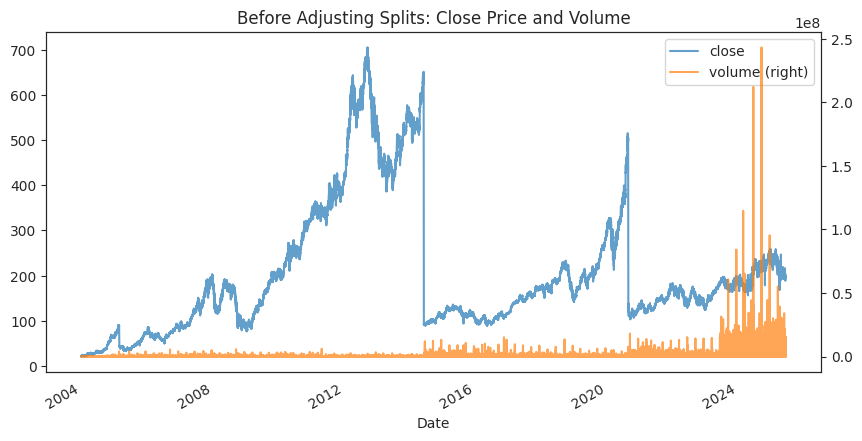

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


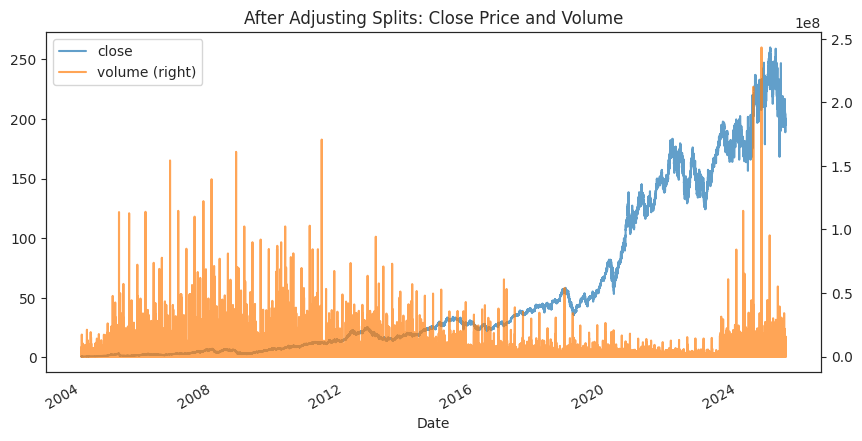

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penal_decay,
    trailing_stop_pct,
    buy_threshold,
    top_percentile,
    smoothing_window
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',

        # — Trade-ID parameters —
        min_prof_thr             = min_prof_thr,            # profit % threshold (profit_pc ≥ min_prof_thr),  
                                                             # e.g. 0.5 → require at least 0.5% gain  
        max_down_prop            = max_down_prop,           # max retracement **fraction** of that profit range before exit,  
                                                             # e.g. 0.2 → allow up to 20% retracement of your gain  
        gain_tightening_factor   = gain_tightening_factor,  # dimensionless factor that tightens max_down_prop per %-gain,  
                                                             # applied as base/(1 + factor×gain%)  
        merging_retracement_thr  = merging_retracement_thr, # intermediate retracement **ratio** to merge two trades,  
                                                             # e.g. 0.3 → allow up to a 30% pullback of trade1’s range  
        merging_time_gap_thr     = merging_time_gap_thr,    # time-gap **ratio** to merge two trades,  
                                                             # gap_sec/(duration1+duration2), dimensionless  
    
        # — Continuous-signal parameters —
        pre_entry_decay          = pre_entry_decay,         # per-minute decay rate on pre-entry signal (0–1),  
                                                             # lower≈0.01→slow fade, higher≈0.1→fast fade  
        short_penal_decay        = short_penal_decay,       # exponent penalty on short-trade durations,  
                                                             # >1 amplifies suppression of very short signals  
    
        # — Final-trigger parameters —
        trailing_stop_pct        = trailing_stop_pct,       # trailing-stop distance **percent**,  
                                                             # internally divided by 100,  
                                                             # e.g. 0.5 → 0.5% stop loss  
        buy_threshold            = buy_threshold,           # normalized signal threshold ∈[0,1] to enter trade,  
                                                             # e.g. 0.5 → require 50% signal  
        top_percentile           = top_percentile,           # percentile **percent** to cap signal at 1.0,  
                                                             # e.g. 1.0 → top 1% of raw signals become 1.0  
        smoothing_window         = smoothing_window
    )


    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.1), # increasing min, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.6),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 2, 9),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 0.7),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 1, 5),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.01, 0.1), # decreasing max, to avoid too fast trading
        "short_penal_decay"       : trial.suggest_float("short_penal_decay", 2, 9),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.3), # increasing min, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.2, 0.6),
        "top_percentile"          : trial.suggest_float("top_percentile", 1, 7),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [45])
    }

    print('----------------------------------------------------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-09-04 16:41:04,074] A new study created in RDB with name: no-name-e2f436f1-8d6c-458a-a68f-d39558d01954


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:01<00:00, 29.67day/s]
[I 2025-09-04 16:44:27,852] Trial 0 finished with value: 0.24077425925925927 and parameters: {'min_prof_thr': 0.09830053425678834, 'max_down_prop': 0.41758280930117087, 'gain_tightening_factor': 2.266059948331962, 'merging_retracement_thr': 0.19195471602149777, 'merging_time_gap_thr': 3.516781612234968, 'pre_entry_decay': 0.07374608958156013, 'short_penal_decay': 8.780953245540411, 'trailing_stop_pct': 0.24994317251923265, 'buy_threshold': 0.34089369929169877, 'top_percentile': 5.838362486317688, 'smoothing_window': 45}. Best is trial 0 with value: 0.24077425925925927.


→ Total return across 5400 trading days: $1300.18
→ Avg daily return (all days)          : $0.2408
→ Total trades                          : 14073
→ Avg return per trade                  : $0.0924



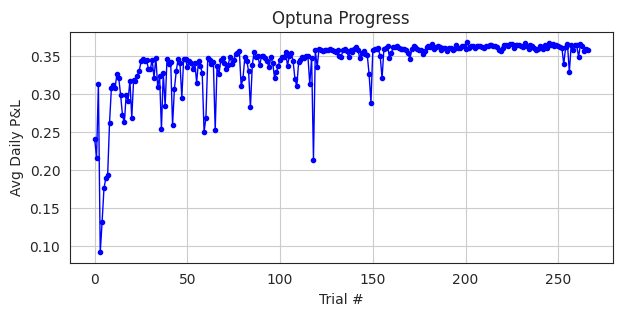

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:03<00:00, 29.35day/s]
[I 2025-09-04 16:47:51,110] Trial 1 finished with value: 0.21670055555555556 and parameters: {'min_prof_thr': 0.07390502337737961, 'max_down_prop': 0.26034813918803135, 'gain_tightening_factor': 3.95595405040537, 'merging_retracement_thr': 0.16041407952894954, 'merging_time_gap_thr': 2.94436168803063, 'pre_entry_decay': 0.04428974129714283, 'short_penal_decay': 2.351894150882886, 'trailing_stop_pct': 0.08370153205390195, 'buy_threshold': 0.5771790350273494, 'top_percentile': 1.6622491246410067, 'smoothing_window': 45}. Best is trial 0 with value: 0.24077425925925927.


→ Total return across 5400 trading days: $1170.18
→ Avg daily return (all days)          : $0.2167
→ Total trades                          : 4938
→ Avg return per trade                  : $0.2370

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:53<00:00, 31.07day/s]
[I 2025-09-04 16:51:12,117] Trial 2 finished with value: 0.31341777777777774 and parameters: {'min_prof_thr': 0.032500422872746175, 'max_down_prop': 0.15737840632897473, 'gain_tightening_factor': 3.0424332859966423, 'merging_retracement_thr': 0.24483208839849976, 'merging_time_gap_thr': 2.5589185528609035, 'pre_entry_decay': 0.0189150048347424, 'short_penal_decay': 8.547650435897207, 'trailing_stop_pct': 0.26370343869395063, 'buy_threshold': 0.39969702628530235, 'top_percentile': 4.276195596865521, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $1692.46
→ Avg daily return (all days)          : $0.3134
→ Total trades                          : 7859
→ Avg return per trade                  : $0.2154

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:06<00:00, 28.98day/s]
[I 2025-09-04 16:54:39,129] Trial 3 finished with value: 0.09225648148148148 and parameters: {'min_prof_thr': 0.09768945864801161, 'max_down_prop': 0.46244374010866496, 'gain_tightening_factor': 4.510355407428664, 'merging_retracement_thr': 0.40189054238269095, 'merging_time_gap_thr': 4.872087439977395, 'pre_entry_decay': 0.09903234824184873, 'short_penal_decay': 6.209647142219561, 'trailing_stop_pct': 0.2351256857891644, 'buy_threshold': 0.3018798212805601, 'top_percentile': 4.922681826385084, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $498.19
→ Avg daily return (all days)          : $0.0923
→ Total trades                          : 15611
→ Avg return per trade                  : $0.0319

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:36<00:00, 24.95day/s]
[I 2025-09-04 16:58:47,878] Trial 4 finished with value: 0.13180666666666666 and parameters: {'min_prof_thr': 0.07954761145930749, 'max_down_prop': 0.20892648747184286, 'gain_tightening_factor': 4.314834865062011, 'merging_retracement_thr': 0.2334849234392182, 'merging_time_gap_thr': 1.2001666543609946, 'pre_entry_decay': 0.09718171761357107, 'short_penal_decay': 4.6482973810853565, 'trailing_stop_pct': 0.1798175337247178, 'buy_threshold': 0.2987194115852737, 'top_percentile': 6.527173015146894, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $711.76
→ Avg daily return (all days)          : $0.1318
→ Total trades                          : 16016
→ Avg return per trade                  : $0.0444

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:54<00:00, 22.98day/s]
[I 2025-09-04 17:03:38,680] Trial 5 finished with value: 0.17607222222222224 and parameters: {'min_prof_thr': 0.09921490893817976, 'max_down_prop': 0.12352582392827485, 'gain_tightening_factor': 4.676993393035821, 'merging_retracement_thr': 0.56832029235388, 'merging_time_gap_thr': 1.5700795647926546, 'pre_entry_decay': 0.03437922466956063, 'short_penal_decay': 7.0120575973263675, 'trailing_stop_pct': 0.22181369582159002, 'buy_threshold': 0.2529280591760832, 'top_percentile': 6.77711925619022, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $950.79
→ Avg daily return (all days)          : $0.1761
→ Total trades                          : 12732
→ Avg return per trade                  : $0.0747

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:09<00:00, 21.62day/s]
[I 2025-09-04 17:08:32,248] Trial 6 finished with value: 0.18970648148148148 and parameters: {'min_prof_thr': 0.08098230321508885, 'max_down_prop': 0.16470546894734941, 'gain_tightening_factor': 6.14641183032807, 'merging_retracement_thr': 0.4661632822930134, 'merging_time_gap_thr': 4.45296707822464, 'pre_entry_decay': 0.07228951993404975, 'short_penal_decay': 6.591254030387129, 'trailing_stop_pct': 0.29339370647289187, 'buy_threshold': 0.4331217118612828, 'top_percentile': 5.219542354116509, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $1024.41
→ Avg daily return (all days)          : $0.1897
→ Total trades                          : 12257
→ Avg return per trade                  : $0.0836

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:09<00:00, 28.55day/s]
[I 2025-09-04 17:12:18,736] Trial 7 finished with value: 0.19374166666666665 and parameters: {'min_prof_thr': 0.04543536965797271, 'max_down_prop': 0.5341483004042534, 'gain_tightening_factor': 5.225370710979209, 'merging_retracement_thr': 0.1696124819772114, 'merging_time_gap_thr': 2.122548694537613, 'pre_entry_decay': 0.07386882858902134, 'short_penal_decay': 6.476508468918614, 'trailing_stop_pct': 0.24918759822416428, 'buy_threshold': 0.21983930439698074, 'top_percentile': 2.562692598735329, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $1046.20
→ Avg daily return (all days)          : $0.1937
→ Total trades                          : 15104
→ Avg return per trade                  : $0.0693

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:00<00:00, 29.97day/s]
[I 2025-09-04 17:15:46,613] Trial 8 finished with value: 0.26194018518518514 and parameters: {'min_prof_thr': 0.017661551105161995, 'max_down_prop': 0.3940169227658321, 'gain_tightening_factor': 5.100836844605482, 'merging_retracement_thr': 0.1924724113953621, 'merging_time_gap_thr': 1.7597240533576355, 'pre_entry_decay': 0.08292852422178427, 'short_penal_decay': 4.200890655407887, 'trailing_stop_pct': 0.1284205507683256, 'buy_threshold': 0.5156911280277645, 'top_percentile': 2.5535896166251977, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $1414.48
→ Avg daily return (all days)          : $0.2619
→ Total trades                          : 8592
→ Avg return per trade                  : $0.1646

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:01<00:00, 22.35day/s]
[I 2025-09-04 17:20:09,995] Trial 9 finished with value: 0.3074787037037037 and parameters: {'min_prof_thr': 0.07963541796408037, 'max_down_prop': 0.21551368707003085, 'gain_tightening_factor': 8.999552023647626, 'merging_retracement_thr': 0.12279769554731941, 'merging_time_gap_thr': 2.430823153565709, 'pre_entry_decay': 0.02027743402063991, 'short_penal_decay': 6.133764445967572, 'trailing_stop_pct': 0.05060444058927893, 'buy_threshold': 0.514943919171474, 'top_percentile': 6.3557696223167515, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $1660.39
→ Avg daily return (all days)          : $0.3075
→ Total trades                          : 8384
→ Avg return per trade                  : $0.1980

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:44<00:00, 24.03day/s]
[I 2025-09-04 17:24:31,245] Trial 10 finished with value: 0.31220259259259264 and parameters: {'min_prof_thr': 0.026215982567862, 'max_down_prop': 0.3109353655482052, 'gain_tightening_factor': 2.192449979918705, 'merging_retracement_thr': 0.2921170599422402, 'merging_time_gap_thr': 3.809866598121568, 'pre_entry_decay': 0.011246077752779651, 'short_penal_decay': 7.496752074431836, 'trailing_stop_pct': 0.29543296167148964, 'buy_threshold': 0.4024648698942675, 'top_percentile': 3.963609286340179, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $1685.89
→ Avg daily return (all days)          : $0.3122
→ Total trades                          : 6650
→ Avg return per trade                  : $0.2535

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:35<00:00, 25.02day/s]
[I 2025-09-04 17:28:34,435] Trial 11 finished with value: 0.3084027777777778 and parameters: {'min_prof_thr': 0.028743346960863093, 'max_down_prop': 0.3013815251910293, 'gain_tightening_factor': 2.0829871724091142, 'merging_retracement_thr': 0.31647975659891303, 'merging_time_gap_thr': 3.7413939944430115, 'pre_entry_decay': 0.011377326705415983, 'short_penal_decay': 8.919299128465992, 'trailing_stop_pct': 0.29738904192946897, 'buy_threshold': 0.4065963381946952, 'top_percentile': 4.070161552435243, 'smoothing_window': 45}. Best is trial 2 with value: 0.31341777777777774.


→ Total return across 5400 trading days: $1665.38
→ Avg daily return (all days)          : $0.3084
→ Total trades                          : 6581
→ Avg return per trade                  : $0.2531

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:08<00:00, 28.65day/s]
[I 2025-09-04 17:32:21,632] Trial 12 finished with value: 0.32641944444444443 and parameters: {'min_prof_thr': 0.03774699385905176, 'max_down_prop': 0.10334067697466898, 'gain_tightening_factor': 3.102678350808891, 'merging_retracement_thr': 0.30998507824339855, 'merging_time_gap_thr': 3.0631503079940137, 'pre_entry_decay': 0.027098374124258383, 'short_penal_decay': 7.786473873244864, 'trailing_stop_pct': 0.19013154174858024, 'buy_threshold': 0.4589092804894477, 'top_percentile': 3.6718371143428756, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1762.66
→ Avg daily return (all days)          : $0.3264
→ Total trades                          : 7966
→ Avg return per trade                  : $0.2213

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:08<00:00, 28.64day/s]
[I 2025-09-04 17:35:51,624] Trial 13 finished with value: 0.3208898148148148 and parameters: {'min_prof_thr': 0.04429364939332668, 'max_down_prop': 0.10015988418709702, 'gain_tightening_factor': 2.994496086163513, 'merging_retracement_thr': 0.33819692318926253, 'merging_time_gap_thr': 2.8901382335644485, 'pre_entry_decay': 0.03295075720496584, 'short_penal_decay': 8.067973991434506, 'trailing_stop_pct': 0.17532052475370402, 'buy_threshold': 0.5056318852301028, 'top_percentile': 3.8626265095189147, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1732.81
→ Avg daily return (all days)          : $0.3209
→ Total trades                          : 7959
→ Avg return per trade                  : $0.2177

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:47<00:00, 23.75day/s]
[I 2025-09-04 17:40:05,417] Trial 14 finished with value: 0.29849555555555557 and parameters: {'min_prof_thr': 0.04927781130667766, 'max_down_prop': 0.12279432658625568, 'gain_tightening_factor': 6.1535492254851984, 'merging_retracement_thr': 0.6904814325730192, 'merging_time_gap_thr': 3.170636698415198, 'pre_entry_decay': 0.04145090353153069, 'short_penal_decay': 7.811651014110611, 'trailing_stop_pct': 0.1778423021294522, 'buy_threshold': 0.48331801234923316, 'top_percentile': 2.846526728873167, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1611.88
→ Avg daily return (all days)          : $0.2985
→ Total trades                          : 8408
→ Avg return per trade                  : $0.1917

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:25<00:00, 26.23day/s]
[I 2025-09-04 17:44:02,555] Trial 15 finished with value: 0.2721955555555556 and parameters: {'min_prof_thr': 0.06209105366724772, 'max_down_prop': 0.10965371853787156, 'gain_tightening_factor': 3.1529689620351777, 'merging_retracement_thr': 0.3660719123831282, 'merging_time_gap_thr': 2.932684797521745, 'pre_entry_decay': 0.05237564954302121, 'short_penal_decay': 5.150798100270261, 'trailing_stop_pct': 0.1362244427180693, 'buy_threshold': 0.5901542480685572, 'top_percentile': 3.352951375855814, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1469.86
→ Avg daily return (all days)          : $0.2722
→ Total trades                          : 7321
→ Avg return per trade                  : $0.2008

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:16<00:00, 27.54day/s]


→ Total return across 5400 trading days: $1419.01
→ Avg daily return (all days)          : $0.2628
→ Total trades                          : 5012
→ Avg return per trade                  : $0.2831



[I 2025-09-04 17:47:56,360] Trial 16 finished with value: 0.2627798148148148 and parameters: {'min_prof_thr': 0.010946044583772511, 'max_down_prop': 0.2197875634717682, 'gain_tightening_factor': 7.742724268017314, 'merging_retracement_thr': 0.4627990855921946, 'merging_time_gap_thr': 4.357915492721029, 'pre_entry_decay': 0.02925145500421555, 'short_penal_decay': 7.809571292099527, 'trailing_stop_pct': 0.19399581023543283, 'buy_threshold': 0.46540139933607955, 'top_percentile': 1.2772781158677846, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:18<00:00, 20.90day/s]
[I 2025-09-04 17:53:14,364] Trial 17 finished with value: 0.29930814814814816 and parameters: {'min_prof_thr': 0.04065101596339084, 'max_down_prop': 0.10190535549529445, 'gain_tightening_factor': 3.44022802362228, 'merging_retracement_thr': 0.42235763141064925, 'merging_time_gap_thr': 3.3840081873495618, 'pre_entry_decay': 0.02961717256650114, 'short_penal_decay': 3.8077664571311955, 'trailing_stop_pct': 0.1440922504162956, 'buy_threshold': 0.5419984547652628, 'top_percentile': 3.314156025387709, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1616.26
→ Avg daily return (all days)          : $0.2993
→ Total trades                          : 7304
→ Avg return per trade                  : $0.2213

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:31<00:00, 19.91day/s]
[I 2025-09-04 17:58:20,317] Trial 18 finished with value: 0.2916744444444444 and parameters: {'min_prof_thr': 0.05869315678380885, 'max_down_prop': 0.599576025488153, 'gain_tightening_factor': 3.5956055164113154, 'merging_retracement_thr': 0.570181091122081, 'merging_time_gap_thr': 2.526106537982942, 'pre_entry_decay': 0.0543223327798251, 'short_penal_decay': 5.646997178545456, 'trailing_stop_pct': 0.10241233210754969, 'buy_threshold': 0.4578762762086863, 'top_percentile': 4.927406843994749, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1575.04
→ Avg daily return (all days)          : $0.2917
→ Total trades                          : 12066
→ Avg return per trade                  : $0.1305

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:53<00:00, 23.16day/s]
[I 2025-09-04 18:02:51,137] Trial 19 finished with value: 0.3177988888888889 and parameters: {'min_prof_thr': 0.03825307290521608, 'max_down_prop': 0.17742972083337255, 'gain_tightening_factor': 6.259047460456552, 'merging_retracement_thr': 0.32716517248516547, 'merging_time_gap_thr': 3.9682109156719427, 'pre_entry_decay': 0.043875558002866966, 'short_penal_decay': 7.887508018342897, 'trailing_stop_pct': 0.20060175383236356, 'buy_threshold': 0.37342507855599916, 'top_percentile': 2.0743690865218998, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1716.11
→ Avg daily return (all days)          : $0.3178
→ Total trades                          : 8938
→ Avg return per trade                  : $0.1920

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:41<00:00, 33.37day/s]
[I 2025-09-04 18:05:52,035] Trial 20 finished with value: 0.26904388888888886 and parameters: {'min_prof_thr': 0.06603550433267819, 'max_down_prop': 0.285299005551145, 'gain_tightening_factor': 2.8198520679562664, 'merging_retracement_thr': 0.517710254121941, 'merging_time_gap_thr': 2.1154802640297605, 'pre_entry_decay': 0.0621403619298274, 'short_penal_decay': 7.0512026972955475, 'trailing_stop_pct': 0.15612527151974354, 'buy_threshold': 0.5415512308463325, 'top_percentile': 3.5207698133201206, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1452.84
→ Avg daily return (all days)          : $0.2690
→ Total trades                          : 8774
→ Avg return per trade                  : $0.1656

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.71day/s]
[I 2025-09-04 18:08:57,437] Trial 21 finished with value: 0.3189451851851852 and parameters: {'min_prof_thr': 0.034245536158110844, 'max_down_prop': 0.1640281603084081, 'gain_tightening_factor': 6.64871055234335, 'merging_retracement_thr': 0.3394322185511334, 'merging_time_gap_thr': 4.082759467633027, 'pre_entry_decay': 0.03964103322344775, 'short_penal_decay': 8.223755425549138, 'trailing_stop_pct': 0.20723403903325208, 'buy_threshold': 0.3649057793301305, 'top_percentile': 1.9494529849770315, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1722.30
→ Avg daily return (all days)          : $0.3189
→ Total trades                          : 8745
→ Avg return per trade                  : $0.1969

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:39<00:00, 33.93day/s]
[I 2025-09-04 18:11:56,459] Trial 22 finished with value: 0.31755 and parameters: {'min_prof_thr': 0.052061544649717226, 'max_down_prop': 0.16179533276845368, 'gain_tightening_factor': 6.9520267630452475, 'merging_retracement_thr': 0.26851258390830324, 'merging_time_gap_thr': 4.225095484055476, 'pre_entry_decay': 0.024425155756982442, 'short_penal_decay': 8.317875919371973, 'trailing_stop_pct': 0.21231234904275365, 'buy_threshold': 0.36865244228309, 'top_percentile': 2.0349420805266334, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1714.77
→ Avg daily return (all days)          : $0.3175
→ Total trades                          : 7490
→ Avg return per trade                  : $0.2289

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 31.97day/s]
[I 2025-09-04 18:15:09,360] Trial 23 finished with value: 0.3241653703703704 and parameters: {'min_prof_thr': 0.020333356949926166, 'max_down_prop': 0.23578593154895633, 'gain_tightening_factor': 7.517015832659461, 'merging_retracement_thr': 0.35873506665703675, 'merging_time_gap_thr': 4.696451552088723, 'pre_entry_decay': 0.03453654536899825, 'short_penal_decay': 7.229981023845021, 'trailing_stop_pct': 0.1679090601195488, 'buy_threshold': 0.49261169163799, 'top_percentile': 4.491397937813523, 'smoothing_window': 45}. Best is trial 12 with value: 0.32641944444444443.


→ Total return across 5400 trading days: $1750.49
→ Avg daily return (all days)          : $0.3242
→ Total trades                          : 8931
→ Avg return per trade                  : $0.1960

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:44<00:00, 32.83day/s]
[I 2025-09-04 18:18:16,991] Trial 24 finished with value: 0.3304933333333333 and parameters: {'min_prof_thr': 0.021967275617796395, 'max_down_prop': 0.34314173290775274, 'gain_tightening_factor': 8.22081369639799, 'merging_retracement_thr': 0.3566438898687766, 'merging_time_gap_thr': 4.926837018432081, 'pre_entry_decay': 0.033847059069887206, 'short_penal_decay': 7.280359520460766, 'trailing_stop_pct': 0.11196077467001156, 'buy_threshold': 0.4952700558092703, 'top_percentile': 4.492267407473378, 'smoothing_window': 45}. Best is trial 24 with value: 0.3304933333333333.


→ Total return across 5400 trading days: $1784.66
→ Avg daily return (all days)          : $0.3305
→ Total trades                          : 8871
→ Avg return per trade                  : $0.2012

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:34<00:00, 25.20day/s]
[I 2025-09-04 18:22:16,930] Trial 25 finished with value: 0.34294888888888886 and parameters: {'min_prof_thr': 0.020673725668678658, 'max_down_prop': 0.3738016507717845, 'gain_tightening_factor': 8.387569735596887, 'merging_retracement_thr': 0.38855113854699114, 'merging_time_gap_thr': 4.940050606050017, 'pre_entry_decay': 0.022143932728179695, 'short_penal_decay': 7.223673755415882, 'trailing_stop_pct': 0.10670255771869272, 'buy_threshold': 0.4368213023187385, 'top_percentile': 4.445331957148129, 'smoothing_window': 45}. Best is trial 25 with value: 0.34294888888888886.


→ Total return across 5400 trading days: $1851.92
→ Avg daily return (all days)          : $0.3429
→ Total trades                          : 8871
→ Avg return per trade                  : $0.2088

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:32<00:00, 19.84day/s]
[I 2025-09-04 18:27:31,171] Trial 26 finished with value: 0.3458981481481481 and parameters: {'min_prof_thr': 0.010105436615072972, 'max_down_prop': 0.33959513467806973, 'gain_tightening_factor': 8.910249813416128, 'merging_retracement_thr': 0.4443894495258717, 'merging_time_gap_thr': 4.963745066583087, 'pre_entry_decay': 0.020109741936868288, 'short_penal_decay': 6.685503823994983, 'trailing_stop_pct': 0.09655560892017664, 'buy_threshold': 0.43957862149248395, 'top_percentile': 5.79511964210476, 'smoothing_window': 45}. Best is trial 26 with value: 0.3458981481481481.


→ Total return across 5400 trading days: $1867.85
→ Avg daily return (all days)          : $0.3459
→ Total trades                          : 9609
→ Avg return per trade                  : $0.1944

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:26<00:00, 20.25day/s]
[I 2025-09-04 18:32:33,456] Trial 27 finished with value: 0.3435527777777778 and parameters: {'min_prof_thr': 0.010715987511291226, 'max_down_prop': 0.353311491961778, 'gain_tightening_factor': 8.839721452713704, 'merging_retracement_thr': 0.44396586700669316, 'merging_time_gap_thr': 4.9765644479994045, 'pre_entry_decay': 0.017838328945059635, 'short_penal_decay': 5.497581234354223, 'trailing_stop_pct': 0.0916591291723868, 'buy_threshold': 0.4322593358892178, 'top_percentile': 5.6939847362346665, 'smoothing_window': 45}. Best is trial 26 with value: 0.3458981481481481.


→ Total return across 5400 trading days: $1855.19
→ Avg daily return (all days)          : $0.3436
→ Total trades                          : 9533
→ Avg return per trade                  : $0.1946

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:23<00:00, 20.46day/s]
[I 2025-09-04 18:37:35,839] Trial 28 finished with value: 0.3444487037037036 and parameters: {'min_prof_thr': 0.010213028085761217, 'max_down_prop': 0.38225318720351636, 'gain_tightening_factor': 8.83309002378029, 'merging_retracement_thr': 0.4461347215945579, 'merging_time_gap_thr': 4.590020571846853, 'pre_entry_decay': 0.019436204332269523, 'short_penal_decay': 5.668555948279153, 'trailing_stop_pct': 0.06428019467535785, 'buy_threshold': 0.43197827664632343, 'top_percentile': 5.774058627313271, 'smoothing_window': 45}. Best is trial 26 with value: 0.3458981481481481.


→ Total return across 5400 trading days: $1860.02
→ Avg daily return (all days)          : $0.3444
→ Total trades                          : 9914
→ Avg return per trade                  : $0.1876

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:53<00:00, 23.11day/s]
[I 2025-09-04 18:42:08,069] Trial 29 finished with value: 0.33322370370370374 and parameters: {'min_prof_thr': 0.010861712392380249, 'max_down_prop': 0.4638980287234745, 'gain_tightening_factor': 8.939705033279237, 'merging_retracement_thr': 0.5148582139066761, 'merging_time_gap_thr': 4.578660762776296, 'pre_entry_decay': 0.016914017848763205, 'short_penal_decay': 5.5765104648387105, 'trailing_stop_pct': 0.03808202803227184, 'buy_threshold': 0.3282449892253375, 'top_percentile': 5.733669039590981, 'smoothing_window': 45}. Best is trial 26 with value: 0.3458981481481481.


→ Total return across 5400 trading days: $1799.41
→ Avg daily return (all days)          : $0.3332
→ Total trades                          : 11521
→ Avg return per trade                  : $0.1562

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:45<00:00, 32.55day/s]
[I 2025-09-04 18:45:18,829] Trial 30 finished with value: 0.33267592592592593 and parameters: {'min_prof_thr': 0.012901440810978087, 'max_down_prop': 0.4298093126518113, 'gain_tightening_factor': 8.3532231880158, 'merging_retracement_thr': 0.4431327895182074, 'merging_time_gap_thr': 4.6132057104948165, 'pre_entry_decay': 0.01515163343370184, 'short_penal_decay': 3.364763993104218, 'trailing_stop_pct': 0.06577434407147462, 'buy_threshold': 0.4268925452312049, 'top_percentile': 5.818318161769167, 'smoothing_window': 45}. Best is trial 26 with value: 0.3458981481481481.


→ Total return across 5400 trading days: $1796.45
→ Avg daily return (all days)          : $0.3327
→ Total trades                          : 9770
→ Avg return per trade                  : $0.1839

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.63day/s]
[I 2025-09-04 18:48:22,813] Trial 31 finished with value: 0.3452085185185185 and parameters: {'min_prof_thr': 0.016898079120125236, 'max_down_prop': 0.375905093211554, 'gain_tightening_factor': 8.355744744677217, 'merging_retracement_thr': 0.4913183191012643, 'merging_time_gap_thr': 4.892879397305345, 'pre_entry_decay': 0.021973360027393, 'short_penal_decay': 5.07991927574312, 'trailing_stop_pct': 0.08184583233528349, 'buy_threshold': 0.43406636605451926, 'top_percentile': 5.48506776775725, 'smoothing_window': 45}. Best is trial 26 with value: 0.3458981481481481.


→ Total return across 5400 trading days: $1864.13
→ Avg daily return (all days)          : $0.3452
→ Total trades                          : 10327
→ Avg return per trade                  : $0.1805

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:39<00:00, 24.62day/s]
[I 2025-09-04 18:52:32,705] Trial 32 finished with value: 0.3216498148148148 and parameters: {'min_prof_thr': 0.015610250669210277, 'max_down_prop': 0.33698279694812755, 'gain_tightening_factor': 7.800475746374856, 'merging_retracement_thr': 0.5100002495964893, 'merging_time_gap_thr': 4.742874100250965, 'pre_entry_decay': 0.010894233270326242, 'short_penal_decay': 5.038500762148671, 'trailing_stop_pct': 0.07724627057974147, 'buy_threshold': 0.41847171610071776, 'top_percentile': 5.49467350459666, 'smoothing_window': 45}. Best is trial 26 with value: 0.3458981481481481.


→ Total return across 5400 trading days: $1736.91
→ Avg daily return (all days)          : $0.3216
→ Total trades                          : 8448
→ Avg return per trade                  : $0.2056

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:31<00:00, 19.89day/s]
[I 2025-09-04 18:57:45,174] Trial 33 finished with value: 0.347762037037037 and parameters: {'min_prof_thr': 0.025548124072636475, 'max_down_prop': 0.4205493001556972, 'gain_tightening_factor': 8.638809858363013, 'merging_retracement_thr': 0.6117266783751101, 'merging_time_gap_thr': 4.980290103857492, 'pre_entry_decay': 0.02239933272456076, 'short_penal_decay': 5.752009057938731, 'trailing_stop_pct': 0.08640364024635101, 'buy_threshold': 0.3823568625124919, 'top_percentile': 6.1069523332340285, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1877.91
→ Avg daily return (all days)          : $0.3478
→ Total trades                          : 11818
→ Avg return per trade                  : $0.1589

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:36<00:00, 19.50day/s]
[I 2025-09-04 19:02:59,420] Trial 34 finished with value: 0.309052037037037 and parameters: {'min_prof_thr': 0.025558637044387305, 'max_down_prop': 0.43045283689169045, 'gain_tightening_factor': 7.185034146494355, 'merging_retracement_thr': 0.6551563748871664, 'merging_time_gap_thr': 4.311356814333258, 'pre_entry_decay': 0.048612808621848594, 'short_penal_decay': 6.04524025580428, 'trailing_stop_pct': 0.06262060340032875, 'buy_threshold': 0.38583523156521815, 'top_percentile': 6.178283374791777, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1668.88
→ Avg daily return (all days)          : $0.3091
→ Total trades                          : 14253
→ Avg return per trade                  : $0.1171

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:17<00:00, 27.34day/s]


→ Total return across 5400 trading days: $1750.67
→ Avg daily return (all days)          : $0.3242
→ Total trades                          : 13207
→ Avg return per trade                  : $0.1326



[I 2025-09-04 19:06:54,228] Trial 35 finished with value: 0.32419888888888887 and parameters: {'min_prof_thr': 0.0298578302850521, 'max_down_prop': 0.47289973196411966, 'gain_tightening_factor': 8.498563762921894, 'merging_retracement_thr': 0.5999362426142365, 'merging_time_gap_thr': 4.587721144750308, 'pre_entry_decay': 0.02234930189921578, 'short_penal_decay': 4.69482060327312, 'trailing_stop_pct': 0.03884456631513353, 'buy_threshold': 0.33429420294337014, 'top_percentile': 6.915958491808614, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:03<00:00, 22.21day/s]
[I 2025-09-04 19:11:50,911] Trial 36 finished with value: 0.25411962962962964 and parameters: {'min_prof_thr': 0.016455137226941186, 'max_down_prop': 0.3942845975867876, 'gain_tightening_factor': 8.038675621941398, 'merging_retracement_thr': 0.6207359811904505, 'merging_time_gap_thr': 4.166092189748135, 'pre_entry_decay': 0.0283731179099134, 'short_penal_decay': 2.2217509575834264, 'trailing_stop_pct': 0.08067723592445404, 'buy_threshold': 0.30970640776818076, 'top_percentile': 6.120233735275492, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1372.25
→ Avg daily return (all days)          : $0.2541
→ Total trades                          : 14392
→ Avg return per trade                  : $0.0953

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:24<00:00, 20.42day/s]
[I 2025-09-04 19:16:55,796] Trial 37 finished with value: 0.32757481481481476 and parameters: {'min_prof_thr': 0.022372429679296472, 'max_down_prop': 0.5188042909781055, 'gain_tightening_factor': 7.498403206027913, 'merging_retracement_thr': 0.5514315591752887, 'merging_time_gap_thr': 4.762733106573374, 'pre_entry_decay': 0.03804993112722936, 'short_penal_decay': 6.60895414917421, 'trailing_stop_pct': 0.12163970062491422, 'buy_threshold': 0.35523977562341874, 'top_percentile': 5.0404036377136086, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1768.90
→ Avg daily return (all days)          : $0.3276
→ Total trades                          : 13073
→ Avg return per trade                  : $0.1353

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:27<00:00, 20.18day/s]
[I 2025-09-04 19:21:55,823] Trial 38 finished with value: 0.2841275925925926 and parameters: {'min_prof_thr': 0.09221524602770184, 'max_down_prop': 0.4081624556184865, 'gain_tightening_factor': 8.636348853663918, 'merging_retracement_thr': 0.48780394575053526, 'merging_time_gap_thr': 4.453659899617557, 'pre_entry_decay': 0.01494735706139694, 'short_penal_decay': 2.8582531846863333, 'trailing_stop_pct': 0.06173302299323647, 'buy_threshold': 0.276662808978341, 'top_percentile': 6.600151982023194, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1534.29
→ Avg daily return (all days)          : $0.2841
→ Total trades                          : 12407
→ Avg return per trade                  : $0.1237

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:26<00:00, 20.24day/s]
[I 2025-09-04 19:27:03,630] Trial 39 finished with value: 0.3463407407407407 and parameters: {'min_prof_thr': 0.015514313523812297, 'max_down_prop': 0.36894691667055113, 'gain_tightening_factor': 8.008281105789376, 'merging_retracement_thr': 0.5411032791402208, 'merging_time_gap_thr': 4.994983844978711, 'pre_entry_decay': 0.024687667500405998, 'short_penal_decay': 5.896184149069377, 'trailing_stop_pct': 0.09334173743089054, 'buy_threshold': 0.3914572713018784, 'top_percentile': 5.371216981573976, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1870.24
→ Avg daily return (all days)          : $0.3463
→ Total trades                          : 11358
→ Avg return per trade                  : $0.1647

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:09<00:00, 21.64day/s]
[I 2025-09-04 19:31:49,943] Trial 40 finished with value: 0.34031166666666673 and parameters: {'min_prof_thr': 0.03367810612738256, 'max_down_prop': 0.2752745512929296, 'gain_tightening_factor': 8.044752382425067, 'merging_retracement_thr': 0.5475158427679913, 'merging_time_gap_thr': 4.978551895557803, 'pre_entry_decay': 0.025428402344587205, 'short_penal_decay': 4.394607678382233, 'trailing_stop_pct': 0.09397179414336104, 'buy_threshold': 0.39226577148517, 'top_percentile': 5.31764272826724, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1837.68
→ Avg daily return (all days)          : $0.3403
→ Total trades                          : 11757
→ Avg return per trade                  : $0.1563

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:54<00:00, 18.32day/s]
[I 2025-09-04 19:37:32,021] Trial 41 finished with value: 0.34231074074074075 and parameters: {'min_prof_thr': 0.015502136379797922, 'max_down_prop': 0.36920078510932, 'gain_tightening_factor': 8.57758062268695, 'merging_retracement_thr': 0.6149329905560188, 'merging_time_gap_thr': 4.7612046666080525, 'pre_entry_decay': 0.020448065763510402, 'short_penal_decay': 5.849799620090204, 'trailing_stop_pct': 0.07374673305563101, 'buy_threshold': 0.47023867780825324, 'top_percentile': 5.9968477407494865, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1848.48
→ Avg daily return (all days)          : $0.3423
→ Total trades                          : 9771
→ Avg return per trade                  : $0.1892

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:42<00:00, 19.11day/s]
[I 2025-09-04 19:43:38,308] Trial 42 finished with value: 0.259127037037037 and parameters: {'min_prof_thr': 0.025510664761177637, 'max_down_prop': 0.33202373056480955, 'gain_tightening_factor': 7.916476386940511, 'merging_retracement_thr': 0.40595749609621756, 'merging_time_gap_thr': 4.452137753158107, 'pre_entry_decay': 0.09201683011718702, 'short_penal_decay': 5.223305868465094, 'trailing_stop_pct': 0.0889154496980885, 'buy_threshold': 0.44526734666549517, 'top_percentile': 5.452946742200623, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1399.29
→ Avg daily return (all days)          : $0.2591
→ Total trades                          : 13951
→ Avg return per trade                  : $0.1003

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:39<00:00, 19.33day/s]
[I 2025-09-04 19:49:07,040] Trial 43 finished with value: 0.30701814814814815 and parameters: {'min_prof_thr': 0.018124020739884648, 'max_down_prop': 0.49039994960600425, 'gain_tightening_factor': 8.7733864006077, 'merging_retracement_thr': 0.5735576671406339, 'merging_time_gap_thr': 1.015613137721342, 'pre_entry_decay': 0.06176343586458784, 'short_penal_decay': 6.2905760510511435, 'trailing_stop_pct': 0.04678488819286508, 'buy_threshold': 0.40799340260092454, 'top_percentile': 6.4013173096117715, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1657.90
→ Avg daily return (all days)          : $0.3070
→ Total trades                          : 14510
→ Avg return per trade                  : $0.1143

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:41<00:00, 19.15day/s]
[I 2025-09-04 19:54:30,937] Trial 44 finished with value: 0.3305035185185185 and parameters: {'min_prof_thr': 0.014611383560471928, 'max_down_prop': 0.44265457702787997, 'gain_tightening_factor': 7.405876470290421, 'merging_retracement_thr': 0.4894599205945554, 'merging_time_gap_thr': 4.769273093421292, 'pre_entry_decay': 0.015167773135237515, 'short_penal_decay': 6.761506694596101, 'trailing_stop_pct': 0.030788825422572524, 'buy_threshold': 0.3858919223193854, 'top_percentile': 4.668593717485913, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1784.72
→ Avg daily return (all days)          : $0.3305
→ Total trades                          : 9282
→ Avg return per trade                  : $0.1923

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:36<00:00, 19.52day/s]
[I 2025-09-04 19:59:46,985] Trial 45 finished with value: 0.3463833333333333 and parameters: {'min_prof_thr': 0.02412438677172874, 'max_down_prop': 0.37820224986798473, 'gain_tightening_factor': 8.993945207207895, 'merging_retracement_thr': 0.5317490297957934, 'merging_time_gap_thr': 3.5886514130607656, 'pre_entry_decay': 0.024365088100390144, 'short_penal_decay': 4.673300024407034, 'trailing_stop_pct': 0.11699882629163369, 'buy_threshold': 0.4188025399720226, 'top_percentile': 5.030650962308453, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1870.47
→ Avg daily return (all days)          : $0.3464
→ Total trades                          : 10799
→ Avg return per trade                  : $0.1732

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:35<00:00, 19.63day/s]
[I 2025-09-04 20:05:01,012] Trial 46 finished with value: 0.3404514814814815 and parameters: {'min_prof_thr': 0.027977137445396427, 'max_down_prop': 0.31440659725474557, 'gain_tightening_factor': 8.25668643814434, 'merging_retracement_thr': 0.5429730952579354, 'merging_time_gap_thr': 3.6189133094738617, 'pre_entry_decay': 0.030094379861793148, 'short_penal_decay': 4.778296988095647, 'trailing_stop_pct': 0.12351868614856375, 'buy_threshold': 0.4075762790862245, 'top_percentile': 5.309788355453134, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1838.44
→ Avg daily return (all days)          : $0.3405
→ Total trades                          : 11816
→ Avg return per trade                  : $0.1556

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:30<00:00, 19.96day/s]
[I 2025-09-04 20:10:07,015] Trial 47 finished with value: 0.29559148148148146 and parameters: {'min_prof_thr': 0.023598816723795102, 'max_down_prop': 0.4094506347812819, 'gain_tightening_factor': 6.778742328016921, 'merging_retracement_thr': 0.6468531268088364, 'merging_time_gap_thr': 3.9630010979191805, 'pre_entry_decay': 0.03686762165487395, 'short_penal_decay': 4.0325896453416, 'trailing_stop_pct': 0.1487237834372789, 'buy_threshold': 0.3541372919783531, 'top_percentile': 4.7940867929266116, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1596.19
→ Avg daily return (all days)          : $0.2956
→ Total trades                          : 13191
→ Avg return per trade                  : $0.1210

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:32<00:00, 25.46day/s]
[I 2025-09-04 20:14:11,137] Trial 48 finished with value: 0.3467890740740741 and parameters: {'min_prof_thr': 0.0315317191749651, 'max_down_prop': 0.35367629767058434, 'gain_tightening_factor': 8.992361572530344, 'merging_retracement_thr': 0.5876079526637858, 'merging_time_gap_thr': 3.380962615814875, 'pre_entry_decay': 0.025190236915443715, 'short_penal_decay': 5.313361568123409, 'trailing_stop_pct': 0.10015246658946218, 'buy_threshold': 0.44652901143152396, 'top_percentile': 5.207621506206893, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1872.66
→ Avg daily return (all days)          : $0.3468
→ Total trades                          : 10472
→ Avg return per trade                  : $0.1788

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:07<00:00, 28.78day/s]
[I 2025-09-04 20:17:42,854] Trial 49 finished with value: 0.345775 and parameters: {'min_prof_thr': 0.032850103139152785, 'max_down_prop': 0.24842847584232267, 'gain_tightening_factor': 5.827735318212777, 'merging_retracement_thr': 0.5932710797413684, 'merging_time_gap_thr': 3.157673543110899, 'pre_entry_decay': 0.025202648484367294, 'short_penal_decay': 6.023695424421556, 'trailing_stop_pct': 0.11873018440416518, 'buy_threshold': 0.44862344874976556, 'top_percentile': 4.181023412167049, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1867.18
→ Avg daily return (all days)          : $0.3458
→ Total trades                          : 9486
→ Avg return per trade                  : $0.1968

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:25<00:00, 20.37day/s]
[I 2025-09-04 20:22:37,264] Trial 50 finished with value: 0.33546259259259253 and parameters: {'min_prof_thr': 0.04546051173646691, 'max_down_prop': 0.31913639738576555, 'gain_tightening_factor': 8.645902377111735, 'merging_retracement_thr': 0.6971985487302479, 'merging_time_gap_thr': 2.7124123400021354, 'pre_entry_decay': 0.03167485904525012, 'short_penal_decay': 6.353837156277383, 'trailing_stop_pct': 0.09905416883566291, 'buy_threshold': 0.48038134882614986, 'top_percentile': 5.10793836709376, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1811.50
→ Avg daily return (all days)          : $0.3355
→ Total trades                          : 10372
→ Avg return per trade                  : $0.1747

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:23<00:00, 20.53day/s]
[I 2025-09-04 20:27:31,649] Trial 51 finished with value: 0.3437888888888889 and parameters: {'min_prof_thr': 0.032265527104132975, 'max_down_prop': 0.24373283664676748, 'gain_tightening_factor': 5.138609555305373, 'merging_retracement_thr': 0.5939213362184566, 'merging_time_gap_thr': 3.442344911199877, 'pre_entry_decay': 0.024517448529029918, 'short_penal_decay': 5.356348139253089, 'trailing_stop_pct': 0.11278117029066885, 'buy_threshold': 0.44483840168805255, 'top_percentile': 4.170371969779807, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1856.46
→ Avg daily return (all days)          : $0.3438
→ Total trades                          : 9590
→ Avg return per trade                  : $0.1936

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:33<00:00, 19.75day/s]
[I 2025-09-04 20:32:41,421] Trial 52 finished with value: 0.34154629629629635 and parameters: {'min_prof_thr': 0.030698778017831965, 'max_down_prop': 0.28853478040052505, 'gain_tightening_factor': 5.826001905701595, 'merging_retracement_thr': 0.6488396175923064, 'merging_time_gap_thr': 3.1037472571707214, 'pre_entry_decay': 0.026564915065698497, 'short_penal_decay': 6.0961397524006555, 'trailing_stop_pct': 0.13536215764457177, 'buy_threshold': 0.4548537487676028, 'top_percentile': 4.836670313377417, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1844.35
→ Avg daily return (all days)          : $0.3415
→ Total trades                          : 10064
→ Avg return per trade                  : $0.1833

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:09<00:00, 21.68day/s]
[I 2025-09-04 20:37:25,745] Trial 53 finished with value: 0.33311555555555555 and parameters: {'min_prof_thr': 0.019690793986822167, 'max_down_prop': 0.35003771294100045, 'gain_tightening_factor': 4.311089989337692, 'merging_retracement_thr': 0.5856379343118431, 'merging_time_gap_thr': 3.2770696430419424, 'pre_entry_decay': 0.047915359213129616, 'short_penal_decay': 6.781468957259719, 'trailing_stop_pct': 0.11693648237718271, 'buy_threshold': 0.5332326507182087, 'top_percentile': 6.59886779210546, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1798.82
→ Avg daily return (all days)          : $0.3331
→ Total trades                          : 11281
→ Avg return per trade                  : $0.1595

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:00<00:00, 22.44day/s]
[I 2025-09-04 20:41:52,507] Trial 54 finished with value: 0.3410074074074074 and parameters: {'min_prof_thr': 0.03527571932234019, 'max_down_prop': 0.3572948417917894, 'gain_tightening_factor': 8.947831594172602, 'merging_retracement_thr': 0.6244720056949784, 'merging_time_gap_thr': 3.611958946029698, 'pre_entry_decay': 0.01304489707644945, 'short_penal_decay': 5.8405197285768775, 'trailing_stop_pct': 0.13548647678961492, 'buy_threshold': 0.40962865296233375, 'top_percentile': 6.068924776422306, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1841.44
→ Avg daily return (all days)          : $0.3410
→ Total trades                          : 9495
→ Avg return per trade                  : $0.1939

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:33<00:00, 19.75day/s]
[I 2025-09-04 20:47:08,300] Trial 55 finished with value: 0.31514000000000003 and parameters: {'min_prof_thr': 0.04127932220337703, 'max_down_prop': 0.26294685277347885, 'gain_tightening_factor': 8.986099197289763, 'merging_retracement_thr': 0.6776964934293083, 'merging_time_gap_thr': 3.814809099403376, 'pre_entry_decay': 0.035995039583164155, 'short_penal_decay': 4.880338593241029, 'trailing_stop_pct': 0.10414640817254156, 'buy_threshold': 0.38006635484648793, 'top_percentile': 5.062039835616, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1701.76
→ Avg daily return (all days)          : $0.3151
→ Total trades                          : 12929
→ Avg return per trade                  : $0.1316

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:22<00:00, 20.54day/s]
[I 2025-09-04 20:52:10,081] Trial 56 finished with value: 0.343917037037037 and parameters: {'min_prof_thr': 0.026858408622152247, 'max_down_prop': 0.18427972778475865, 'gain_tightening_factor': 5.458033560989176, 'merging_retracement_thr': 0.5344643419545482, 'merging_time_gap_thr': 2.853028375374783, 'pre_entry_decay': 0.018404230293919792, 'short_penal_decay': 4.453257317123112, 'trailing_stop_pct': 0.12764467851352423, 'buy_threshold': 0.41842537397862495, 'top_percentile': 3.8730130706777124, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1857.15
→ Avg daily return (all days)          : $0.3439
→ Total trades                          : 9096
→ Avg return per trade                  : $0.2042

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:54<00:00, 23.03day/s]
[I 2025-09-04 20:56:35,842] Trial 57 finished with value: 0.3375514814814815 and parameters: {'min_prof_thr': 0.03697847219840048, 'max_down_prop': 0.3946440669133986, 'gain_tightening_factor': 8.07756488097744, 'merging_retracement_thr': 0.5678279018330702, 'merging_time_gap_thr': 2.185534426902341, 'pre_entry_decay': 0.010009464375172271, 'short_penal_decay': 6.020860672828071, 'trailing_stop_pct': 0.1488595227358452, 'buy_threshold': 0.3974959570077255, 'top_percentile': 4.684721431987224, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1822.78
→ Avg daily return (all days)          : $0.3376
→ Total trades                          : 8128
→ Avg return per trade                  : $0.2243

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.45day/s]
[I 2025-09-04 20:59:33,138] Trial 58 finished with value: 0.3275544444444445 and parameters: {'min_prof_thr': 0.023901183147869716, 'max_down_prop': 0.4437477797164829, 'gain_tightening_factor': 4.754176878285579, 'merging_retracement_thr': 0.6097353491808588, 'merging_time_gap_thr': 3.326372416882518, 'pre_entry_decay': 0.027368489142490165, 'short_penal_decay': 3.6659385374412965, 'trailing_stop_pct': 0.0974228667318491, 'buy_threshold': 0.4732697236312816, 'top_percentile': 4.252928131673792, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1768.79
→ Avg daily return (all days)          : $0.3276
→ Total trades                          : 9600
→ Avg return per trade                  : $0.1842

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:48<00:00, 32.08day/s]
[I 2025-09-04 21:02:42,024] Trial 59 finished with value: 0.25049944444444444 and parameters: {'min_prof_thr': 0.07145549240030685, 'max_down_prop': 0.2996027052427776, 'gain_tightening_factor': 6.449714109588733, 'merging_retracement_thr': 0.6351165957316263, 'merging_time_gap_thr': 1.6085811459043113, 'pre_entry_decay': 0.04205949831612692, 'short_penal_decay': 6.510837397891856, 'trailing_stop_pct': 0.26760915237454086, 'buy_threshold': 0.4513700462830076, 'top_percentile': 6.285002148472267, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1352.70
→ Avg daily return (all days)          : $0.2505
→ Total trades                          : 11773
→ Avg return per trade                  : $0.1149

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:14<00:00, 21.18day/s]
[I 2025-09-04 21:07:26,832] Trial 60 finished with value: 0.269265 and parameters: {'min_prof_thr': 0.0415498462177113, 'max_down_prop': 0.3219887044543527, 'gain_tightening_factor': 5.832170892793686, 'merging_retracement_thr': 0.5283878521094391, 'merging_time_gap_thr': 2.3511424981979268, 'pre_entry_decay': 0.023964787568224368, 'short_penal_decay': 5.405570570112281, 'trailing_stop_pct': 0.053667456939199526, 'buy_threshold': 0.22819894973809726, 'top_percentile': 5.59949035304676, 'smoothing_window': 45}. Best is trial 33 with value: 0.347762037037037.


→ Total return across 5400 trading days: $1454.03
→ Avg daily return (all days)          : $0.2693
→ Total trades                          : 13953
→ Avg return per trade                  : $0.1042

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:18<00:00, 20.93day/s]
[I 2025-09-04 21:12:25,349] Trial 61 finished with value: 0.34804296296296294 and parameters: {'min_prof_thr': 0.01930034031539097, 'max_down_prop': 0.3668867265695865, 'gain_tightening_factor': 8.492527586367501, 'merging_retracement_thr': 0.4842327862373439, 'merging_time_gap_thr': 3.201455335897545, 'pre_entry_decay': 0.02179461087887099, 'short_penal_decay': 5.104690358320989, 'trailing_stop_pct': 0.08702704583572389, 'buy_threshold': 0.42525680758567985, 'top_percentile': 5.957644072764571, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1879.43
→ Avg daily return (all days)          : $0.3480
→ Total trades                          : 10737
→ Avg return per trade                  : $0.1750

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:19<00:00, 20.77day/s]
[I 2025-09-04 21:17:26,431] Trial 62 finished with value: 0.3445188888888889 and parameters: {'min_prof_thr': 0.01362876925727633, 'max_down_prop': 0.39750826980989257, 'gain_tightening_factor': 8.563987138281494, 'merging_retracement_thr': 0.5004182320325655, 'merging_time_gap_thr': 3.2129377378945247, 'pre_entry_decay': 0.03042432974582273, 'short_penal_decay': 5.727006973935465, 'trailing_stop_pct': 0.08754002604662255, 'buy_threshold': 0.42129385289963395, 'top_percentile': 5.990860968460038, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1860.40
→ Avg daily return (all days)          : $0.3445
→ Total trades                          : 11778
→ Avg return per trade                  : $0.1580

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:23<00:00, 20.51day/s]
[I 2025-09-04 21:22:25,917] Trial 63 finished with value: 0.33959259259259256 and parameters: {'min_prof_thr': 0.02916202398612226, 'max_down_prop': 0.3638130042560053, 'gain_tightening_factor': 8.713194203667369, 'merging_retracement_thr': 0.46982631562584665, 'merging_time_gap_thr': 3.007517157703085, 'pre_entry_decay': 0.021001963167845826, 'short_penal_decay': 4.557086387473614, 'trailing_stop_pct': 0.10545397948931567, 'buy_threshold': 0.3589453983818746, 'top_percentile': 5.22556472977757, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1833.80
→ Avg daily return (all days)          : $0.3396
→ Total trades                          : 11578
→ Avg return per trade                  : $0.1584

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:25<00:00, 26.27day/s]
[I 2025-09-04 21:26:29,125] Trial 64 finished with value: 0.34178000000000003 and parameters: {'min_prof_thr': 0.018910985749957906, 'max_down_prop': 0.4235790468945935, 'gain_tightening_factor': 7.619936495140619, 'merging_retracement_thr': 0.5663005257396804, 'merging_time_gap_thr': 3.5091055495010472, 'pre_entry_decay': 0.03261225906131163, 'short_penal_decay': 5.0006887439787375, 'trailing_stop_pct': 0.07231238528518959, 'buy_threshold': 0.49437533460689276, 'top_percentile': 5.942201707827185, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1845.61
→ Avg daily return (all days)          : $0.3418
→ Total trades                          : 10802
→ Avg return per trade                  : $0.1709

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:05<00:00, 22.01day/s]
[I 2025-09-04 21:31:21,174] Trial 65 finished with value: 0.25279407407407406 and parameters: {'min_prof_thr': 0.022983771161062292, 'max_down_prop': 0.33552442838497454, 'gain_tightening_factor': 7.212735185903291, 'merging_retracement_thr': 0.42099467240876004, 'merging_time_gap_thr': 2.7199608315376005, 'pre_entry_decay': 0.07845700756774039, 'short_penal_decay': 5.295972699684025, 'trailing_stop_pct': 0.11865216584620557, 'buy_threshold': 0.39953318585174014, 'top_percentile': 6.417628200779406, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1365.09
→ Avg daily return (all days)          : $0.2528
→ Total trades                          : 15094
→ Avg return per trade                  : $0.0904

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.01day/s]
[I 2025-09-04 21:36:24,313] Trial 66 finished with value: 0.33721333333333336 and parameters: {'min_prof_thr': 0.012670635016159244, 'max_down_prop': 0.14423329160816362, 'gain_tightening_factor': 8.27168790535307, 'merging_retracement_thr': 0.461621101212772, 'merging_time_gap_thr': 3.72313256382761, 'pre_entry_decay': 0.01721711928381296, 'short_penal_decay': 6.940378879217983, 'trailing_stop_pct': 0.11128024893052221, 'buy_threshold': 0.3438356903134141, 'top_percentile': 5.60941775914429, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1820.95
→ Avg daily return (all days)          : $0.3372
→ Total trades                          : 10717
→ Avg return per trade                  : $0.1699

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:01<00:00, 22.36day/s]
[I 2025-09-04 21:41:02,671] Trial 67 finished with value: 0.3260138888888889 and parameters: {'min_prof_thr': 0.02011847670690234, 'max_down_prop': 0.37946293841226186, 'gain_tightening_factor': 7.828186733614591, 'merging_retracement_thr': 0.6663840291536659, 'merging_time_gap_thr': 2.7960398618288633, 'pre_entry_decay': 0.027566943483924577, 'short_penal_decay': 4.214881693360962, 'trailing_stop_pct': 0.1626823525351393, 'buy_threshold': 0.46355475727846546, 'top_percentile': 5.360388194200661, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1760.47
→ Avg daily return (all days)          : $0.3260
→ Total trades                          : 10547
→ Avg return per trade                  : $0.1669

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:24<00:00, 26.41day/s]
[I 2025-09-04 21:44:52,343] Trial 68 finished with value: 0.34477129629629627 and parameters: {'min_prof_thr': 0.03086726409625511, 'max_down_prop': 0.20466514719768258, 'gain_tightening_factor': 8.456911389325201, 'merging_retracement_thr': 0.5207625647321518, 'merging_time_gap_thr': 3.1240267508121855, 'pre_entry_decay': 0.014294123873548857, 'short_penal_decay': 5.826237852081583, 'trailing_stop_pct': 0.08652664998030829, 'buy_threshold': 0.37218891992710496, 'top_percentile': 5.8323725845303445, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1861.76
→ Avg daily return (all days)          : $0.3448
→ Total trades                          : 10212
→ Avg return per trade                  : $0.1823

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:20<00:00, 20.72day/s]
[I 2025-09-04 21:49:49,221] Trial 69 finished with value: 0.3474444444444445 and parameters: {'min_prof_thr': 0.05485974249806722, 'max_down_prop': 0.44493620413079166, 'gain_tightening_factor': 8.769878338949898, 'merging_retracement_thr': 0.4739861371121578, 'merging_time_gap_thr': 3.393403230517236, 'pre_entry_decay': 0.024355145547449865, 'short_penal_decay': 6.373648920088779, 'trailing_stop_pct': 0.0956234245222465, 'buy_threshold': 0.5132612361767019, 'top_percentile': 6.836707673209628, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1876.20
→ Avg daily return (all days)          : $0.3474
→ Total trades                          : 9902
→ Avg return per trade                  : $0.1895

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:19<00:00, 20.84day/s]
[I 2025-09-04 21:54:36,846] Trial 70 finished with value: 0.3409775925925926 and parameters: {'min_prof_thr': 0.05426429438566619, 'max_down_prop': 0.487636766600698, 'gain_tightening_factor': 8.149753940240828, 'merging_retracement_thr': 0.4767594490867945, 'merging_time_gap_thr': 3.8624447527352457, 'pre_entry_decay': 0.019587310928498747, 'short_penal_decay': 7.4097751146193565, 'trailing_stop_pct': 0.07234285566292446, 'buy_threshold': 0.5622507159244182, 'top_percentile': 6.868139018091346, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1841.28
→ Avg daily return (all days)          : $0.3410
→ Total trades                          : 8397
→ Avg return per trade                  : $0.2193

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:17<00:00, 20.94day/s]
[I 2025-09-04 21:59:21,258] Trial 71 finished with value: 0.3328340740740741 and parameters: {'min_prof_thr': 0.057614047330483247, 'max_down_prop': 0.4454068064123622, 'gain_tightening_factor': 8.986428358294559, 'merging_retracement_thr': 0.5819197490362034, 'merging_time_gap_thr': 3.4115219815078808, 'pre_entry_decay': 0.022858500968066853, 'short_penal_decay': 6.292485941796701, 'trailing_stop_pct': 0.09606338801553824, 'buy_threshold': 0.44142203907590516, 'top_percentile': 3.104935901977172, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1797.30
→ Avg daily return (all days)          : $0.3328
→ Total trades                          : 8400
→ Avg return per trade                  : $0.2140

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.06day/s]
[I 2025-09-04 22:04:03,835] Trial 72 finished with value: 0.3385412962962963 and parameters: {'min_prof_thr': 0.06469241133874945, 'max_down_prop': 0.41306975894347586, 'gain_tightening_factor': 8.798456263946434, 'merging_retracement_thr': 0.5569004322438322, 'merging_time_gap_thr': 3.5842090779382136, 'pre_entry_decay': 0.02574632043754129, 'short_penal_decay': 5.538353896446023, 'trailing_stop_pct': 0.10841319961001311, 'buy_threshold': 0.514438006065208, 'top_percentile': 6.645013579395805, 'smoothing_window': 45}. Best is trial 61 with value: 0.34804296296296294.


→ Total return across 5400 trading days: $1828.12
→ Avg daily return (all days)          : $0.3385
→ Total trades                          : 10215
→ Avg return per trade                  : $0.1790

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:21<00:00, 20.68day/s]
[I 2025-09-04 22:08:56,589] Trial 73 finished with value: 0.3493942592592593 and parameters: {'min_prof_thr': 0.04626831462551289, 'max_down_prop': 0.3816464785111981, 'gain_tightening_factor': 2.619642273516745, 'merging_retracement_thr': 0.43121135759060714, 'merging_time_gap_thr': 3.262185361982504, 'pre_entry_decay': 0.017145230665764306, 'short_penal_decay': 5.978474781550158, 'trailing_stop_pct': 0.08181628454532919, 'buy_threshold': 0.41779858972201944, 'top_percentile': 6.282462897974977, 'smoothing_window': 45}. Best is trial 73 with value: 0.3493942592592593.


→ Total return across 5400 trading days: $1886.73
→ Avg daily return (all days)          : $0.3494
→ Total trades                          : 10145
→ Avg return per trade                  : $0.1860

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:51<00:00, 23.32day/s]
[I 2025-09-04 22:13:13,701] Trial 74 finished with value: 0.3397492592592593 and parameters: {'min_prof_thr': 0.04924480879132238, 'max_down_prop': 0.3824656976267055, 'gain_tightening_factor': 2.7896406671788596, 'merging_retracement_thr': 0.4318586799905244, 'merging_time_gap_thr': 3.7000399828283372, 'pre_entry_decay': 0.01289594494112983, 'short_penal_decay': 6.6240966559648395, 'trailing_stop_pct': 0.05698781972805836, 'buy_threshold': 0.4140769549766514, 'top_percentile': 6.747197438243329, 'smoothing_window': 45}. Best is trial 73 with value: 0.3493942592592593.


→ Total return across 5400 trading days: $1834.65
→ Avg daily return (all days)          : $0.3397
→ Total trades                          : 9338
→ Avg return per trade                  : $0.1965

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:18<00:00, 20.89day/s]
[I 2025-09-04 22:18:11,680] Trial 75 finished with value: 0.3451942592592593 and parameters: {'min_prof_thr': 0.050541754811486914, 'max_down_prop': 0.3521641170426767, 'gain_tightening_factor': 3.794461367323781, 'merging_retracement_thr': 0.4023694910632665, 'merging_time_gap_thr': 2.9340486162798927, 'pre_entry_decay': 0.01704513717652694, 'short_penal_decay': 4.888186768091936, 'trailing_stop_pct': 0.08185276766656162, 'buy_threshold': 0.4269644177420122, 'top_percentile': 6.219921508312538, 'smoothing_window': 45}. Best is trial 73 with value: 0.3493942592592593.


→ Total return across 5400 trading days: $1864.05
→ Avg daily return (all days)          : $0.3452
→ Total trades                          : 10179
→ Avg return per trade                  : $0.1831

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:17<00:00, 20.97day/s]
[I 2025-09-04 22:23:03,285] Trial 76 finished with value: 0.35229166666666667 and parameters: {'min_prof_thr': 0.0552389601931082, 'max_down_prop': 0.40254039698257277, 'gain_tightening_factor': 8.491498911052457, 'merging_retracement_thr': 0.38462145888857247, 'merging_time_gap_thr': 4.844886214365033, 'pre_entry_decay': 0.02032261381227423, 'short_penal_decay': 6.9979980692751, 'trailing_stop_pct': 0.06827612286000163, 'buy_threshold': 0.3947746232953438, 'top_percentile': 6.450056615383824, 'smoothing_window': 45}. Best is trial 76 with value: 0.35229166666666667.


→ Total return across 5400 trading days: $1902.38
→ Avg daily return (all days)          : $0.3523
→ Total trades                          : 10904
→ Avg return per trade                  : $0.1745

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:19<00:00, 20.80day/s]
[I 2025-09-04 22:27:53,154] Trial 77 finished with value: 0.3541462962962963 and parameters: {'min_prof_thr': 0.06069258812977037, 'max_down_prop': 0.40352297732317777, 'gain_tightening_factor': 2.372102126999264, 'merging_retracement_thr': 0.3674509782613217, 'merging_time_gap_thr': 3.2910483687673415, 'pre_entry_decay': 0.022523197884367387, 'short_penal_decay': 7.618030457200416, 'trailing_stop_pct': 0.07130763679831059, 'buy_threshold': 0.3892086255869489, 'top_percentile': 6.976635444598795, 'smoothing_window': 45}. Best is trial 77 with value: 0.3541462962962963.


→ Total return across 5400 trading days: $1912.39
→ Avg daily return (all days)          : $0.3541
→ Total trades                          : 11387
→ Avg return per trade                  : $0.1679

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:22<00:00, 20.57day/s]
[I 2025-09-04 22:32:46,706] Trial 78 finished with value: 0.356797037037037 and parameters: {'min_prof_thr': 0.06259648705377925, 'max_down_prop': 0.4568855615827422, 'gain_tightening_factor': 2.258371318756796, 'merging_retracement_thr': 0.37908054455623214, 'merging_time_gap_thr': 3.308437656540319, 'pre_entry_decay': 0.02213622319398628, 'short_penal_decay': 8.63026534545729, 'trailing_stop_pct': 0.046425864088261506, 'buy_threshold': 0.37409798971009484, 'top_percentile': 6.9916654113984364, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1926.70
→ Avg daily return (all days)          : $0.3568
→ Total trades                          : 11432
→ Avg return per trade                  : $0.1685

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:20<00:00, 20.71day/s]
[I 2025-09-04 22:37:36,195] Trial 79 finished with value: 0.3105948148148148 and parameters: {'min_prof_thr': 0.06037481858421283, 'max_down_prop': 0.4587104748735189, 'gain_tightening_factor': 2.4651322479707685, 'merging_retracement_thr': 0.37069835793472056, 'merging_time_gap_thr': 3.240119277664382, 'pre_entry_decay': 0.05980747359974105, 'short_penal_decay': 8.638674068668635, 'trailing_stop_pct': 0.04601687542103956, 'buy_threshold': 0.3799684625209405, 'top_percentile': 6.795872984261345, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1677.21
→ Avg daily return (all days)          : $0.3106
→ Total trades                          : 14441
→ Avg return per trade                  : $0.1161

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:09<00:00, 21.65day/s]
[I 2025-09-04 22:42:11,577] Trial 80 finished with value: 0.32132370370370367 and parameters: {'min_prof_thr': 0.06899820490112635, 'max_down_prop': 0.5477780759667386, 'gain_tightening_factor': 2.3170925771158077, 'merging_retracement_thr': 0.386882465923723, 'merging_time_gap_thr': 3.0224316762252106, 'pre_entry_decay': 0.016232515459578878, 'short_penal_decay': 8.035641377100461, 'trailing_stop_pct': 0.06807353025446011, 'buy_threshold': 0.5978069586062789, 'top_percentile': 6.434943794397413, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1735.15
→ Avg daily return (all days)          : $0.3213
→ Total trades                          : 7012
→ Avg return per trade                  : $0.2475

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:33<00:00, 25.24day/s]
[I 2025-09-04 22:46:17,150] Trial 81 finished with value: 0.3488516666666667 and parameters: {'min_prof_thr': 0.057043695907245284, 'max_down_prop': 0.4261113234770539, 'gain_tightening_factor': 2.0268836596644664, 'merging_retracement_thr': 0.38212771396001305, 'merging_time_gap_thr': 3.475207392009494, 'pre_entry_decay': 0.021502780437735403, 'short_penal_decay': 7.545618165543269, 'trailing_stop_pct': 0.05715364465365945, 'buy_threshold': 0.3665745762229194, 'top_percentile': 6.971192073131634, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1883.80
→ Avg daily return (all days)          : $0.3489
→ Total trades                          : 11668
→ Avg return per trade                  : $0.1615

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.05day/s]
[I 2025-09-04 22:51:03,975] Trial 82 finished with value: 0.3441607407407407 and parameters: {'min_prof_thr': 0.05397228404495638, 'max_down_prop': 0.4271985021128189, 'gain_tightening_factor': 2.000488467063545, 'merging_retracement_thr': 0.3410066371004118, 'merging_time_gap_thr': 3.410701395734655, 'pre_entry_decay': 0.02067765327709433, 'short_penal_decay': 7.6431566701973, 'trailing_stop_pct': 0.0573438077196772, 'buy_threshold': 0.3463986384623015, 'top_percentile': 6.962410225669887, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1858.47
→ Avg daily return (all days)          : $0.3442
→ Total trades                          : 11607
→ Avg return per trade                  : $0.1601

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:19<00:00, 20.83day/s]
[I 2025-09-04 22:55:54,888] Trial 83 finished with value: 0.33057240740740745 and parameters: {'min_prof_thr': 0.0568721087267108, 'max_down_prop': 0.4795472662039507, 'gain_tightening_factor': 2.3245788722995795, 'merging_retracement_thr': 0.2775482405024914, 'merging_time_gap_thr': 3.326066981461655, 'pre_entry_decay': 0.012620086898748353, 'short_penal_decay': 7.649107034947465, 'trailing_stop_pct': 0.049021795727085496, 'buy_threshold': 0.3199223069592164, 'top_percentile': 6.729896585557651, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1785.09
→ Avg daily return (all days)          : $0.3306
→ Total trades                          : 10248
→ Avg return per trade                  : $0.1742

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:18<00:00, 20.92day/s]
[I 2025-09-04 23:00:44,033] Trial 84 finished with value: 0.2826064814814815 and parameters: {'min_prof_thr': 0.06292588538240493, 'max_down_prop': 0.45386361220819244, 'gain_tightening_factor': 2.554327341167058, 'merging_retracement_thr': 0.39108885742293287, 'merging_time_gap_thr': 3.4804079328888284, 'pre_entry_decay': 0.06997025766370463, 'short_penal_decay': 8.255869049524673, 'trailing_stop_pct': 0.03635417844310115, 'buy_threshold': 0.37621157862116755, 'top_percentile': 6.991072196313589, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1526.08
→ Avg daily return (all days)          : $0.2826
→ Total trades                          : 15273
→ Avg return per trade                  : $0.0999

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:14<00:00, 21.24day/s]
[I 2025-09-04 23:05:29,845] Trial 85 finished with value: 0.3381562962962963 and parameters: {'min_prof_thr': 0.06687304628564639, 'max_down_prop': 0.41037118888231144, 'gain_tightening_factor': 2.780341750214461, 'merging_retracement_thr': 0.3097130456052225, 'merging_time_gap_thr': 3.9629322037826027, 'pre_entry_decay': 0.028674099243528803, 'short_penal_decay': 7.043298922470445, 'trailing_stop_pct': 0.07828676776446773, 'buy_threshold': 0.36548822391516794, 'top_percentile': 6.545449809151822, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1826.04
→ Avg daily return (all days)          : $0.3382
→ Total trades                          : 12316
→ Avg return per trade                  : $0.1483

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:40<00:00, 24.45day/s]
[I 2025-09-04 23:09:39,927] Trial 86 finished with value: 0.35582740740740737 and parameters: {'min_prof_thr': 0.04770448027895846, 'max_down_prop': 0.511276982781619, 'gain_tightening_factor': 3.30667305729183, 'merging_retracement_thr': 0.36963678579060094, 'merging_time_gap_thr': 2.5897350132498147, 'pre_entry_decay': 0.022486313862554192, 'short_penal_decay': 8.677862500566885, 'trailing_stop_pct': 0.067285801687202, 'buy_threshold': 0.390904874654998, 'top_percentile': 6.31658196371372, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1921.47
→ Avg daily return (all days)          : $0.3558
→ Total trades                          : 10841
→ Avg return per trade                  : $0.1772

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.32day/s]
[I 2025-09-04 23:12:32,611] Trial 87 finished with value: 0.349397962962963 and parameters: {'min_prof_thr': 0.047217206161619216, 'max_down_prop': 0.5401088450092578, 'gain_tightening_factor': 3.430080554159858, 'merging_retracement_thr': 0.3798463293849263, 'merging_time_gap_thr': 2.591821914098065, 'pre_entry_decay': 0.018750554798449094, 'short_penal_decay': 8.939299707951616, 'trailing_stop_pct': 0.06533331112112672, 'buy_threshold': 0.3355426811815417, 'top_percentile': 6.298025696053377, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1886.75
→ Avg daily return (all days)          : $0.3494
→ Total trades                          : 11095
→ Avg return per trade                  : $0.1701

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.20day/s]
[I 2025-09-04 23:15:20,579] Trial 88 finished with value: 0.35022055555555553 and parameters: {'min_prof_thr': 0.04699614539338977, 'max_down_prop': 0.5504269736650791, 'gain_tightening_factor': 3.336984191552717, 'merging_retracement_thr': 0.3776857383389633, 'merging_time_gap_thr': 2.5285569779859456, 'pre_entry_decay': 0.01829927623513057, 'short_penal_decay': 8.79471937256371, 'trailing_stop_pct': 0.043234281881697395, 'buy_threshold': 0.3292426794980433, 'top_percentile': 6.324991612117163, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1891.19
→ Avg daily return (all days)          : $0.3502
→ Total trades                          : 11229
→ Avg return per trade                  : $0.1684

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.27day/s]
[I 2025-09-04 23:18:08,756] Trial 89 finished with value: 0.3377116666666667 and parameters: {'min_prof_thr': 0.04719779682782083, 'max_down_prop': 0.5664941062828516, 'gain_tightening_factor': 3.2724476482414655, 'merging_retracement_thr': 0.37458830791377706, 'merging_time_gap_thr': 2.6198749967989663, 'pre_entry_decay': 0.01946369275780445, 'short_penal_decay': 8.864368203000813, 'trailing_stop_pct': 0.04314875213119003, 'buy_threshold': 0.2837099787910847, 'top_percentile': 6.318034551156579, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1823.64
→ Avg daily return (all days)          : $0.3377
→ Total trades                          : 12033
→ Avg return per trade                  : $0.1516

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.37day/s]
[I 2025-09-04 23:20:55,162] Trial 90 finished with value: 0.3504251851851852 and parameters: {'min_prof_thr': 0.07638878465849872, 'max_down_prop': 0.585796906319836, 'gain_tightening_factor': 2.990125824457054, 'merging_retracement_thr': 0.3506672583881197, 'merging_time_gap_thr': 2.36627859442039, 'pre_entry_decay': 0.01819773458864956, 'short_penal_decay': 8.586960442383337, 'trailing_stop_pct': 0.059664863885350944, 'buy_threshold': 0.3327399261746701, 'top_percentile': 6.476608762564182, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1892.30
→ Avg daily return (all days)          : $0.3504
→ Total trades                          : 11193
→ Avg return per trade                  : $0.1691

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.99day/s]
[I 2025-09-04 23:23:42,426] Trial 91 finished with value: 0.3506944444444444 and parameters: {'min_prof_thr': 0.07561212292993813, 'max_down_prop': 0.5769695198623646, 'gain_tightening_factor': 2.9659136138480466, 'merging_retracement_thr': 0.35247215327959275, 'merging_time_gap_thr': 2.4734874597667176, 'pre_entry_decay': 0.018071696642477278, 'short_penal_decay': 8.59336057447182, 'trailing_stop_pct': 0.059990646239288, 'buy_threshold': 0.3292692821852759, 'top_percentile': 6.54055369782351, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1893.75
→ Avg daily return (all days)          : $0.3507
→ Total trades                          : 11233
→ Avg return per trade                  : $0.1686

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.79day/s]
[I 2025-09-04 23:26:26,040] Trial 92 finished with value: 0.3469218518518518 and parameters: {'min_prof_thr': 0.08330457435275235, 'max_down_prop': 0.5822351081808731, 'gain_tightening_factor': 3.0345924704922616, 'merging_retracement_thr': 0.3591411412221168, 'merging_time_gap_thr': 2.4800896353810966, 'pre_entry_decay': 0.018398851226703726, 'short_penal_decay': 8.989247232767479, 'trailing_stop_pct': 0.05686108928041317, 'buy_threshold': 0.3110925591870527, 'top_percentile': 6.493660792792047, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1873.38
→ Avg daily return (all days)          : $0.3469
→ Total trades                          : 11430
→ Avg return per trade                  : $0.1639

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.51day/s]
[I 2025-09-04 23:29:10,985] Trial 93 finished with value: 0.34398203703703706 and parameters: {'min_prof_thr': 0.0772125678397478, 'max_down_prop': 0.5142252256092207, 'gain_tightening_factor': 3.454806447070662, 'merging_retracement_thr': 0.3445019339292595, 'merging_time_gap_thr': 2.332760292691193, 'pre_entry_decay': 0.015704180256264338, 'short_penal_decay': 8.493387374393752, 'trailing_stop_pct': 0.06679088275018348, 'buy_threshold': 0.33493746278249054, 'top_percentile': 6.695477000210395, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1857.50
→ Avg daily return (all days)          : $0.3440
→ Total trades                          : 10648
→ Avg return per trade                  : $0.1744

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.62day/s]
[I 2025-09-04 23:31:56,909] Trial 94 finished with value: 0.33506388888888894 and parameters: {'min_prof_thr': 0.05198633850782252, 'max_down_prop': 0.5435658188864789, 'gain_tightening_factor': 2.5807756100309094, 'merging_retracement_thr': 0.4151766515495968, 'merging_time_gap_thr': 1.9708291298762188, 'pre_entry_decay': 0.011893510480635623, 'short_penal_decay': 8.688844497022517, 'trailing_stop_pct': 0.03340158259558752, 'buy_threshold': 0.2905217781890556, 'top_percentile': 6.187249584155752, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1809.35
→ Avg daily return (all days)          : $0.3351
→ Total trades                          : 10490
→ Avg return per trade                  : $0.1725

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.54day/s]
[I 2025-09-04 23:34:42,932] Trial 95 finished with value: 0.3492146296296296 and parameters: {'min_prof_thr': 0.04317698035473046, 'max_down_prop': 0.5886225840344043, 'gain_tightening_factor': 2.1430594665862097, 'merging_retracement_thr': 0.32173862582003265, 'merging_time_gap_thr': 2.5842868774400922, 'pre_entry_decay': 0.018034034894183502, 'short_penal_decay': 8.430044645556391, 'trailing_stop_pct': 0.04047213040543716, 'buy_threshold': 0.3254703440228915, 'top_percentile': 6.519414452816988, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1885.76
→ Avg daily return (all days)          : $0.3492
→ Total trades                          : 11549
→ Avg return per trade                  : $0.1633

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.72day/s]
[I 2025-09-04 23:37:26,589] Trial 96 finished with value: 0.3410124074074074 and parameters: {'min_prof_thr': 0.08426162342480892, 'max_down_prop': 0.5980826642690208, 'gain_tightening_factor': 3.2203766799667624, 'merging_retracement_thr': 0.31161017225189547, 'merging_time_gap_thr': 2.5793564487575398, 'pre_entry_decay': 0.013668941130930602, 'short_penal_decay': 8.388104447993777, 'trailing_stop_pct': 0.04346275129146004, 'buy_threshold': 0.320424570494362, 'top_percentile': 6.522372558332157, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1841.47
→ Avg daily return (all days)          : $0.3410
→ Total trades                          : 10500
→ Avg return per trade                  : $0.1754

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.40day/s]
[I 2025-09-04 23:40:14,902] Trial 97 finished with value: 0.32190814814814817 and parameters: {'min_prof_thr': 0.04356454290490935, 'max_down_prop': 0.5611599753848655, 'gain_tightening_factor': 2.9091926261468397, 'merging_retracement_thr': 0.3222731264258849, 'merging_time_gap_thr': 2.235970013255372, 'pre_entry_decay': 0.01717604169934778, 'short_penal_decay': 8.046621583900778, 'trailing_stop_pct': 0.050319034579287956, 'buy_threshold': 0.26436475667446035, 'top_percentile': 6.357455688818821, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1738.30
→ Avg daily return (all days)          : $0.3219
→ Total trades                          : 12063
→ Avg return per trade                  : $0.1441

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.41day/s]
[I 2025-09-04 23:43:01,666] Trial 98 finished with value: 0.3289312962962963 and parameters: {'min_prof_thr': 0.07502337264366793, 'max_down_prop': 0.5196295166766798, 'gain_tightening_factor': 4.043830409826162, 'merging_retracement_thr': 0.23804891121444896, 'merging_time_gap_thr': 2.0194781603706318, 'pre_entry_decay': 0.018482785355839637, 'short_penal_decay': 8.761894084247645, 'trailing_stop_pct': 0.061740515939966406, 'buy_threshold': 0.2988223743439061, 'top_percentile': 6.645921664502417, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1776.23
→ Avg daily return (all days)          : $0.3289
→ Total trades                          : 11427
→ Avg return per trade                  : $0.1554

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.00day/s]
[I 2025-09-04 23:45:49,705] Trial 99 finished with value: 0.3371440740740741 and parameters: {'min_prof_thr': 0.046419749304271375, 'max_down_prop': 0.5758329587199984, 'gain_tightening_factor': 2.175789311351888, 'merging_retracement_thr': 0.30048874544213067, 'merging_time_gap_thr': 2.400501773960744, 'pre_entry_decay': 0.010086302249675256, 'short_penal_decay': 8.527023748540277, 'trailing_stop_pct': 0.03883308991778017, 'buy_threshold': 0.32588640710699973, 'top_percentile': 6.238884964702795, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1820.58
→ Avg daily return (all days)          : $0.3371
→ Total trades                          : 9490
→ Avg return per trade                  : $0.1918

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.44day/s]
[I 2025-09-04 23:48:36,338] Trial 100 finished with value: 0.3454611111111111 and parameters: {'min_prof_thr': 0.04828817847695592, 'max_down_prop': 0.530488773756217, 'gain_tightening_factor': 2.6467016630489217, 'merging_retracement_thr': 0.3519485277156182, 'merging_time_gap_thr': 2.699379510324506, 'pre_entry_decay': 0.0159258134031689, 'short_penal_decay': 8.169436214111773, 'trailing_stop_pct': 0.068902492571814, 'buy_threshold': 0.35077187383130504, 'top_percentile': 6.774438977532311, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1865.49
→ Avg daily return (all days)          : $0.3455
→ Total trades                          : 10660
→ Avg return per trade                  : $0.1750

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.52day/s]
[I 2025-09-04 23:51:23,156] Trial 101 finished with value: 0.34947703703703703 and parameters: {'min_prof_thr': 0.043902607753266994, 'max_down_prop': 0.503831673351602, 'gain_tightening_factor': 2.3790424767580163, 'merging_retracement_thr': 0.3822957585031637, 'merging_time_gap_thr': 2.507094546618853, 'pre_entry_decay': 0.02222911858139498, 'short_penal_decay': 8.424589888756273, 'trailing_stop_pct': 0.05335590800720205, 'buy_threshold': 0.3386149039459852, 'top_percentile': 6.85097059878885, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1887.18
→ Avg daily return (all days)          : $0.3495
→ Total trades                          : 11905
→ Avg return per trade                  : $0.1585

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.35day/s]
[I 2025-09-04 23:54:10,848] Trial 102 finished with value: 0.3494003703703704 and parameters: {'min_prof_thr': 0.043001305280773894, 'max_down_prop': 0.5044529864090147, 'gain_tightening_factor': 2.4237987903362916, 'merging_retracement_thr': 0.3257741397518956, 'merging_time_gap_thr': 2.511560128060122, 'pre_entry_decay': 0.022719087540031255, 'short_penal_decay': 8.387373833378922, 'trailing_stop_pct': 0.03057198859281641, 'buy_threshold': 0.3365507042299289, 'top_percentile': 6.490551464422039, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1886.76
→ Avg daily return (all days)          : $0.3494
→ Total trades                          : 11852
→ Avg return per trade                  : $0.1592

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.76day/s]
[I 2025-09-04 23:56:57,159] Trial 103 finished with value: 0.3551240740740741 and parameters: {'min_prof_thr': 0.039520808801128016, 'max_down_prop': 0.5552783897124578, 'gain_tightening_factor': 3.3395506754070836, 'merging_retracement_thr': 0.4088654064971658, 'merging_time_gap_thr': 2.4782150759688903, 'pre_entry_decay': 0.019880871305276403, 'short_penal_decay': 8.877686960843333, 'trailing_stop_pct': 0.05252214907626848, 'buy_threshold': 0.3382272362839194, 'top_percentile': 6.301409959457109, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1917.67
→ Avg daily return (all days)          : $0.3551
→ Total trades                          : 11395
→ Avg return per trade                  : $0.1683

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.81day/s]
[I 2025-09-04 23:59:44,362] Trial 104 finished with value: 0.33730777777777776 and parameters: {'min_prof_thr': 0.03860499423150616, 'max_down_prop': 0.5017580927599907, 'gain_tightening_factor': 3.6609261255299406, 'merging_retracement_thr': 0.3358578321385171, 'merging_time_gap_thr': 2.4835233283659863, 'pre_entry_decay': 0.026840124235238436, 'short_penal_decay': 8.805185647777908, 'trailing_stop_pct': 0.05174182543606217, 'buy_threshold': 0.3089030743750248, 'top_percentile': 6.086171185326792, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1821.46
→ Avg daily return (all days)          : $0.3373
→ Total trades                          : 12449
→ Avg return per trade                  : $0.1463

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.79day/s]
[I 2025-09-05 00:02:30,862] Trial 105 finished with value: 0.3505783333333333 and parameters: {'min_prof_thr': 0.03906593237881988, 'max_down_prop': 0.5546217517812305, 'gain_tightening_factor': 3.393447060095864, 'merging_retracement_thr': 0.3985779742415064, 'merging_time_gap_thr': 2.0315164811110176, 'pre_entry_decay': 0.02329366423277845, 'short_penal_decay': 8.624210011980045, 'trailing_stop_pct': 0.03045342769964035, 'buy_threshold': 0.33510537293707354, 'top_percentile': 6.859045804930499, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1893.12
→ Avg daily return (all days)          : $0.3506
→ Total trades                          : 12190
→ Avg return per trade                  : $0.1553

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.57day/s]
[I 2025-09-05 00:05:15,117] Trial 106 finished with value: 0.35451203703703704 and parameters: {'min_prof_thr': 0.088132564927172, 'max_down_prop': 0.5579797132303043, 'gain_tightening_factor': 3.1020027357596778, 'merging_retracement_thr': 0.3952006188779279, 'merging_time_gap_thr': 1.8282224265624474, 'pre_entry_decay': 0.022534063341333475, 'short_penal_decay': 8.62880936871885, 'trailing_stop_pct': 0.036444926610580276, 'buy_threshold': 0.33908360707284846, 'top_percentile': 6.617416776125358, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1914.37
→ Avg daily return (all days)          : $0.3545
→ Total trades                          : 11939
→ Avg return per trade                  : $0.1603

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.18day/s]
[I 2025-09-05 00:08:00,551] Trial 107 finished with value: 0.3434809259259259 and parameters: {'min_prof_thr': 0.09583248360501949, 'max_down_prop': 0.5634957454192348, 'gain_tightening_factor': 3.095592920044754, 'merging_retracement_thr': 0.39783542000314387, 'merging_time_gap_thr': 1.8362321438376474, 'pre_entry_decay': 0.029442854012577097, 'short_penal_decay': 7.903589073264403, 'trailing_stop_pct': 0.05205759514247464, 'buy_threshold': 0.35970347397698327, 'top_percentile': 6.647435605714816, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1854.80
→ Avg daily return (all days)          : $0.3435
→ Total trades                          : 12638
→ Avg return per trade                  : $0.1468

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.69day/s]
[I 2025-09-05 00:10:44,758] Trial 108 finished with value: 0.32048111111111105 and parameters: {'min_prof_thr': 0.08848109501671508, 'max_down_prop': 0.5534764434316768, 'gain_tightening_factor': 3.381435224458989, 'merging_retracement_thr': 0.36285118787620046, 'merging_time_gap_thr': 1.4348580453732744, 'pre_entry_decay': 0.031232205031674457, 'short_penal_decay': 8.583410133592778, 'trailing_stop_pct': 0.034950377611673085, 'buy_threshold': 0.30321114909230873, 'top_percentile': 6.846519779659654, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1730.60
→ Avg daily return (all days)          : $0.3205
→ Total trades                          : 13546
→ Avg return per trade                  : $0.1278

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.20day/s]
[I 2025-09-05 00:13:31,536] Trial 109 finished with value: 0.31036314814814814 and parameters: {'min_prof_thr': 0.03980585660758241, 'max_down_prop': 0.5323802945527807, 'gain_tightening_factor': 3.992608084527231, 'merging_retracement_thr': 0.4122500863511821, 'merging_time_gap_thr': 2.2366485385203583, 'pre_entry_decay': 0.02297988039585967, 'short_penal_decay': 8.730695135638294, 'trailing_stop_pct': 0.044605117214111104, 'buy_threshold': 0.34234736182142445, 'top_percentile': 1.1558438905004342, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1675.96
→ Avg daily return (all days)          : $0.3104
→ Total trades                          : 6945
→ Avg return per trade                  : $0.2413

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.41day/s]
[I 2025-09-05 00:16:15,846] Trial 110 finished with value: 0.3418748148148148 and parameters: {'min_prof_thr': 0.08874903811319959, 'max_down_prop': 0.572952432666611, 'gain_tightening_factor': 2.9692043716666348, 'merging_retracement_thr': 0.3991472731635903, 'merging_time_gap_thr': 2.07112683424584, 'pre_entry_decay': 0.03500868372362393, 'short_penal_decay': 8.306272802890437, 'trailing_stop_pct': 0.061116856470433606, 'buy_threshold': 0.3903771763649498, 'top_percentile': 6.889769025236061, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1846.12
→ Avg daily return (all days)          : $0.3419
→ Total trades                          : 12703
→ Avg return per trade                  : $0.1453

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.51day/s]
[I 2025-09-05 00:19:03,360] Trial 111 finished with value: 0.3444111111111111 and parameters: {'min_prof_thr': 0.04432828593263845, 'max_down_prop': 0.5014199987732992, 'gain_tightening_factor': 2.4168149560117334, 'merging_retracement_thr': 0.353978713999086, 'merging_time_gap_thr': 1.7680572435287412, 'pre_entry_decay': 0.023045609742569924, 'short_penal_decay': 8.11013356545093, 'trailing_stop_pct': 0.030400826959827452, 'buy_threshold': 0.3153067264150376, 'top_percentile': 6.422493205452907, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1859.82
→ Avg daily return (all days)          : $0.3444
→ Total trades                          : 12249
→ Avg return per trade                  : $0.1518

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.41day/s]
[I 2025-09-05 00:21:51,248] Trial 112 finished with value: 0.3494335185185185 and parameters: {'min_prof_thr': 0.05157148842044097, 'max_down_prop': 0.5103404523582312, 'gain_tightening_factor': 3.5835760830144237, 'merging_retracement_thr': 0.3691795317771236, 'merging_time_gap_thr': 1.9404779042367835, 'pre_entry_decay': 0.021092739062699668, 'short_penal_decay': 8.614281340272315, 'trailing_stop_pct': 0.040442638696095226, 'buy_threshold': 0.3333201193047381, 'top_percentile': 6.54491283475602, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1886.94
→ Avg daily return (all days)          : $0.3494
→ Total trades                          : 11617
→ Avg return per trade                  : $0.1624

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.52day/s]
[I 2025-09-05 00:24:37,409] Trial 113 finished with value: 0.34817444444444445 and parameters: {'min_prof_thr': 0.0609153548788337, 'max_down_prop': 0.5236891928685864, 'gain_tightening_factor': 3.6511734524666126, 'merging_retracement_thr': 0.3705719407200452, 'merging_time_gap_thr': 1.9105222496461938, 'pre_entry_decay': 0.020633889973149216, 'short_penal_decay': 8.588449964186449, 'trailing_stop_pct': 0.07508520299685383, 'buy_threshold': 0.3518390486968655, 'top_percentile': 6.7430072510855155, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1880.14
→ Avg daily return (all days)          : $0.3482
→ Total trades                          : 11370
→ Avg return per trade                  : $0.1654

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.21day/s]
[I 2025-09-05 00:27:25,119] Trial 114 finished with value: 0.34977833333333336 and parameters: {'min_prof_thr': 0.051593613345544624, 'max_down_prop': 0.5516728611407967, 'gain_tightening_factor': 3.2708448872126263, 'merging_retracement_thr': 0.4299846296969818, 'merging_time_gap_thr': 2.1581910853691437, 'pre_entry_decay': 0.014800602546846408, 'short_penal_decay': 8.853576547975235, 'trailing_stop_pct': 0.047716599408683544, 'buy_threshold': 0.3291290832118024, 'top_percentile': 6.629083114338961, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1888.80
→ Avg daily return (all days)          : $0.3498
→ Total trades                          : 10775
→ Avg return per trade                  : $0.1753

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.38day/s]
[I 2025-09-05 00:30:10,964] Trial 115 finished with value: 0.3499425925925926 and parameters: {'min_prof_thr': 0.07143442839958915, 'max_down_prop': 0.5573423398934902, 'gain_tightening_factor': 3.2119119772087568, 'merging_retracement_thr': 0.43069129473908996, 'merging_time_gap_thr': 2.2949453866429987, 'pre_entry_decay': 0.014523688663229296, 'short_penal_decay': 8.981474698188878, 'trailing_stop_pct': 0.04771356459705969, 'buy_threshold': 0.34272289168906295, 'top_percentile': 6.981130564686738, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1889.69
→ Avg daily return (all days)          : $0.3499
→ Total trades                          : 10617
→ Avg return per trade                  : $0.1780

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.62day/s]
[I 2025-09-05 00:32:56,240] Trial 116 finished with value: 0.31333092592592593 and parameters: {'min_prof_thr': 0.07215765681188359, 'max_down_prop': 0.5568234924518082, 'gain_tightening_factor': 3.2439412011906774, 'merging_retracement_thr': 0.4303340991846813, 'merging_time_gap_thr': 2.1750655994148884, 'pre_entry_decay': 0.014180543207912118, 'short_penal_decay': 8.8780539889203, 'trailing_stop_pct': 0.2323000632596714, 'buy_threshold': 0.36032276962802545, 'top_percentile': 6.980462044065684, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1691.99
→ Avg daily return (all days)          : $0.3133
→ Total trades                          : 9808
→ Avg return per trade                  : $0.1725

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.34day/s]
[I 2025-09-05 00:35:41,492] Trial 117 finished with value: 0.3481209259259259 and parameters: {'min_prof_thr': 0.08066366807091735, 'max_down_prop': 0.58801550282917, 'gain_tightening_factor': 2.8256558141105614, 'merging_retracement_thr': 0.45506469885804035, 'merging_time_gap_thr': 2.2795651960746, 'pre_entry_decay': 0.014322654123086772, 'short_penal_decay': 8.79207353614249, 'trailing_stop_pct': 0.047270286509821055, 'buy_threshold': 0.327499968382264, 'top_percentile': 6.641940880627877, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1879.85
→ Avg daily return (all days)          : $0.3481
→ Total trades                          : 10828
→ Avg return per trade                  : $0.1736

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.20day/s]
[I 2025-09-05 00:38:27,944] Trial 118 finished with value: 0.21402685185185188 and parameters: {'min_prof_thr': 0.07559124524115877, 'max_down_prop': 0.5386141810551548, 'gain_tightening_factor': 4.247434814083041, 'merging_retracement_thr': 0.41054393391736493, 'merging_time_gap_thr': 1.5704798910314646, 'pre_entry_decay': 0.08872805715531747, 'short_penal_decay': 7.90187715015537, 'trailing_stop_pct': 0.03741040303374169, 'buy_threshold': 0.34728419005836125, 'top_percentile': 6.3785618353864875, 'smoothing_window': 45}. Best is trial 78 with value: 0.356797037037037.


→ Total return across 5400 trading days: $1155.75
→ Avg daily return (all days)          : $0.2140
→ Total trades                          : 16454
→ Avg return per trade                  : $0.0702

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.37day/s]
[I 2025-09-05 00:41:14,071] Trial 119 finished with value: 0.35772925925925925 and parameters: {'min_prof_thr': 0.0687224456234709, 'max_down_prop': 0.5741939321444661, 'gain_tightening_factor': 3.3184906469439963, 'merging_retracement_thr': 0.445405886647845, 'merging_time_gap_thr': 2.0905650706499497, 'pre_entry_decay': 0.015534235667328537, 'short_penal_decay': 8.999614075987003, 'trailing_stop_pct': 0.05929439991738786, 'buy_threshold': 0.3714596707466086, 'top_percentile': 6.137190698599194, 'smoothing_window': 45}. Best is trial 119 with value: 0.35772925925925925.


→ Total return across 5400 trading days: $1931.74
→ Avg daily return (all days)          : $0.3577
→ Total trades                          : 10082
→ Avg return per trade                  : $0.1916

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.08day/s]
[I 2025-09-05 00:44:00,770] Trial 120 finished with value: 0.335487962962963 and parameters: {'min_prof_thr': 0.07068078862924596, 'max_down_prop': 0.5745237028538749, 'gain_tightening_factor': 3.8093498678297255, 'merging_retracement_thr': 0.3931054167615524, 'merging_time_gap_thr': 2.3903663857687105, 'pre_entry_decay': 0.011914373147652011, 'short_penal_decay': 8.992428081230296, 'trailing_stop_pct': 0.058409619382996374, 'buy_threshold': 0.40035164277992663, 'top_percentile': 5.942954510867096, 'smoothing_window': 45}. Best is trial 119 with value: 0.35772925925925925.


→ Total return across 5400 trading days: $1811.64
→ Avg daily return (all days)          : $0.3355
→ Total trades                          : 8546
→ Avg return per trade                  : $0.2120

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.86day/s]
[I 2025-09-05 00:46:48,457] Trial 121 finished with value: 0.3599259259259259 and parameters: {'min_prof_thr': 0.06835076983464008, 'max_down_prop': 0.549702130586209, 'gain_tightening_factor': 3.160887525137621, 'merging_retracement_thr': 0.44073937840490635, 'merging_time_gap_thr': 2.104985370871112, 'pre_entry_decay': 0.015837203143079227, 'short_penal_decay': 8.712401952164027, 'trailing_stop_pct': 0.047911808561598976, 'buy_threshold': 0.373362577772794, 'top_percentile': 6.125250059178905, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1943.60
→ Avg daily return (all days)          : $0.3599
→ Total trades                          : 10134
→ Avg return per trade                  : $0.1918

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.53day/s]
[I 2025-09-05 00:49:33,129] Trial 122 finished with value: 0.35770870370370367 and parameters: {'min_prof_thr': 0.067867491237307, 'max_down_prop': 0.5967702500519313, 'gain_tightening_factor': 3.029051507977953, 'merging_retracement_thr': 0.4464388411869762, 'merging_time_gap_thr': 2.0831857830323135, 'pre_entry_decay': 0.020157926641998763, 'short_penal_decay': 8.69023762521569, 'trailing_stop_pct': 0.0626637125199942, 'buy_threshold': 0.37087180598833025, 'top_percentile': 6.0696988651544155, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1931.63
→ Avg daily return (all days)          : $0.3577
→ Total trades                          : 10973
→ Avg return per trade                  : $0.1760

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.26day/s]
[I 2025-09-05 00:52:19,066] Trial 123 finished with value: 0.3569622222222223 and parameters: {'min_prof_thr': 0.06737832546006013, 'max_down_prop': 0.5836007748162017, 'gain_tightening_factor': 3.108829678383603, 'merging_retracement_thr': 0.4519371542739866, 'merging_time_gap_thr': 1.6783871975658138, 'pre_entry_decay': 0.026188850104893885, 'short_penal_decay': 8.271842332952247, 'trailing_stop_pct': 0.07001929489462218, 'buy_threshold': 0.37094137600390314, 'top_percentile': 6.121856286090463, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1927.60
→ Avg daily return (all days)          : $0.3570
→ Total trades                          : 11910
→ Avg return per trade                  : $0.1618

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.43day/s]
[I 2025-09-05 00:55:04,012] Trial 124 finished with value: 0.3579314814814815 and parameters: {'min_prof_thr': 0.06844368342933331, 'max_down_prop': 0.5977428241767632, 'gain_tightening_factor': 2.736782334437867, 'merging_retracement_thr': 0.45100579441167526, 'merging_time_gap_thr': 1.6423719265918688, 'pre_entry_decay': 0.02526980078451796, 'short_penal_decay': 8.240078061135819, 'trailing_stop_pct': 0.06870827579328748, 'buy_threshold': 0.37431472005280675, 'top_percentile': 6.107154411991217, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1932.83
→ Avg daily return (all days)          : $0.3579
→ Total trades                          : 11749
→ Avg return per trade                  : $0.1645

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.30day/s]
[I 2025-09-05 00:57:49,278] Trial 125 finished with value: 0.35851944444444445 and parameters: {'min_prof_thr': 0.0681811503758519, 'max_down_prop': 0.5970445271674502, 'gain_tightening_factor': 2.766898971493249, 'merging_retracement_thr': 0.4421707168485097, 'merging_time_gap_thr': 1.278902508217356, 'pre_entry_decay': 0.026872101686781016, 'short_penal_decay': 8.303895788128123, 'trailing_stop_pct': 0.0735804906906552, 'buy_threshold': 0.3734740388598573, 'top_percentile': 5.664969444586958, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1936.00
→ Avg daily return (all days)          : $0.3585
→ Total trades                          : 11679
→ Avg return per trade                  : $0.1658

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.04day/s]
[I 2025-09-05 01:00:36,069] Trial 126 finished with value: 0.3581462962962963 and parameters: {'min_prof_thr': 0.06836473808712001, 'max_down_prop': 0.5975250591646938, 'gain_tightening_factor': 2.7457026811333654, 'merging_retracement_thr': 0.4496848329392229, 'merging_time_gap_thr': 1.360817265676656, 'pre_entry_decay': 0.02641919163971113, 'short_penal_decay': 8.265437415121253, 'trailing_stop_pct': 0.06956247867565919, 'buy_threshold': 0.371340603931936, 'top_percentile': 6.071030973644587, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1933.99
→ Avg daily return (all days)          : $0.3581
→ Total trades                          : 11881
→ Avg return per trade                  : $0.1628

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.33day/s]
[I 2025-09-05 01:03:21,960] Trial 127 finished with value: 0.35974796296296296 and parameters: {'min_prof_thr': 0.06785831755052527, 'max_down_prop': 0.5960773544478838, 'gain_tightening_factor': 2.657976686374549, 'merging_retracement_thr': 0.45405424586824766, 'merging_time_gap_thr': 1.413750566358863, 'pre_entry_decay': 0.024927991278434144, 'short_penal_decay': 8.265146998572277, 'trailing_stop_pct': 0.07370292521971038, 'buy_threshold': 0.3847788126178369, 'top_percentile': 5.6691252394057186, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1942.64
→ Avg daily return (all days)          : $0.3597
→ Total trades                          : 11222
→ Avg return per trade                  : $0.1731

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.43day/s]
[I 2025-09-05 01:06:07,373] Trial 128 finished with value: 0.357947962962963 and parameters: {'min_prof_thr': 0.0676710712507692, 'max_down_prop': 0.595902745596864, 'gain_tightening_factor': 2.8191490507305175, 'merging_retracement_thr': 0.4540887084652816, 'merging_time_gap_thr': 1.3774680721197876, 'pre_entry_decay': 0.02647025006606949, 'short_penal_decay': 8.301415405374994, 'trailing_stop_pct': 0.07417129837137652, 'buy_threshold': 0.3719956771158522, 'top_percentile': 5.628530640971149, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1932.92
→ Avg daily return (all days)          : $0.3579
→ Total trades                          : 11640
→ Avg return per trade                  : $0.1661

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.95day/s]
[I 2025-09-05 01:08:54,228] Trial 129 finished with value: 0.3571935185185185 and parameters: {'min_prof_thr': 0.06744831915460463, 'max_down_prop': 0.5987974932683223, 'gain_tightening_factor': 2.6975377875189155, 'merging_retracement_thr': 0.44966676008022455, 'merging_time_gap_thr': 1.3840336473803798, 'pre_entry_decay': 0.02658148856180519, 'short_penal_decay': 8.220117367427033, 'trailing_stop_pct': 0.07635513171491137, 'buy_threshold': 0.37396736467522473, 'top_percentile': 5.68640671528579, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1928.84
→ Avg daily return (all days)          : $0.3572
→ Total trades                          : 11663
→ Avg return per trade                  : $0.1654

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.15day/s]
[I 2025-09-05 01:11:40,298] Trial 130 finished with value: 0.35488111111111115 and parameters: {'min_prof_thr': 0.0676090783649996, 'max_down_prop': 0.5977257698465482, 'gain_tightening_factor': 2.7164502877787875, 'merging_retracement_thr': 0.4543357883827846, 'merging_time_gap_thr': 1.3142966005011054, 'pre_entry_decay': 0.032762390540564415, 'short_penal_decay': 8.227660389081509, 'trailing_stop_pct': 0.07694176231028392, 'buy_threshold': 0.38283888441209724, 'top_percentile': 5.627808136169281, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1916.36
→ Avg daily return (all days)          : $0.3549
→ Total trades                          : 12154
→ Avg return per trade                  : $0.1577

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.39day/s]
[I 2025-09-05 01:14:25,045] Trial 131 finished with value: 0.35832685185185187 and parameters: {'min_prof_thr': 0.06794391836751275, 'max_down_prop': 0.597379759165343, 'gain_tightening_factor': 2.6885375296350507, 'merging_retracement_thr': 0.45068594082454444, 'merging_time_gap_thr': 1.3287582273624419, 'pre_entry_decay': 0.026487468766807774, 'short_penal_decay': 8.227325627405408, 'trailing_stop_pct': 0.07699394994886544, 'buy_threshold': 0.37537228919697446, 'top_percentile': 5.638617682618056, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1934.97
→ Avg daily return (all days)          : $0.3583
→ Total trades                          : 11606
→ Avg return per trade                  : $0.1667

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.53day/s]
[I 2025-09-05 01:17:09,929] Trial 132 finished with value: 0.350822962962963 and parameters: {'min_prof_thr': 0.06479335241643658, 'max_down_prop': 0.5980351810274923, 'gain_tightening_factor': 2.849791634404233, 'merging_retracement_thr': 0.4506726990707119, 'merging_time_gap_thr': 1.2550009126046335, 'pre_entry_decay': 0.02815919833250133, 'short_penal_decay': 7.8107865057244, 'trailing_stop_pct': 0.07616832769762359, 'buy_threshold': 0.3692108296529459, 'top_percentile': 5.842812979202561, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1894.44
→ Avg daily return (all days)          : $0.3508
→ Total trades                          : 12133
→ Avg return per trade                  : $0.1561

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.61day/s]
[I 2025-09-05 01:19:54,124] Trial 133 finished with value: 0.34947222222222224 and parameters: {'min_prof_thr': 0.06876601106331053, 'max_down_prop': 0.5896951783049336, 'gain_tightening_factor': 2.7413905096719136, 'merging_retracement_thr': 0.5001231688430477, 'merging_time_gap_thr': 1.087969411718116, 'pre_entry_decay': 0.027313983431146382, 'short_penal_decay': 7.9957070576688825, 'trailing_stop_pct': 0.08407645846660605, 'buy_threshold': 0.3732344776337696, 'top_percentile': 5.7116607912853965, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1887.15
→ Avg daily return (all days)          : $0.3495
→ Total trades                          : 11914
→ Avg return per trade                  : $0.1584

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.33day/s]
[I 2025-09-05 01:22:39,602] Trial 134 finished with value: 0.3583187037037037 and parameters: {'min_prof_thr': 0.06435319459654845, 'max_down_prop': 0.571507985802648, 'gain_tightening_factor': 2.5445762280932263, 'merging_retracement_thr': 0.46613909247944124, 'merging_time_gap_thr': 1.4075055555280054, 'pre_entry_decay': 0.026246506427783884, 'short_penal_decay': 8.238860323102745, 'trailing_stop_pct': 0.06417773378626926, 'buy_threshold': 0.38020332580837135, 'top_percentile': 5.844702834872885, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1934.92
→ Avg daily return (all days)          : $0.3583
→ Total trades                          : 11641
→ Avg return per trade                  : $0.1662

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.48day/s]
[I 2025-09-05 01:25:25,143] Trial 135 finished with value: 0.35884907407407407 and parameters: {'min_prof_thr': 0.06411769156795083, 'max_down_prop': 0.5697021419478749, 'gain_tightening_factor': 2.5599625104997683, 'merging_retracement_thr': 0.4634048040695138, 'merging_time_gap_thr': 1.4482201093536071, 'pre_entry_decay': 0.02571386680094068, 'short_penal_decay': 8.202497653605095, 'trailing_stop_pct': 0.0715477102683025, 'buy_threshold': 0.37747030078287835, 'top_percentile': 5.511348895568991, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1937.78
→ Avg daily return (all days)          : $0.3588
→ Total trades                          : 11431
→ Avg return per trade                  : $0.1695

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.37day/s]
[I 2025-09-05 01:28:10,677] Trial 136 finished with value: 0.35652555555555554 and parameters: {'min_prof_thr': 0.06398013445671437, 'max_down_prop': 0.5999406856961712, 'gain_tightening_factor': 2.4950290110527287, 'merging_retracement_thr': 0.4662209179091151, 'merging_time_gap_thr': 1.453432678774777, 'pre_entry_decay': 0.02587414732175503, 'short_penal_decay': 8.19800314599185, 'trailing_stop_pct': 0.0789436303803232, 'buy_threshold': 0.3772153652662421, 'top_percentile': 5.532932871680926, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1925.24
→ Avg daily return (all days)          : $0.3565
→ Total trades                          : 11441
→ Avg return per trade                  : $0.1683

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.10day/s]
[I 2025-09-05 01:30:57,425] Trial 137 finished with value: 0.3487185185185185 and parameters: {'min_prof_thr': 0.06568833893395062, 'max_down_prop': 0.570118066256387, 'gain_tightening_factor': 2.2640378886378483, 'merging_retracement_thr': 0.4421444985579955, 'merging_time_gap_thr': 1.4542979402247571, 'pre_entry_decay': 0.030825854082670065, 'short_penal_decay': 8.280249712513024, 'trailing_stop_pct': 0.07164194045018336, 'buy_threshold': 0.36442117957911524, 'top_percentile': 5.840269184047657, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1883.08
→ Avg daily return (all days)          : $0.3487
→ Total trades                          : 12360
→ Avg return per trade                  : $0.1524

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.36day/s]
[I 2025-09-05 01:33:42,308] Trial 138 finished with value: 0.3580818518518518 and parameters: {'min_prof_thr': 0.07308899021177209, 'max_down_prop': 0.5826270695548621, 'gain_tightening_factor': 2.6404249326659173, 'merging_retracement_thr': 0.4740033451472147, 'merging_time_gap_thr': 1.6707808219919917, 'pre_entry_decay': 0.02911691405235325, 'short_penal_decay': 7.994624803910699, 'trailing_stop_pct': 0.06369223251368321, 'buy_threshold': 0.3824179073911729, 'top_percentile': 5.4509387099913695, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1933.64
→ Avg daily return (all days)          : $0.3581
→ Total trades                          : 11801
→ Avg return per trade                  : $0.1639

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.29day/s]
[I 2025-09-05 01:36:27,379] Trial 139 finished with value: 0.3553801851851852 and parameters: {'min_prof_thr': 0.0695118778830158, 'max_down_prop': 0.5831101384501071, 'gain_tightening_factor': 2.5867595498075917, 'merging_retracement_thr': 0.48151070115184297, 'merging_time_gap_thr': 1.6495433630266743, 'pre_entry_decay': 0.029336018187470413, 'short_penal_decay': 8.006596498181485, 'trailing_stop_pct': 0.08150993809825506, 'buy_threshold': 0.4018648259286555, 'top_percentile': 5.726879080845239, 'smoothing_window': 45}. Best is trial 121 with value: 0.3599259259259259.


→ Total return across 5400 trading days: $1919.05
→ Avg daily return (all days)          : $0.3554
→ Total trades                          : 11543
→ Avg return per trade                  : $0.1663

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.48day/s]
[I 2025-09-05 01:39:12,346] Trial 140 finished with value: 0.3600235185185185 and parameters: {'min_prof_thr': 0.07292551657277271, 'max_down_prop': 0.5874234987949059, 'gain_tightening_factor': 2.6956467205283157, 'merging_retracement_thr': 0.465011978978235, 'merging_time_gap_thr': 1.3493399384766058, 'pre_entry_decay': 0.026233910137159987, 'short_penal_decay': 8.159366355700504, 'trailing_stop_pct': 0.06422397692310794, 'buy_threshold': 0.38392536290174545, 'top_percentile': 5.4118718766133735, 'smoothing_window': 45}. Best is trial 140 with value: 0.3600235185185185.


→ Total return across 5400 trading days: $1944.13
→ Avg daily return (all days)          : $0.3600
→ Total trades                          : 11270
→ Avg return per trade                  : $0.1725

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.33day/s]
[I 2025-09-05 01:41:57,887] Trial 141 finished with value: 0.3623162962962963 and parameters: {'min_prof_thr': 0.07303400782329701, 'max_down_prop': 0.5879694290420954, 'gain_tightening_factor': 2.700956531921326, 'merging_retracement_thr': 0.46130613054979025, 'merging_time_gap_thr': 1.3346722183403088, 'pre_entry_decay': 0.025882894611356573, 'short_penal_decay': 8.320690258317637, 'trailing_stop_pct': 0.06507523789927579, 'buy_threshold': 0.38384930120678173, 'top_percentile': 5.426953274667474, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1956.51
→ Avg daily return (all days)          : $0.3623
→ Total trades                          : 11190
→ Avg return per trade                  : $0.1748

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.47day/s]
[I 2025-09-05 01:44:42,769] Trial 142 finished with value: 0.35748740740740736 and parameters: {'min_prof_thr': 0.07361200193326611, 'max_down_prop': 0.5929646307163244, 'gain_tightening_factor': 2.6545883729682576, 'merging_retracement_thr': 0.5012935430046828, 'merging_time_gap_thr': 1.177076472560277, 'pre_entry_decay': 0.025136525183697703, 'short_penal_decay': 7.792779696216385, 'trailing_stop_pct': 0.06441242240811891, 'buy_threshold': 0.38613461240744734, 'top_percentile': 5.510050726578071, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1930.43
→ Avg daily return (all days)          : $0.3575
→ Total trades                          : 11345
→ Avg return per trade                  : $0.1702

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.62day/s]
[I 2025-09-05 01:47:29,050] Trial 143 finished with value: 0.34755629629629636 and parameters: {'min_prof_thr': 0.07368661936796504, 'max_down_prop': 0.5673090955286086, 'gain_tightening_factor': 2.863124317849367, 'merging_retracement_thr': 0.4986638634293676, 'merging_time_gap_thr': 1.1571695982617571, 'pre_entry_decay': 0.033498584183944094, 'short_penal_decay': 7.69372582655811, 'trailing_stop_pct': 0.06276313761927631, 'buy_threshold': 0.3843912960378863, 'top_percentile': 5.446395049657271, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1876.80
→ Avg daily return (all days)          : $0.3476
→ Total trades                          : 12276
→ Avg return per trade                  : $0.1529

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.49day/s]
[I 2025-09-05 01:50:13,337] Trial 144 finished with value: 0.3536383333333334 and parameters: {'min_prof_thr': 0.07760593121453209, 'max_down_prop': 0.5907608825108169, 'gain_tightening_factor': 2.654101804038802, 'merging_retracement_thr': 0.4622388774032471, 'merging_time_gap_thr': 1.311308012738771, 'pre_entry_decay': 0.029099795309728272, 'short_penal_decay': 7.892974374745008, 'trailing_stop_pct': 0.09157136667222063, 'buy_threshold': 0.40846183531625607, 'top_percentile': 5.243153578470405, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1909.65
→ Avg daily return (all days)          : $0.3536
→ Total trades                          : 10999
→ Avg return per trade                  : $0.1736

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.51day/s]
[I 2025-09-05 01:52:57,594] Trial 145 finished with value: 0.3572977777777778 and parameters: {'min_prof_thr': 0.07044796223854778, 'max_down_prop': 0.5763870641964621, 'gain_tightening_factor': 2.5266248280736385, 'merging_retracement_thr': 0.47585817920668655, 'merging_time_gap_thr': 1.1644287448185693, 'pre_entry_decay': 0.02500052608138663, 'short_penal_decay': 7.352045295259245, 'trailing_stop_pct': 0.06764402580388941, 'buy_threshold': 0.38445755142049803, 'top_percentile': 5.447393513054989, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1929.41
→ Avg daily return (all days)          : $0.3573
→ Total trades                          : 11324
→ Avg return per trade                  : $0.1704

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.18day/s]
[I 2025-09-05 01:55:42,827] Trial 146 finished with value: 0.352969074074074 and parameters: {'min_prof_thr': 0.07250437637179602, 'max_down_prop': 0.582175816074387, 'gain_tightening_factor': 2.9113831559635788, 'merging_retracement_thr': 0.5127439853927864, 'merging_time_gap_thr': 1.0023802578442638, 'pre_entry_decay': 0.03134325882272116, 'short_penal_decay': 8.119128274981474, 'trailing_stop_pct': 0.06395316461204625, 'buy_threshold': 0.39678234481715624, 'top_percentile': 5.5630174381486, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1906.03
→ Avg daily return (all days)          : $0.3530
→ Total trades                          : 11883
→ Avg return per trade                  : $0.1604

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.26day/s]
[I 2025-09-05 01:58:28,479] Trial 147 finished with value: 0.3517974074074074 and parameters: {'min_prof_thr': 0.07262382241289975, 'max_down_prop': 0.5687930761089743, 'gain_tightening_factor': 2.728673489329107, 'merging_retracement_thr': 0.4383876418549366, 'merging_time_gap_thr': 1.5158202312654951, 'pre_entry_decay': 0.02804337623869265, 'short_penal_decay': 8.433170702467804, 'trailing_stop_pct': 0.07299730308065978, 'buy_threshold': 0.35774027256883917, 'top_percentile': 5.92893625832663, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1899.71
→ Avg daily return (all days)          : $0.3518
→ Total trades                          : 12221
→ Avg return per trade                  : $0.1554

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.38day/s]
[I 2025-09-05 02:01:13,538] Trial 148 finished with value: 0.3264666666666667 and parameters: {'min_prof_thr': 0.06891175954757285, 'max_down_prop': 0.5905349826133669, 'gain_tightening_factor': 2.4910640726083244, 'merging_retracement_thr': 0.49106748341821693, 'merging_time_gap_thr': 1.2471335622793833, 'pre_entry_decay': 0.03937572232402694, 'short_penal_decay': 8.368504607650864, 'trailing_stop_pct': 0.08710062885126588, 'buy_threshold': 0.3813871537665507, 'top_percentile': 6.023651034171648, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1762.92
→ Avg daily return (all days)          : $0.3265
→ Total trades                          : 13045
→ Avg return per trade                  : $0.1351

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.28day/s]
[I 2025-09-05 02:03:59,724] Trial 149 finished with value: 0.28886833333333334 and parameters: {'min_prof_thr': 0.06594377389699735, 'max_down_prop': 0.5788810415296358, 'gain_tightening_factor': 2.1881488230931767, 'merging_retracement_thr': 0.4709650799260249, 'merging_time_gap_thr': 1.3459824348553964, 'pre_entry_decay': 0.024544314806618676, 'short_penal_decay': 8.087125583073714, 'trailing_stop_pct': 0.28736851843516165, 'buy_threshold': 0.3649257129871421, 'top_percentile': 5.159204326999342, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1559.89
→ Avg daily return (all days)          : $0.2889
→ Total trades                          : 10578
→ Avg return per trade                  : $0.1475

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.42day/s]
[I 2025-09-05 02:06:44,414] Trial 150 finished with value: 0.35754425925925926 and parameters: {'min_prof_thr': 0.07871683568172819, 'max_down_prop': 0.567886765037464, 'gain_tightening_factor': 3.0005999598368756, 'merging_retracement_thr': 0.4618252571817456, 'merging_time_gap_thr': 1.5043645640775787, 'pre_entry_decay': 0.02994582135023323, 'short_penal_decay': 7.748486059314567, 'trailing_stop_pct': 0.06428054217415667, 'buy_threshold': 0.393836984587173, 'top_percentile': 5.338983298878074, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1930.74
→ Avg daily return (all days)          : $0.3575
→ Total trades                          : 11567
→ Avg return per trade                  : $0.1669

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.85day/s]
[I 2025-09-05 02:09:27,932] Trial 151 finished with value: 0.35957092592592593 and parameters: {'min_prof_thr': 0.07389387227638373, 'max_down_prop': 0.5926898305482636, 'gain_tightening_factor': 2.883878488709929, 'merging_retracement_thr': 0.46297474690903695, 'merging_time_gap_thr': 1.500905234433009, 'pre_entry_decay': 0.027093516332349358, 'short_penal_decay': 7.959679056472482, 'trailing_stop_pct': 0.06285149558234336, 'buy_threshold': 0.38914315731782917, 'top_percentile': 5.335788544799763, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1941.68
→ Avg daily return (all days)          : $0.3596
→ Total trades                          : 11312
→ Avg return per trade                  : $0.1716

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.63day/s]
[I 2025-09-05 02:12:11,893] Trial 152 finished with value: 0.3592957407407407 and parameters: {'min_prof_thr': 0.0787536257107121, 'max_down_prop': 0.5732980109232618, 'gain_tightening_factor': 2.9571530577510132, 'merging_retracement_thr': 0.4648970994963552, 'merging_time_gap_thr': 1.6882527538976861, 'pre_entry_decay': 0.02974078548930382, 'short_penal_decay': 7.961487096516582, 'trailing_stop_pct': 0.05595463352775486, 'buy_threshold': 0.3939567772198391, 'top_percentile': 5.34951333546765, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1940.20
→ Avg daily return (all days)          : $0.3593
→ Total trades                          : 11511
→ Avg return per trade                  : $0.1686

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.36day/s]
[I 2025-09-05 02:14:57,139] Trial 153 finished with value: 0.36008814814814816 and parameters: {'min_prof_thr': 0.0637829597314801, 'max_down_prop': 0.5811939906767689, 'gain_tightening_factor': 2.850935693024854, 'merging_retracement_thr': 0.4796529713332436, 'merging_time_gap_thr': 1.672707675300096, 'pre_entry_decay': 0.026838820220617815, 'short_penal_decay': 7.989288448389551, 'trailing_stop_pct': 0.05747812643855821, 'buy_threshold': 0.3775112460387861, 'top_percentile': 4.944654185874365, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1944.48
→ Avg daily return (all days)          : $0.3601
→ Total trades                          : 11327
→ Avg return per trade                  : $0.1717

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.10day/s]
[I 2025-09-05 02:17:43,398] Trial 154 finished with value: 0.34977592592592593 and parameters: {'min_prof_thr': 0.06364483702640632, 'max_down_prop': 0.581439519626803, 'gain_tightening_factor': 2.8478279943404186, 'merging_retracement_thr': 0.4829127720899227, 'merging_time_gap_thr': 1.6754437824329678, 'pre_entry_decay': 0.03463895169066324, 'short_penal_decay': 7.491822571656473, 'trailing_stop_pct': 0.05613553584262394, 'buy_threshold': 0.4074228136237297, 'top_percentile': 5.379961010023058, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1888.79
→ Avg daily return (all days)          : $0.3498
→ Total trades                          : 11945
→ Avg return per trade                  : $0.1581

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.53day/s]
[I 2025-09-05 02:20:27,857] Trial 155 finished with value: 0.3206003703703704 and parameters: {'min_prof_thr': 0.07001295658576502, 'max_down_prop': 0.5741518157014861, 'gain_tightening_factor': 2.785488833348076, 'merging_retracement_thr': 0.4234057096207246, 'merging_time_gap_thr': 1.5159506969142447, 'pre_entry_decay': 0.032654206571754774, 'short_penal_decay': 7.9323375247542875, 'trailing_stop_pct': 0.18984657455482598, 'buy_threshold': 0.3781052367405573, 'top_percentile': 5.0662807042268065, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1731.24
→ Avg daily return (all days)          : $0.3206
→ Total trades                          : 11590
→ Avg return per trade                  : $0.1494

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.35day/s]
[I 2025-09-05 02:23:12,747] Trial 156 finished with value: 0.3597024074074074 and parameters: {'min_prof_thr': 0.061814747765064765, 'max_down_prop': 0.5863190953292097, 'gain_tightening_factor': 2.5718835171373895, 'merging_retracement_thr': 0.470038682877064, 'merging_time_gap_thr': 1.3916341905302994, 'pre_entry_decay': 0.027489217845270593, 'short_penal_decay': 8.08655484305422, 'trailing_stop_pct': 0.057055370253390525, 'buy_threshold': 0.38993141509398016, 'top_percentile': 4.891747025971252, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1942.39
→ Avg daily return (all days)          : $0.3597
→ Total trades                          : 11039
→ Avg return per trade                  : $0.1760

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.95day/s]
[I 2025-09-05 02:25:59,570] Trial 157 finished with value: 0.3610833333333333 and parameters: {'min_prof_thr': 0.062111077305119555, 'max_down_prop': 0.5884154532188728, 'gain_tightening_factor': 2.5229107515765126, 'merging_retracement_thr': 0.4656493096455056, 'merging_time_gap_thr': 1.3892325937118826, 'pre_entry_decay': 0.028414022751855957, 'short_penal_decay': 8.112977271123379, 'trailing_stop_pct': 0.0714417140091205, 'buy_threshold': 0.3922644283824395, 'top_percentile': 4.9117377746836555, 'smoothing_window': 45}. Best is trial 141 with value: 0.3623162962962963.


→ Total return across 5400 trading days: $1949.85
→ Avg daily return (all days)          : $0.3611
→ Total trades                          : 11102
→ Avg return per trade                  : $0.1756

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.26day/s]
[I 2025-09-05 02:28:45,562] Trial 158 finished with value: 0.3634318518518518 and parameters: {'min_prof_thr': 0.058840084842883, 'max_down_prop': 0.5630995173403183, 'gain_tightening_factor': 2.52929977584194, 'merging_retracement_thr': 0.12151741234377855, 'merging_time_gap_thr': 1.3836247188950923, 'pre_entry_decay': 0.027975707784833204, 'short_penal_decay': 8.07405512289947, 'trailing_stop_pct': 0.07393130482460371, 'buy_threshold': 0.401452287703508, 'top_percentile': 4.937235953955308, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1962.53
→ Avg daily return (all days)          : $0.3634
→ Total trades                          : 11336
→ Avg return per trade                  : $0.1731

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.37day/s]
[I 2025-09-05 02:31:31,822] Trial 159 finished with value: 0.3477427777777778 and parameters: {'min_prof_thr': 0.06291731500796084, 'max_down_prop': 0.5629428408807997, 'gain_tightening_factor': 2.2681717276501385, 'merging_retracement_thr': 0.46724751469614634, 'merging_time_gap_thr': 1.2387169890097445, 'pre_entry_decay': 0.0374740148980575, 'short_penal_decay': 8.07765126153017, 'trailing_stop_pct': 0.05405723189092318, 'buy_threshold': 0.4002924812070135, 'top_percentile': 4.879474347902533, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1877.81
→ Avg daily return (all days)          : $0.3477
→ Total trades                          : 11784
→ Avg return per trade                  : $0.1594

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.44day/s]
[I 2025-09-05 02:34:16,891] Trial 160 finished with value: 0.35418037037037037 and parameters: {'min_prof_thr': 0.05966341758416226, 'max_down_prop': 0.5455379520790887, 'gain_tightening_factor': 2.4373932635277984, 'merging_retracement_thr': 0.4817925895618634, 'merging_time_gap_thr': 1.4371033493868512, 'pre_entry_decay': 0.028691021272267025, 'short_penal_decay': 7.783894875567555, 'trailing_stop_pct': 0.0807878440313101, 'buy_threshold': 0.41415307390612444, 'top_percentile': 4.6967633601809915, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1912.57
→ Avg daily return (all days)          : $0.3542
→ Total trades                          : 10581
→ Avg return per trade                  : $0.1808

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.08day/s]
[I 2025-09-05 02:37:03,817] Trial 161 finished with value: 0.36154000000000003 and parameters: {'min_prof_thr': 0.061633330024966904, 'max_down_prop': 0.585906091220136, 'gain_tightening_factor': 2.5266783651414175, 'merging_retracement_thr': 0.13505070696575383, 'merging_time_gap_thr': 1.363592472249558, 'pre_entry_decay': 0.03097026460035847, 'short_penal_decay': 7.973725118745892, 'trailing_stop_pct': 0.07283123761492363, 'buy_threshold': 0.3922624776753064, 'top_percentile': 4.977153299349957, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1952.32
→ Avg daily return (all days)          : $0.3615
→ Total trades                          : 11956
→ Avg return per trade                  : $0.1633

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.39day/s]
[I 2025-09-05 02:39:49,183] Trial 162 finished with value: 0.3621612962962963 and parameters: {'min_prof_thr': 0.0613691951671897, 'max_down_prop': 0.5840206574178438, 'gain_tightening_factor': 2.562140414075733, 'merging_retracement_thr': 0.11196376489914116, 'merging_time_gap_thr': 1.5728067732758442, 'pre_entry_decay': 0.031554922481957556, 'short_penal_decay': 8.059305989559, 'trailing_stop_pct': 0.07214689860402251, 'buy_threshold': 0.39166204145393757, 'top_percentile': 4.9810711111801815, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1955.67
→ Avg daily return (all days)          : $0.3622
→ Total trades                          : 12012
→ Avg return per trade                  : $0.1628

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.65day/s]
[I 2025-09-05 02:42:33,529] Trial 163 finished with value: 0.3630627777777778 and parameters: {'min_prof_thr': 0.05897241109730462, 'max_down_prop': 0.5874340456357211, 'gain_tightening_factor': 2.5378971158235486, 'merging_retracement_thr': 0.11135748719910508, 'merging_time_gap_thr': 1.5486357308653032, 'pre_entry_decay': 0.031463520517133275, 'short_penal_decay': 8.132823570717946, 'trailing_stop_pct': 0.07237861726201301, 'buy_threshold': 0.3918875513153467, 'top_percentile': 4.981531955572721, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1960.54
→ Avg daily return (all days)          : $0.3631
→ Total trades                          : 12009
→ Avg return per trade                  : $0.1633

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.40day/s]
[I 2025-09-05 02:45:18,921] Trial 164 finished with value: 0.36006870370370375 and parameters: {'min_prof_thr': 0.0590614647468211, 'max_down_prop': 0.5643394248170749, 'gain_tightening_factor': 2.4970496149029584, 'merging_retracement_thr': 0.10392268778812058, 'merging_time_gap_thr': 1.5721400257000593, 'pre_entry_decay': 0.03111385220672381, 'short_penal_decay': 8.136894252120591, 'trailing_stop_pct': 0.08521265653436735, 'buy_threshold': 0.39712700280548513, 'top_percentile': 4.939639013030738, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1944.37
→ Avg daily return (all days)          : $0.3601
→ Total trades                          : 11761
→ Avg return per trade                  : $0.1653

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.43day/s]
[I 2025-09-05 02:48:04,297] Trial 165 finished with value: 0.3590916666666667 and parameters: {'min_prof_thr': 0.058030018534345224, 'max_down_prop': 0.5843456151493092, 'gain_tightening_factor': 2.092390088528851, 'merging_retracement_thr': 0.1033704152266881, 'merging_time_gap_thr': 1.5483564902229128, 'pre_entry_decay': 0.032845097528815426, 'short_penal_decay': 7.920542034293993, 'trailing_stop_pct': 0.08669345384609695, 'buy_threshold': 0.3938672810073743, 'top_percentile': 4.97771520061967, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1939.10
→ Avg daily return (all days)          : $0.3591
→ Total trades                          : 12034
→ Avg return per trade                  : $0.1611

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.35day/s]
[I 2025-09-05 02:50:49,646] Trial 166 finished with value: 0.3587546296296296 and parameters: {'min_prof_thr': 0.05843404581300399, 'max_down_prop': 0.5642887156389232, 'gain_tightening_factor': 2.148276464849154, 'merging_retracement_thr': 0.10161772588490875, 'merging_time_gap_thr': 1.5633484530062811, 'pre_entry_decay': 0.03210429846023172, 'short_penal_decay': 7.549444384142641, 'trailing_stop_pct': 0.08586570245937185, 'buy_threshold': 0.3932667882489689, 'top_percentile': 4.5600540234714195, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1937.27
→ Avg daily return (all days)          : $0.3588
→ Total trades                          : 11772
→ Avg return per trade                  : $0.1646

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.45day/s]
[I 2025-09-05 02:53:34,991] Trial 167 finished with value: 0.3595137037037037 and parameters: {'min_prof_thr': 0.058555740879060375, 'max_down_prop': 0.5641146693865428, 'gain_tightening_factor': 2.09271813319259, 'merging_retracement_thr': 0.10172300535891218, 'merging_time_gap_thr': 1.7516115937312131, 'pre_entry_decay': 0.0319616958054095, 'short_penal_decay': 7.88489070606859, 'trailing_stop_pct': 0.09244174626762176, 'buy_threshold': 0.40375461073418784, 'top_percentile': 4.964308159074613, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1941.37
→ Avg daily return (all days)          : $0.3595
→ Total trades                          : 11717
→ Avg return per trade                  : $0.1657

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.55day/s]
[I 2025-09-05 02:56:20,257] Trial 168 finished with value: 0.3574670370370371 and parameters: {'min_prof_thr': 0.06129758223336244, 'max_down_prop': 0.5444838368844269, 'gain_tightening_factor': 2.0606524540957447, 'merging_retracement_thr': 0.1513644071324016, 'merging_time_gap_thr': 1.5692356016783928, 'pre_entry_decay': 0.0345210835017866, 'short_penal_decay': 7.903168248512079, 'trailing_stop_pct': 0.08940280666327229, 'buy_threshold': 0.40286054326584625, 'top_percentile': 4.966348945604528, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1930.32
→ Avg daily return (all days)          : $0.3575
→ Total trades                          : 11936
→ Avg return per trade                  : $0.1617

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.65day/s]
[I 2025-09-05 02:59:04,794] Trial 169 finished with value: 0.3541340740740741 and parameters: {'min_prof_thr': 0.056312530027974025, 'max_down_prop': 0.5820147094534515, 'gain_tightening_factor': 2.330192999383466, 'merging_retracement_thr': 0.13070907463643128, 'merging_time_gap_thr': 1.7483903070250597, 'pre_entry_decay': 0.03712875838756648, 'short_penal_decay': 7.709518851977686, 'trailing_stop_pct': 0.10076092847067192, 'buy_threshold': 0.41210213385715455, 'top_percentile': 4.786349469068153, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1912.32
→ Avg daily return (all days)          : $0.3541
→ Total trades                          : 11971
→ Avg return per trade                  : $0.1597

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.40day/s]
[I 2025-09-05 03:01:51,136] Trial 170 finished with value: 0.3459318518518518 and parameters: {'min_prof_thr': 0.058750743734480644, 'max_down_prop': 0.559524782201347, 'gain_tightening_factor': 4.826555479308585, 'merging_retracement_thr': 0.10140718749042953, 'merging_time_gap_thr': 1.4782169811457446, 'pre_entry_decay': 0.030817841015506414, 'short_penal_decay': 8.08022127895038, 'trailing_stop_pct': 0.08203094811325826, 'buy_threshold': 0.39074171423286874, 'top_percentile': 4.933241235658103, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1868.03
→ Avg daily return (all days)          : $0.3459
→ Total trades                          : 11962
→ Avg return per trade                  : $0.1562

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.41day/s]
[I 2025-09-05 03:04:36,565] Trial 171 finished with value: 0.3587337037037038 and parameters: {'min_prof_thr': 0.058618364625741534, 'max_down_prop': 0.5652870099208412, 'gain_tightening_factor': 2.1370549802053906, 'merging_retracement_thr': 0.10490128713014084, 'merging_time_gap_thr': 1.7724512879440382, 'pre_entry_decay': 0.03280489427002804, 'short_penal_decay': 7.53578594792705, 'trailing_stop_pct': 0.08466720326298562, 'buy_threshold': 0.393478286673021, 'top_percentile': 4.618866675005987, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1937.16
→ Avg daily return (all days)          : $0.3587
→ Total trades                          : 11859
→ Avg return per trade                  : $0.1633

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.46day/s]
[I 2025-09-05 03:07:21,358] Trial 172 finished with value: 0.3630018518518518 and parameters: {'min_prof_thr': 0.06212134749750492, 'max_down_prop': 0.5832989553404673, 'gain_tightening_factor': 2.2465997434912595, 'merging_retracement_thr': 0.12198873876926428, 'merging_time_gap_thr': 1.583738625638156, 'pre_entry_decay': 0.03388321688531034, 'short_penal_decay': 7.842786708866547, 'trailing_stop_pct': 0.08631690280122614, 'buy_threshold': 0.40462987243024645, 'top_percentile': 4.479999898026041, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1960.21
→ Avg daily return (all days)          : $0.3630
→ Total trades                          : 11619
→ Avg return per trade                  : $0.1687

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.51day/s]
[I 2025-09-05 03:10:06,557] Trial 173 finished with value: 0.36155092592592597 and parameters: {'min_prof_thr': 0.0621487062762341, 'max_down_prop': 0.5829749416030523, 'gain_tightening_factor': 2.4563553918783567, 'merging_retracement_thr': 0.12231194012038306, 'merging_time_gap_thr': 1.6021799047594374, 'pre_entry_decay': 0.03585143362085777, 'short_penal_decay': 7.949335755725407, 'trailing_stop_pct': 0.09698171671875629, 'buy_threshold': 0.4268259209979025, 'top_percentile': 4.389706557884933, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1952.38
→ Avg daily return (all days)          : $0.3616
→ Total trades                          : 11328
→ Avg return per trade                  : $0.1723

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.29day/s]
[I 2025-09-05 03:12:51,818] Trial 174 finished with value: 0.35961370370370366 and parameters: {'min_prof_thr': 0.061600842402417026, 'max_down_prop': 0.5870322969368957, 'gain_tightening_factor': 2.3780601469826053, 'merging_retracement_thr': 0.12017493733709508, 'merging_time_gap_thr': 1.5787892665025545, 'pre_entry_decay': 0.03679419229817645, 'short_penal_decay': 7.879678133116168, 'trailing_stop_pct': 0.09031617574624692, 'buy_threshold': 0.4237909462279036, 'top_percentile': 4.80099746250575, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1941.91
→ Avg daily return (all days)          : $0.3596
→ Total trades                          : 11742
→ Avg return per trade                  : $0.1654

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.65day/s]
[I 2025-09-05 03:15:35,583] Trial 175 finished with value: 0.35859518518518513 and parameters: {'min_prof_thr': 0.061815940179843216, 'max_down_prop': 0.5862646297530603, 'gain_tightening_factor': 2.371687360294795, 'merging_retracement_thr': 0.13343959608500933, 'merging_time_gap_thr': 1.6055642664865761, 'pre_entry_decay': 0.03593106236342556, 'short_penal_decay': 7.797845970836103, 'trailing_stop_pct': 0.09678423024100687, 'buy_threshold': 0.4316089481768554, 'top_percentile': 4.407026373195636, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1936.41
→ Avg daily return (all days)          : $0.3586
→ Total trades                          : 11221
→ Avg return per trade                  : $0.1726

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.56day/s]
[I 2025-09-05 03:18:20,692] Trial 176 finished with value: 0.35760277777777777 and parameters: {'min_prof_thr': 0.061541609055189336, 'max_down_prop': 0.5816534322516405, 'gain_tightening_factor': 2.2869592400909613, 'merging_retracement_thr': 0.15399649998680726, 'merging_time_gap_thr': 1.8607645211803483, 'pre_entry_decay': 0.03908703614757204, 'short_penal_decay': 8.031351540001623, 'trailing_stop_pct': 0.09307289920166575, 'buy_threshold': 0.4269153110771854, 'top_percentile': 4.374817081922966, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1931.06
→ Avg daily return (all days)          : $0.3576
→ Total trades                          : 11445
→ Avg return per trade                  : $0.1687

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.59day/s]
[I 2025-09-05 03:21:05,934] Trial 177 finished with value: 0.3528846296296296 and parameters: {'min_prof_thr': 0.0600685690795263, 'max_down_prop': 0.5754446540838115, 'gain_tightening_factor': 2.436468490663621, 'merging_retracement_thr': 0.1159000125742901, 'merging_time_gap_thr': 1.7474356626935044, 'pre_entry_decay': 0.04128692712954959, 'short_penal_decay': 7.678445345240563, 'trailing_stop_pct': 0.10369931604761118, 'buy_threshold': 0.42141460466063707, 'top_percentile': 4.781166522945098, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1905.58
→ Avg daily return (all days)          : $0.3529
→ Total trades                          : 12152
→ Avg return per trade                  : $0.1568

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.15day/s]
[I 2025-09-05 03:23:52,779] Trial 178 finished with value: 0.357372962962963 and parameters: {'min_prof_thr': 0.05612357856763734, 'max_down_prop': 0.5499616850724959, 'gain_tightening_factor': 2.4825386350628458, 'merging_retracement_thr': 0.17804538334262043, 'merging_time_gap_thr': 1.5911700525666257, 'pre_entry_decay': 0.034969744982472996, 'short_penal_decay': 8.454525691269652, 'trailing_stop_pct': 0.09198984597988735, 'buy_threshold': 0.40518022208342935, 'top_percentile': 5.126716492882841, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1929.81
→ Avg daily return (all days)          : $0.3574
→ Total trades                          : 11839
→ Avg return per trade                  : $0.1630

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.78day/s]
[I 2025-09-05 03:26:36,613] Trial 179 finished with value: 0.3622944444444444 and parameters: {'min_prof_thr': 0.054219456200196775, 'max_down_prop': 0.5870667022604568, 'gain_tightening_factor': 2.2574113494126142, 'merging_retracement_thr': 0.13938926348943473, 'merging_time_gap_thr': 1.7316837895891892, 'pre_entry_decay': 0.030872861244487876, 'short_penal_decay': 7.181120704843514, 'trailing_stop_pct': 0.077236316727399, 'buy_threshold': 0.41573148017046535, 'top_percentile': 4.847020949045726, 'smoothing_window': 45}. Best is trial 158 with value: 0.3634318518518518.


→ Total return across 5400 trading days: $1956.39
→ Avg daily return (all days)          : $0.3623
→ Total trades                          : 11496
→ Avg return per trade                  : $0.1702

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.46day/s]
[I 2025-09-05 03:29:20,736] Trial 180 finished with value: 0.3636753703703704 and parameters: {'min_prof_thr': 0.062274500837554404, 'max_down_prop': 0.5856160628221752, 'gain_tightening_factor': 2.002941740199033, 'merging_retracement_thr': 0.1406904524141215, 'merging_time_gap_thr': 1.7296678701365518, 'pre_entry_decay': 0.030962407377894983, 'short_penal_decay': 7.400189190683275, 'trailing_stop_pct': 0.08012096587985935, 'buy_threshold': 0.4080875829760826, 'top_percentile': 4.847271355928207, 'smoothing_window': 45}. Best is trial 180 with value: 0.3636753703703704.


→ Total return across 5400 trading days: $1963.85
→ Avg daily return (all days)          : $0.3637
→ Total trades                          : 11567
→ Avg return per trade                  : $0.1698

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:26<00:00, 36.81day/s]
[I 2025-09-05 03:32:04,575] Trial 181 finished with value: 0.36205259259259254 and parameters: {'min_prof_thr': 0.05393222240495746, 'max_down_prop': 0.5861159163027209, 'gain_tightening_factor': 2.2128823736558054, 'merging_retracement_thr': 0.1386628378147558, 'merging_time_gap_thr': 1.5179035923592312, 'pre_entry_decay': 0.031817344388051845, 'short_penal_decay': 7.130109373356505, 'trailing_stop_pct': 0.07914255038166583, 'buy_threshold': 0.41547924109291184, 'top_percentile': 4.832032167119327, 'smoothing_window': 45}. Best is trial 180 with value: 0.3636753703703704.


→ Total return across 5400 trading days: $1955.08
→ Avg daily return (all days)          : $0.3621
→ Total trades                          : 11572
→ Avg return per trade                  : $0.1689

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.29day/s]
[I 2025-09-05 03:34:50,114] Trial 182 finished with value: 0.3657657407407408 and parameters: {'min_prof_thr': 0.05426166203792487, 'max_down_prop': 0.5898462833696833, 'gain_tightening_factor': 2.26492948800402, 'merging_retracement_thr': 0.13392530449918458, 'merging_time_gap_thr': 1.5054271480264354, 'pre_entry_decay': 0.03114477320605187, 'short_penal_decay': 7.4628126584219405, 'trailing_stop_pct': 0.0782049470686632, 'buy_threshold': 0.41595753056227686, 'top_percentile': 4.725685067654955, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1975.14
→ Avg daily return (all days)          : $0.3658
→ Total trades                          : 11398
→ Avg return per trade                  : $0.1733

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.56day/s]
[I 2025-09-05 03:37:34,797] Trial 183 finished with value: 0.3587940740740741 and parameters: {'min_prof_thr': 0.062373453248671905, 'max_down_prop': 0.5831628924992184, 'gain_tightening_factor': 2.2946162111862565, 'merging_retracement_thr': 0.14059912598336513, 'merging_time_gap_thr': 1.5981761328032014, 'pre_entry_decay': 0.036156853168554305, 'short_penal_decay': 7.213118372695014, 'trailing_stop_pct': 0.07990459368392765, 'buy_threshold': 0.4337136011180275, 'top_percentile': 4.528782283625316, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1937.49
→ Avg daily return (all days)          : $0.3588
→ Total trades                          : 11402
→ Avg return per trade                  : $0.1699

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.18day/s]
[I 2025-09-05 03:40:21,651] Trial 184 finished with value: 0.36248962962962966 and parameters: {'min_prof_thr': 0.052790419829961695, 'max_down_prop': 0.5852792429902218, 'gain_tightening_factor': 2.016148733755979, 'merging_retracement_thr': 0.11969725144625798, 'merging_time_gap_thr': 1.3788941803609598, 'pre_entry_decay': 0.03111499651689413, 'short_penal_decay': 7.345241350707217, 'trailing_stop_pct': 0.07778134611988469, 'buy_threshold': 0.4170438890416516, 'top_percentile': 4.72503124158723, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1957.44
→ Avg daily return (all days)          : $0.3625
→ Total trades                          : 11393
→ Avg return per trade                  : $0.1718

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.06day/s]
[I 2025-09-05 03:43:09,314] Trial 185 finished with value: 0.3628451851851852 and parameters: {'min_prof_thr': 0.05372386427464397, 'max_down_prop': 0.5872353613420019, 'gain_tightening_factor': 2.0181813216037945, 'merging_retracement_thr': 0.14369941730087687, 'merging_time_gap_thr': 1.1044288935221238, 'pre_entry_decay': 0.030604671122937945, 'short_penal_decay': 7.2793053507616765, 'trailing_stop_pct': 0.07783595781717517, 'buy_threshold': 0.4133181641064156, 'top_percentile': 4.667852185312961, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1959.36
→ Avg daily return (all days)          : $0.3628
→ Total trades                          : 11362
→ Avg return per trade                  : $0.1724

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.21day/s]
[I 2025-09-05 03:45:55,669] Trial 186 finished with value: 0.36210999999999993 and parameters: {'min_prof_thr': 0.05341873723706026, 'max_down_prop': 0.5760601089021787, 'gain_tightening_factor': 2.0087622819229454, 'merging_retracement_thr': 0.17359267407003853, 'merging_time_gap_thr': 1.074377347084568, 'pre_entry_decay': 0.030595549408095037, 'short_penal_decay': 7.275525536816392, 'trailing_stop_pct': 0.07783899136994235, 'buy_threshold': 0.4150877011254071, 'top_percentile': 4.684084654611, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1955.39
→ Avg daily return (all days)          : $0.3621
→ Total trades                          : 11294
→ Avg return per trade                  : $0.1731

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.54day/s]
[I 2025-09-05 03:48:40,476] Trial 187 finished with value: 0.3581851851851852 and parameters: {'min_prof_thr': 0.053506183853505335, 'max_down_prop': 0.5742262859794116, 'gain_tightening_factor': 2.038662779088387, 'merging_retracement_thr': 0.17060500303915846, 'merging_time_gap_thr': 1.1146418202574828, 'pre_entry_decay': 0.03383111120654103, 'short_penal_decay': 7.187349316903813, 'trailing_stop_pct': 0.07872455021369867, 'buy_threshold': 0.41405747286259775, 'top_percentile': 4.66818752398654, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1934.20
→ Avg daily return (all days)          : $0.3582
→ Total trades                          : 11656
→ Avg return per trade                  : $0.1659

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.25day/s]
[I 2025-09-05 03:51:26,139] Trial 188 finished with value: 0.36117166666666667 and parameters: {'min_prof_thr': 0.054821282837523744, 'max_down_prop': 0.5533880883395439, 'gain_tightening_factor': 2.0167458461520593, 'merging_retracement_thr': 0.14560992799576042, 'merging_time_gap_thr': 1.1102156882851753, 'pre_entry_decay': 0.03098410400965202, 'short_penal_decay': 7.343573311838478, 'trailing_stop_pct': 0.08261268312456463, 'buy_threshold': 0.4389905195773214, 'top_percentile': 4.310649246172586, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1950.33
→ Avg daily return (all days)          : $0.3612
→ Total trades                          : 10560
→ Avg return per trade                  : $0.1847

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.30day/s]
[I 2025-09-05 03:54:11,978] Trial 189 finished with value: 0.36116592592592595 and parameters: {'min_prof_thr': 0.05345962441593857, 'max_down_prop': 0.5595758992586576, 'gain_tightening_factor': 2.204463650589319, 'merging_retracement_thr': 0.1466581927577274, 'merging_time_gap_thr': 1.090074768661374, 'pre_entry_decay': 0.03081389246925205, 'short_penal_decay': 7.323381250693861, 'trailing_stop_pct': 0.08327181834727142, 'buy_threshold': 0.41755814500172733, 'top_percentile': 4.195477322310751, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1950.30
→ Avg daily return (all days)          : $0.3612
→ Total trades                          : 10925
→ Avg return per trade                  : $0.1785

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.03day/s]
[I 2025-09-05 03:56:58,678] Trial 190 finished with value: 0.3565259259259259 and parameters: {'min_prof_thr': 0.05333992379571141, 'max_down_prop': 0.5377574320151227, 'gain_tightening_factor': 2.0153652782818092, 'merging_retracement_thr': 0.20841399198820654, 'merging_time_gap_thr': 1.027333299592478, 'pre_entry_decay': 0.030799814145897872, 'short_penal_decay': 6.804426683426609, 'trailing_stop_pct': 0.08327848040077883, 'buy_threshold': 0.4189462832524519, 'top_percentile': 4.009030543707167, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1925.24
→ Avg daily return (all days)          : $0.3565
→ Total trades                          : 10605
→ Avg return per trade                  : $0.1815

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.12day/s]
[I 2025-09-05 03:59:44,960] Trial 191 finished with value: 0.3606574074074074 and parameters: {'min_prof_thr': 0.05533321415762869, 'max_down_prop': 0.5595977631347078, 'gain_tightening_factor': 2.2060495330997494, 'merging_retracement_thr': 0.14327699050969084, 'merging_time_gap_thr': 1.143593159309695, 'pre_entry_decay': 0.030945686096569756, 'short_penal_decay': 7.137349853493159, 'trailing_stop_pct': 0.08100068607711843, 'buy_threshold': 0.4422731143991733, 'top_percentile': 4.305312042098711, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1947.55
→ Avg daily return (all days)          : $0.3607
→ Total trades                          : 10554
→ Avg return per trade                  : $0.1845

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.18day/s]
[I 2025-09-05 04:02:31,835] Trial 192 finished with value: 0.361287037037037 and parameters: {'min_prof_thr': 0.05470681867616893, 'max_down_prop': 0.5590377610492575, 'gain_tightening_factor': 2.205830399969586, 'merging_retracement_thr': 0.14330107220408086, 'merging_time_gap_thr': 1.0883371945854905, 'pre_entry_decay': 0.031410908480190194, 'short_penal_decay': 7.371827771374626, 'trailing_stop_pct': 0.0777961488547273, 'buy_threshold': 0.4379111112218512, 'top_percentile': 4.260825836328791, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1950.95
→ Avg daily return (all days)          : $0.3613
→ Total trades                          : 10615
→ Avg return per trade                  : $0.1838

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:34<00:00, 34.86day/s]
[I 2025-09-05 04:05:24,042] Trial 193 finished with value: 0.3583322222222223 and parameters: {'min_prof_thr': 0.05004957223035321, 'max_down_prop': 0.556787429635028, 'gain_tightening_factor': 2.22070523262576, 'merging_retracement_thr': 0.1454684576489545, 'merging_time_gap_thr': 1.0826241602515045, 'pre_entry_decay': 0.03393855611400269, 'short_penal_decay': 7.101552783654022, 'trailing_stop_pct': 0.07762275560003327, 'buy_threshold': 0.4384206803625132, 'top_percentile': 4.262228168296622, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1934.99
→ Avg daily return (all days)          : $0.3583
→ Total trades                          : 10894
→ Avg return per trade                  : $0.1776

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.18day/s]
[I 2025-09-05 04:08:09,818] Trial 194 finished with value: 0.35910870370370374 and parameters: {'min_prof_thr': 0.055091908009899423, 'max_down_prop': 0.5755074389531541, 'gain_tightening_factor': 2.000149788996497, 'merging_retracement_thr': 0.16141358094821198, 'merging_time_gap_thr': 1.1675185743897096, 'pre_entry_decay': 0.03003096716626534, 'short_penal_decay': 7.302729221591254, 'trailing_stop_pct': 0.07623195832362137, 'buy_threshold': 0.45668514859783715, 'top_percentile': 4.119274031478468, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1939.19
→ Avg daily return (all days)          : $0.3591
→ Total trades                          : 9945
→ Avg return per trade                  : $0.1950

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.20day/s]
[I 2025-09-05 04:10:55,799] Trial 195 finished with value: 0.364085 and parameters: {'min_prof_thr': 0.05233040077002825, 'max_down_prop': 0.559275920281774, 'gain_tightening_factor': 2.1724932773926717, 'merging_retracement_thr': 0.1294882021513043, 'merging_time_gap_thr': 1.0876017536710436, 'pre_entry_decay': 0.03176892912336712, 'short_penal_decay': 7.407006894961565, 'trailing_stop_pct': 0.07115210496180657, 'buy_threshold': 0.44963390727302577, 'top_percentile': 4.434452339671462, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1966.06
→ Avg daily return (all days)          : $0.3641
→ Total trades                          : 10555
→ Avg return per trade                  : $0.1863

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.04day/s]
[I 2025-09-05 04:13:42,654] Trial 196 finished with value: 0.3605003703703703 and parameters: {'min_prof_thr': 0.05339417893405326, 'max_down_prop': 0.532004248210481, 'gain_tightening_factor': 2.221009435908622, 'merging_retracement_thr': 0.12921614467610867, 'merging_time_gap_thr': 1.0673639828173227, 'pre_entry_decay': 0.03214243389412997, 'short_penal_decay': 7.370947041475458, 'trailing_stop_pct': 0.08113878866133648, 'buy_threshold': 0.44472138112480497, 'top_percentile': 4.320234628361706, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1946.70
→ Avg daily return (all days)          : $0.3605
→ Total trades                          : 10517
→ Avg return per trade                  : $0.1851

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.16day/s]
[I 2025-09-05 04:16:29,104] Trial 197 finished with value: 0.36037388888888894 and parameters: {'min_prof_thr': 0.052369233905473635, 'max_down_prop': 0.5579019244982726, 'gain_tightening_factor': 2.189890122811375, 'merging_retracement_thr': 0.12102655170305886, 'merging_time_gap_thr': 1.2289582803286878, 'pre_entry_decay': 0.03404938399327795, 'short_penal_decay': 6.920930033632393, 'trailing_stop_pct': 0.07141724667515724, 'buy_threshold': 0.4342511008740253, 'top_percentile': 4.481687874495628, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1946.02
→ Avg daily return (all days)          : $0.3604
→ Total trades                          : 11238
→ Avg return per trade                  : $0.1732

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.19day/s]
[I 2025-09-05 04:19:14,829] Trial 198 finished with value: 0.3638235185185186 and parameters: {'min_prof_thr': 0.05497420653799436, 'max_down_prop': 0.567399104680773, 'gain_tightening_factor': 2.005028083403318, 'merging_retracement_thr': 0.14061055164808312, 'merging_time_gap_thr': 1.1131929648774501, 'pre_entry_decay': 0.030811115575770175, 'short_penal_decay': 7.118424885701409, 'trailing_stop_pct': 0.07364189607188887, 'buy_threshold': 0.4274261930486564, 'top_percentile': 4.205321438635565, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1964.65
→ Avg daily return (all days)          : $0.3638
→ Total trades                          : 10745
→ Avg return per trade                  : $0.1828

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.41day/s]
[I 2025-09-05 04:22:00,597] Trial 199 finished with value: 0.36336388888888893 and parameters: {'min_prof_thr': 0.056729183156154064, 'max_down_prop': 0.5699678538247229, 'gain_tightening_factor': 2.031238140692976, 'merging_retracement_thr': 0.1617867544322396, 'merging_time_gap_thr': 1.0757054621219786, 'pre_entry_decay': 0.028975263778803956, 'short_penal_decay': 7.450129130698118, 'trailing_stop_pct': 0.07389566938221628, 'buy_threshold': 0.4151198515301843, 'top_percentile': 3.6926836010757946, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1962.17
→ Avg daily return (all days)          : $0.3634
→ Total trades                          : 10308
→ Avg return per trade                  : $0.1904

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.37day/s]
[I 2025-09-05 04:24:46,405] Trial 200 finished with value: 0.35972759259259257 and parameters: {'min_prof_thr': 0.05022484833831782, 'max_down_prop': 0.5690500650116803, 'gain_tightening_factor': 2.134888556037168, 'merging_retracement_thr': 0.18737973187918022, 'merging_time_gap_thr': 1.0391917060304743, 'pre_entry_decay': 0.03539170056958688, 'short_penal_decay': 7.416761952548433, 'trailing_stop_pct': 0.07584796393949338, 'buy_threshold': 0.4283377583065978, 'top_percentile': 3.7237052202775716, 'smoothing_window': 45}. Best is trial 182 with value: 0.3657657407407408.


→ Total return across 5400 trading days: $1942.53
→ Avg daily return (all days)          : $0.3597
→ Total trades                          : 10597
→ Avg return per trade                  : $0.1833

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.39day/s]
[I 2025-09-05 04:27:31,740] Trial 201 finished with value: 0.3682827777777778 and parameters: {'min_prof_thr': 0.05661577328515651, 'max_down_prop': 0.5745579887301168, 'gain_tightening_factor': 2.2994477149116137, 'merging_retracement_thr': 0.16205503641065283, 'merging_time_gap_thr': 1.2435238479546227, 'pre_entry_decay': 0.029416534684173497, 'short_penal_decay': 7.4622894431198965, 'trailing_stop_pct': 0.07292227182447661, 'buy_threshold': 0.4142578131245052, 'top_percentile': 4.128305148967275, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1988.73
→ Avg daily return (all days)          : $0.3683
→ Total trades                          : 10792
→ Avg return per trade                  : $0.1843

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.20day/s]
[I 2025-09-05 04:30:17,545] Trial 202 finished with value: 0.3605362962962963 and parameters: {'min_prof_thr': 0.05668158695127062, 'max_down_prop': 0.5451934274461061, 'gain_tightening_factor': 2.001754603151781, 'merging_retracement_thr': 0.16312600190830953, 'merging_time_gap_thr': 1.2155421934785497, 'pre_entry_decay': 0.030144140193670767, 'short_penal_decay': 7.2408747039294585, 'trailing_stop_pct': 0.08783601353120302, 'buy_threshold': 0.4165095006490935, 'top_percentile': 4.182328768575736, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1946.90
→ Avg daily return (all days)          : $0.3605
→ Total trades                          : 10789
→ Avg return per trade                  : $0.1805

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.20day/s]
[I 2025-09-05 04:33:03,549] Trial 203 finished with value: 0.3630974074074074 and parameters: {'min_prof_thr': 0.05454754923657084, 'max_down_prop': 0.5759715091940829, 'gain_tightening_factor': 2.3173484025978612, 'merging_retracement_thr': 0.13667649559438905, 'merging_time_gap_thr': 1.109198212968315, 'pre_entry_decay': 0.03206373248893995, 'short_penal_decay': 7.4790211358975895, 'trailing_stop_pct': 0.07036396385247841, 'buy_threshold': 0.42164360154615543, 'top_percentile': 3.8864636940857418, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1960.73
→ Avg daily return (all days)          : $0.3631
→ Total trades                          : 10771
→ Avg return per trade                  : $0.1820

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.27day/s]
[I 2025-09-05 04:35:49,221] Trial 204 finished with value: 0.3635218518518518 and parameters: {'min_prof_thr': 0.05537504629209683, 'max_down_prop': 0.5751682742351307, 'gain_tightening_factor': 2.3148657220948428, 'merging_retracement_thr': 0.13497987334645487, 'merging_time_gap_thr': 1.2925163567664635, 'pre_entry_decay': 0.03262910067522349, 'short_penal_decay': 7.486948284744443, 'trailing_stop_pct': 0.06950074310888694, 'buy_threshold': 0.42332945456917553, 'top_percentile': 3.76287936057222, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1963.02
→ Avg daily return (all days)          : $0.3635
→ Total trades                          : 10665
→ Avg return per trade                  : $0.1841

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.06day/s]
[I 2025-09-05 04:38:35,759] Trial 205 finished with value: 0.3613018518518519 and parameters: {'min_prof_thr': 0.056525669229855115, 'max_down_prop': 0.5782710443918466, 'gain_tightening_factor': 2.346717582423425, 'merging_retracement_thr': 0.13222907091281047, 'merging_time_gap_thr': 1.2803806734858938, 'pre_entry_decay': 0.03313013133036579, 'short_penal_decay': 7.020184926133973, 'trailing_stop_pct': 0.07358208579111232, 'buy_threshold': 0.4264940845744111, 'top_percentile': 3.784555119779045, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1951.03
→ Avg daily return (all days)          : $0.3613
→ Total trades                          : 10746
→ Avg return per trade                  : $0.1816

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.24day/s]
[I 2025-09-05 04:41:21,523] Trial 206 finished with value: 0.36285888888888884 and parameters: {'min_prof_thr': 0.0567685494569785, 'max_down_prop': 0.5761421766798606, 'gain_tightening_factor': 2.3345010566413182, 'merging_retracement_thr': 0.1157409270273591, 'merging_time_gap_thr': 1.2603705742947109, 'pre_entry_decay': 0.03316295117179069, 'short_penal_decay': 7.000748767882935, 'trailing_stop_pct': 0.06902301868139245, 'buy_threshold': 0.42417641196437383, 'top_percentile': 3.805160448027243, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1959.44
→ Avg daily return (all days)          : $0.3629
→ Total trades                          : 10820
→ Avg return per trade                  : $0.1811

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.48day/s]
[I 2025-09-05 04:44:07,547] Trial 207 finished with value: 0.3637744444444444 and parameters: {'min_prof_thr': 0.05107308771739292, 'max_down_prop': 0.5741944134809058, 'gain_tightening_factor': 2.349950091624594, 'merging_retracement_thr': 0.11786627905687434, 'merging_time_gap_thr': 1.2133949316969759, 'pre_entry_decay': 0.033319186114546546, 'short_penal_decay': 7.515193359127668, 'trailing_stop_pct': 0.06933559923589298, 'buy_threshold': 0.4099062916272963, 'top_percentile': 3.861769172069791, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1964.38
→ Avg daily return (all days)          : $0.3638
→ Total trades                          : 11138
→ Avg return per trade                  : $0.1764

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.27day/s]
[I 2025-09-05 04:46:54,117] Trial 208 finished with value: 0.3630988888888889 and parameters: {'min_prof_thr': 0.051285548888502966, 'max_down_prop': 0.5731307577137977, 'gain_tightening_factor': 2.3046542259690517, 'merging_retracement_thr': 0.11564245132182073, 'merging_time_gap_thr': 1.2127391564421937, 'pre_entry_decay': 0.03508436335532339, 'short_penal_decay': 7.527787091357779, 'trailing_stop_pct': 0.06747970576192054, 'buy_threshold': 0.40766435387500777, 'top_percentile': 3.5529147550763867, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1960.73
→ Avg daily return (all days)          : $0.3631
→ Total trades                          : 11033
→ Avg return per trade                  : $0.1777

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.15day/s]
[I 2025-09-05 04:49:40,534] Trial 209 finished with value: 0.36221370370370376 and parameters: {'min_prof_thr': 0.05146810393435738, 'max_down_prop': 0.5710774910677553, 'gain_tightening_factor': 2.287870650435828, 'merging_retracement_thr': 0.11660706874001095, 'merging_time_gap_thr': 1.2259157075585172, 'pre_entry_decay': 0.03354488955645649, 'short_penal_decay': 7.4772274142462685, 'trailing_stop_pct': 0.07002691789371694, 'buy_threshold': 0.40754508216044977, 'top_percentile': 3.6083441558969316, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1955.95
→ Avg daily return (all days)          : $0.3622
→ Total trades                          : 10968
→ Avg return per trade                  : $0.1783

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.89day/s]
[I 2025-09-05 04:52:28,435] Trial 210 finished with value: 0.36108574074074073 and parameters: {'min_prof_thr': 0.051826880102808205, 'max_down_prop': 0.5702036784275658, 'gain_tightening_factor': 2.338037007189968, 'merging_retracement_thr': 0.11799878514949783, 'merging_time_gap_thr': 1.1860213151867216, 'pre_entry_decay': 0.03835351899117674, 'short_penal_decay': 7.4816609095466795, 'trailing_stop_pct': 0.06893986407060548, 'buy_threshold': 0.40803708557858304, 'top_percentile': 3.570990820791554, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1949.86
→ Avg daily return (all days)          : $0.3611
→ Total trades                          : 11325
→ Avg return per trade                  : $0.1722

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.21day/s]
[I 2025-09-05 04:55:14,535] Trial 211 finished with value: 0.3639142592592593 and parameters: {'min_prof_thr': 0.05049531777262397, 'max_down_prop': 0.5730632176362213, 'gain_tightening_factor': 2.272844942197282, 'merging_retracement_thr': 0.11573305795005377, 'merging_time_gap_thr': 1.2777252891975366, 'pre_entry_decay': 0.03366091686339449, 'short_penal_decay': 7.543676219744884, 'trailing_stop_pct': 0.06686035810862419, 'buy_threshold': 0.4115283513687084, 'top_percentile': 3.397475830845643, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1965.14
→ Avg daily return (all days)          : $0.3639
→ Total trades                          : 10682
→ Avg return per trade                  : $0.1840

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.04day/s]
[I 2025-09-05 04:58:01,443] Trial 212 finished with value: 0.36360000000000003 and parameters: {'min_prof_thr': 0.04977924243564214, 'max_down_prop': 0.5716419035226362, 'gain_tightening_factor': 2.328892824655352, 'merging_retracement_thr': 0.11457098706063183, 'merging_time_gap_thr': 1.2952953421250486, 'pre_entry_decay': 0.033912086503127534, 'short_penal_decay': 7.596692888877467, 'trailing_stop_pct': 0.06770140028347506, 'buy_threshold': 0.41014812625118696, 'top_percentile': 3.306791509099942, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1963.44
→ Avg daily return (all days)          : $0.3636
→ Total trades                          : 10657
→ Avg return per trade                  : $0.1842

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.13day/s]
[I 2025-09-05 05:00:47,751] Trial 213 finished with value: 0.36433944444444444 and parameters: {'min_prof_thr': 0.05017474849995353, 'max_down_prop': 0.5690368941182267, 'gain_tightening_factor': 2.3243403673836887, 'merging_retracement_thr': 0.11364503253271273, 'merging_time_gap_thr': 1.207747429297395, 'pre_entry_decay': 0.03387852834729821, 'short_penal_decay': 7.548641747029913, 'trailing_stop_pct': 0.06746820478212175, 'buy_threshold': 0.4061227551610311, 'top_percentile': 3.2956963585934393, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1967.43
→ Avg daily return (all days)          : $0.3643
→ Total trades                          : 10715
→ Avg return per trade                  : $0.1836

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.18day/s]
[I 2025-09-05 05:03:34,471] Trial 214 finished with value: 0.3646248148148148 and parameters: {'min_prof_thr': 0.05044825143502406, 'max_down_prop': 0.5687940575760745, 'gain_tightening_factor': 2.361913105026759, 'merging_retracement_thr': 0.12303922230751449, 'merging_time_gap_thr': 1.2641118878312372, 'pre_entry_decay': 0.034242350903368274, 'short_penal_decay': 7.580646394055562, 'trailing_stop_pct': 0.06745728840450511, 'buy_threshold': 0.40685111715818356, 'top_percentile': 3.263441198089164, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1968.97
→ Avg daily return (all days)          : $0.3646
→ Total trades                          : 10699
→ Avg return per trade                  : $0.1840

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.16day/s]
[I 2025-09-05 05:06:21,443] Trial 215 finished with value: 0.36315296296296296 and parameters: {'min_prof_thr': 0.04851950190418859, 'max_down_prop': 0.5661235442757423, 'gain_tightening_factor': 2.3837844890957185, 'merging_retracement_thr': 0.127468977300763, 'merging_time_gap_thr': 1.2809580862749166, 'pre_entry_decay': 0.03461849711184628, 'short_penal_decay': 7.582116346222131, 'trailing_stop_pct': 0.06769288960271166, 'buy_threshold': 0.4078418640568932, 'top_percentile': 3.2111869081002014, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1961.03
→ Avg daily return (all days)          : $0.3632
→ Total trades                          : 10650
→ Avg return per trade                  : $0.1841

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.37day/s]
[I 2025-09-05 05:09:07,617] Trial 216 finished with value: 0.362977962962963 and parameters: {'min_prof_thr': 0.04902353566287124, 'max_down_prop': 0.5675056594662057, 'gain_tightening_factor': 2.3752603650728465, 'merging_retracement_thr': 0.12796139043917965, 'merging_time_gap_thr': 1.2188646747839882, 'pre_entry_decay': 0.035337521146363196, 'short_penal_decay': 7.595238579992915, 'trailing_stop_pct': 0.06700508443061878, 'buy_threshold': 0.4079824725424054, 'top_percentile': 3.368005582953899, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1960.08
→ Avg daily return (all days)          : $0.3630
→ Total trades                          : 10848
→ Avg return per trade                  : $0.1807

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:32<00:00, 35.41day/s]
[I 2025-09-05 05:11:57,002] Trial 217 finished with value: 0.36193833333333336 and parameters: {'min_prof_thr': 0.048660904719046855, 'max_down_prop': 0.566808536814451, 'gain_tightening_factor': 2.357082758503381, 'merging_retracement_thr': 0.12474047068003516, 'merging_time_gap_thr': 1.2755064561403755, 'pre_entry_decay': 0.037569393078157494, 'short_penal_decay': 7.616013988659986, 'trailing_stop_pct': 0.0677470536708512, 'buy_threshold': 0.4083409315646004, 'top_percentile': 3.226687144981691, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1954.47
→ Avg daily return (all days)          : $0.3619
→ Total trades                          : 10841
→ Avg return per trade                  : $0.1803

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.34day/s]
[I 2025-09-05 05:14:42,476] Trial 218 finished with value: 0.35792240740740744 and parameters: {'min_prof_thr': 0.04929039042311942, 'max_down_prop': 0.5434060647720522, 'gain_tightening_factor': 2.1335313738210218, 'merging_retracement_thr': 0.15810688814592885, 'merging_time_gap_thr': 1.2189182231192692, 'pre_entry_decay': 0.041129920152737066, 'short_penal_decay': 7.567991364442291, 'trailing_stop_pct': 0.06718851867999828, 'buy_threshold': 0.4246301978838682, 'top_percentile': 3.434497791267227, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1932.78
→ Avg daily return (all days)          : $0.3579
→ Total trades                          : 10797
→ Avg return per trade                  : $0.1790

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.05day/s]
[I 2025-09-05 05:17:29,398] Trial 219 finished with value: 0.3564385185185185 and parameters: {'min_prof_thr': 0.050178937135113094, 'max_down_prop': 0.5641959357799904, 'gain_tightening_factor': 2.363819044686524, 'merging_retracement_thr': 0.11512849578018736, 'merging_time_gap_thr': 1.2771628321723068, 'pre_entry_decay': 0.045303131732985884, 'short_penal_decay': 7.625513804822319, 'trailing_stop_pct': 0.06009488639253156, 'buy_threshold': 0.4024920657828179, 'top_percentile': 3.1803713058012506, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1924.77
→ Avg daily return (all days)          : $0.3564
→ Total trades                          : 11491
→ Avg return per trade                  : $0.1675

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.03day/s]
[I 2025-09-05 05:20:15,948] Trial 220 finished with value: 0.3604346296296297 and parameters: {'min_prof_thr': 0.048433766649476365, 'max_down_prop': 0.5720414700287243, 'gain_tightening_factor': 2.131269318059013, 'merging_retracement_thr': 0.12757390849910072, 'merging_time_gap_thr': 1.151252328572679, 'pre_entry_decay': 0.035355238792373116, 'short_penal_decay': 7.473142542587467, 'trailing_stop_pct': 0.06739198342499184, 'buy_threshold': 0.4094013492566317, 'top_percentile': 2.9772321909842496, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1946.35
→ Avg daily return (all days)          : $0.3604
→ Total trades                          : 10292
→ Avg return per trade                  : $0.1891

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.09day/s]
[I 2025-09-05 05:23:03,267] Trial 221 finished with value: 0.36446407407407405 and parameters: {'min_prof_thr': 0.051171963496683785, 'max_down_prop': 0.5740199074283073, 'gain_tightening_factor': 2.393252601551119, 'merging_retracement_thr': 0.11359028652826321, 'merging_time_gap_thr': 1.3091283469430781, 'pre_entry_decay': 0.03459783186949931, 'short_penal_decay': 7.465118915297181, 'trailing_stop_pct': 0.06573069125356584, 'buy_threshold': 0.4214016105314678, 'top_percentile': 3.9014093681755413, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1968.11
→ Avg daily return (all days)          : $0.3645
→ Total trades                          : 11052
→ Avg return per trade                  : $0.1781

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.11day/s]
[I 2025-09-05 05:25:50,812] Trial 222 finished with value: 0.36428388888888885 and parameters: {'min_prof_thr': 0.05083606536034574, 'max_down_prop': 0.5492172546694294, 'gain_tightening_factor': 2.3886081924613416, 'merging_retracement_thr': 0.1153802967834737, 'merging_time_gap_thr': 1.2967525443576844, 'pre_entry_decay': 0.03395713241301453, 'short_penal_decay': 7.537616658023208, 'trailing_stop_pct': 0.06849947050600554, 'buy_threshold': 0.421347688449703, 'top_percentile': 3.8585300858394587, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1967.13
→ Avg daily return (all days)          : $0.3643
→ Total trades                          : 10859
→ Avg return per trade                  : $0.1812

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.28day/s]
[I 2025-09-05 05:28:37,335] Trial 223 finished with value: 0.3639046296296296 and parameters: {'min_prof_thr': 0.045950798777716996, 'max_down_prop': 0.5498265693868193, 'gain_tightening_factor': 2.3875305824058968, 'merging_retracement_thr': 0.12780392893979198, 'merging_time_gap_thr': 1.0061243383113565, 'pre_entry_decay': 0.03475210402231718, 'short_penal_decay': 7.572918798299858, 'trailing_stop_pct': 0.06748425902517181, 'buy_threshold': 0.42426089552215146, 'top_percentile': 3.882447042188439, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1965.08
→ Avg daily return (all days)          : $0.3639
→ Total trades                          : 10864
→ Avg return per trade                  : $0.1809

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.40day/s]
[I 2025-09-05 05:31:23,189] Trial 224 finished with value: 0.36573500000000003 and parameters: {'min_prof_thr': 0.046129625417803674, 'max_down_prop': 0.5542436697674965, 'gain_tightening_factor': 2.394178565120408, 'merging_retracement_thr': 0.11388785984258448, 'merging_time_gap_thr': 1.2058261636076886, 'pre_entry_decay': 0.03420369983031201, 'short_penal_decay': 7.5895655733278735, 'trailing_stop_pct': 0.06021259548723722, 'buy_threshold': 0.4247142980676601, 'top_percentile': 3.8905412267439576, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1974.97
→ Avg daily return (all days)          : $0.3657
→ Total trades                          : 10841
→ Avg return per trade                  : $0.1822

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.92day/s]
[I 2025-09-05 05:34:11,241] Trial 225 finished with value: 0.36567796296296295 and parameters: {'min_prof_thr': 0.04492774661508537, 'max_down_prop': 0.5281177992814, 'gain_tightening_factor': 2.4332389753873693, 'merging_retracement_thr': 0.12600744652326673, 'merging_time_gap_thr': 1.2078897620871865, 'pre_entry_decay': 0.036488949861607924, 'short_penal_decay': 7.600615288402454, 'trailing_stop_pct': 0.060062302631706074, 'buy_threshold': 0.42131050248014795, 'top_percentile': 3.9241537679889156, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1974.66
→ Avg daily return (all days)          : $0.3657
→ Total trades                          : 11065
→ Avg return per trade                  : $0.1785

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:27<00:00, 36.60day/s]
[I 2025-09-05 05:36:56,271] Trial 226 finished with value: 0.36023018518518524 and parameters: {'min_prof_thr': 0.046098354693718015, 'max_down_prop': 0.5243430945386677, 'gain_tightening_factor': 2.451059166863853, 'merging_retracement_thr': 0.10872782354209268, 'merging_time_gap_thr': 1.0000172331528714, 'pre_entry_decay': 0.03832735298478773, 'short_penal_decay': 7.690197728496932, 'trailing_stop_pct': 0.06212585969809776, 'buy_threshold': 0.4313065545938475, 'top_percentile': 3.674704384311509, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1945.24
→ Avg daily return (all days)          : $0.3602
→ Total trades                          : 10744
→ Avg return per trade                  : $0.1811

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.89day/s]
[I 2025-09-05 05:39:44,022] Trial 227 finished with value: 0.36465925925925924 and parameters: {'min_prof_thr': 0.0445637311659263, 'max_down_prop': 0.5475855698185954, 'gain_tightening_factor': 2.416240991221371, 'merging_retracement_thr': 0.12988436834108763, 'merging_time_gap_thr': 1.1648165392981102, 'pre_entry_decay': 0.03461683939913653, 'short_penal_decay': 7.535771277376424, 'trailing_stop_pct': 0.05878446707904819, 'buy_threshold': 0.4187745720792082, 'top_percentile': 3.882433496445938, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1969.16
→ Avg daily return (all days)          : $0.3647
→ Total trades                          : 10952
→ Avg return per trade                  : $0.1798

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.19day/s]
[I 2025-09-05 05:42:31,028] Trial 228 finished with value: 0.36516203703703703 and parameters: {'min_prof_thr': 0.04482689784130097, 'max_down_prop': 0.5393143593702131, 'gain_tightening_factor': 2.465725142858147, 'merging_retracement_thr': 0.13403957009746797, 'merging_time_gap_thr': 1.302349786288174, 'pre_entry_decay': 0.037421962856877836, 'short_penal_decay': 7.481519679117851, 'trailing_stop_pct': 0.05977973618818959, 'buy_threshold': 0.42073120121519214, 'top_percentile': 3.9200019230448873, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1971.88
→ Avg daily return (all days)          : $0.3652
→ Total trades                          : 11178
→ Avg return per trade                  : $0.1764

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:28<00:00, 36.26day/s]
[I 2025-09-05 05:45:18,181] Trial 229 finished with value: 0.3649742592592593 and parameters: {'min_prof_thr': 0.04478739368388673, 'max_down_prop': 0.5322453619110378, 'gain_tightening_factor': 2.40121491652013, 'merging_retracement_thr': 0.1557054900598271, 'merging_time_gap_thr': 1.1734831120824691, 'pre_entry_decay': 0.03662251999662714, 'short_penal_decay': 7.485021090720001, 'trailing_stop_pct': 0.059219990055569806, 'buy_threshold': 0.4223881997821886, 'top_percentile': 3.91207417516787, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1970.86
→ Avg daily return (all days)          : $0.3650
→ Total trades                          : 11018
→ Avg return per trade                  : $0.1789

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.08day/s]
[I 2025-09-05 05:48:06,039] Trial 230 finished with value: 0.36326592592592594 and parameters: {'min_prof_thr': 0.04527914782085107, 'max_down_prop': 0.5383639167802436, 'gain_tightening_factor': 2.448461854502967, 'merging_retracement_thr': 0.15585547018708823, 'merging_time_gap_thr': 1.1800363430260101, 'pre_entry_decay': 0.040054408242092665, 'short_penal_decay': 7.475014989896383, 'trailing_stop_pct': 0.05422408060833028, 'buy_threshold': 0.43111501089572374, 'top_percentile': 4.015706471670675, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1961.64
→ Avg daily return (all days)          : $0.3633
→ Total trades                          : 11172
→ Avg return per trade                  : $0.1756

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.07day/s]
[I 2025-09-05 05:50:53,294] Trial 231 finished with value: 0.3625018518518519 and parameters: {'min_prof_thr': 0.04476307496874205, 'max_down_prop': 0.5331353435701787, 'gain_tightening_factor': 2.4063099254991336, 'merging_retracement_thr': 0.15780639163681123, 'merging_time_gap_thr': 1.1967955337941385, 'pre_entry_decay': 0.036663641640890754, 'short_penal_decay': 7.48122354050541, 'trailing_stop_pct': 0.054615022365768165, 'buy_threshold': 0.431428684804992, 'top_percentile': 3.9443765739568812, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1957.51
→ Avg daily return (all days)          : $0.3625
→ Total trades                          : 10847
→ Avg return per trade                  : $0.1805

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.14day/s]
[I 2025-09-05 05:53:40,595] Trial 232 finished with value: 0.3678311111111111 and parameters: {'min_prof_thr': 0.04221577187979313, 'max_down_prop': 0.539895366260627, 'gain_tightening_factor': 2.4354466312242895, 'merging_retracement_thr': 0.12868471375266735, 'merging_time_gap_thr': 1.293002965621361, 'pre_entry_decay': 0.03628310051412976, 'short_penal_decay': 7.616452039147204, 'trailing_stop_pct': 0.0610543888991118, 'buy_threshold': 0.420489870295879, 'top_percentile': 4.077126791338399, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1986.29
→ Avg daily return (all days)          : $0.3678
→ Total trades                          : 11211
→ Avg return per trade                  : $0.1772

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.11day/s]
[I 2025-09-05 05:56:27,930] Trial 233 finished with value: 0.36363037037037044 and parameters: {'min_prof_thr': 0.041755343851543635, 'max_down_prop': 0.523002000856365, 'gain_tightening_factor': 2.4548246292176836, 'merging_retracement_thr': 0.15670460966313562, 'merging_time_gap_thr': 1.3005843620878206, 'pre_entry_decay': 0.03866527987057966, 'short_penal_decay': 7.687100405772626, 'trailing_stop_pct': 0.05982630970967195, 'buy_threshold': 0.4239197414178372, 'top_percentile': 4.0610636929335255, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1963.60
→ Avg daily return (all days)          : $0.3636
→ Total trades                          : 11223
→ Avg return per trade                  : $0.1750

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.97day/s]
[I 2025-09-05 05:59:16,507] Trial 234 finished with value: 0.36001796296296307 and parameters: {'min_prof_thr': 0.04335482904417321, 'max_down_prop': 0.5281782580916241, 'gain_tightening_factor': 2.4690478856794673, 'merging_retracement_thr': 0.15481340172531938, 'merging_time_gap_thr': 1.3121590121874114, 'pre_entry_decay': 0.03990715731697713, 'short_penal_decay': 7.691153699262776, 'trailing_stop_pct': 0.051659268764955135, 'buy_threshold': 0.4521940820256579, 'top_percentile': 3.9981618005254917, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1944.10
→ Avg daily return (all days)          : $0.3600
→ Total trades                          : 10604
→ Avg return per trade                  : $0.1833

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.82day/s]
[I 2025-09-05 06:02:05,578] Trial 235 finished with value: 0.3645994444444444 and parameters: {'min_prof_thr': 0.04093148813069772, 'max_down_prop': 0.5409171231138712, 'gain_tightening_factor': 2.5524178331823584, 'merging_retracement_thr': 0.16470268459750426, 'merging_time_gap_thr': 1.1630250661031303, 'pre_entry_decay': 0.03801172214584194, 'short_penal_decay': 7.387641226109843, 'trailing_stop_pct': 0.059314515446459104, 'buy_threshold': 0.4227193040556715, 'top_percentile': 3.8916577178051757, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1968.84
→ Avg daily return (all days)          : $0.3646
→ Total trades                          : 11102
→ Avg return per trade                  : $0.1773

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.92day/s]
[I 2025-09-05 06:04:54,163] Trial 236 finished with value: 0.3629064814814815 and parameters: {'min_prof_thr': 0.0423271067422068, 'max_down_prop': 0.5453660027534925, 'gain_tightening_factor': 2.583981187062661, 'merging_retracement_thr': 0.18329736748101375, 'merging_time_gap_thr': 1.3194167476276455, 'pre_entry_decay': 0.03759292552069737, 'short_penal_decay': 7.696639136845121, 'trailing_stop_pct': 0.059327991742768864, 'buy_threshold': 0.4219898939011609, 'top_percentile': 3.8569720479903404, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1959.70
→ Avg daily return (all days)          : $0.3629
→ Total trades                          : 10936
→ Avg return per trade                  : $0.1792

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:29<00:00, 36.12day/s]
[I 2025-09-05 06:07:41,362] Trial 237 finished with value: 0.3612688888888889 and parameters: {'min_prof_thr': 0.0411447850815473, 'max_down_prop': 0.5388907870652518, 'gain_tightening_factor': 2.180755755475812, 'merging_retracement_thr': 0.1315374739204784, 'merging_time_gap_thr': 1.1589737792269217, 'pre_entry_decay': 0.037055064335024715, 'short_penal_decay': 7.396250370956544, 'trailing_stop_pct': 0.059881064553525334, 'buy_threshold': 0.42183999952660456, 'top_percentile': 4.051774234087043, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1950.85
→ Avg daily return (all days)          : $0.3613
→ Total trades                          : 11282
→ Avg return per trade                  : $0.1729

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.77day/s]
[I 2025-09-05 06:10:30,768] Trial 238 finished with value: 0.35796944444444445 and parameters: {'min_prof_thr': 0.035636009221344314, 'max_down_prop': 0.5162830493599873, 'gain_tightening_factor': 2.183439108930923, 'merging_retracement_thr': 0.17014087216245388, 'merging_time_gap_thr': 1.2960942602903525, 'pre_entry_decay': 0.04474999491950316, 'short_penal_decay': 7.610311690550263, 'trailing_stop_pct': 0.061702277872607195, 'buy_threshold': 0.42137162829428143, 'top_percentile': 3.703051366204402, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1933.04
→ Avg daily return (all days)          : $0.3580
→ Total trades                          : 11284
→ Avg return per trade                  : $0.1713

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:30<00:00, 35.90day/s]
[I 2025-09-05 06:13:18,722] Trial 239 finished with value: 0.3594453703703704 and parameters: {'min_prof_thr': 0.04617704413233944, 'max_down_prop': 0.525088531284111, 'gain_tightening_factor': 2.5214368353916603, 'merging_retracement_thr': 0.13303231249417607, 'merging_time_gap_thr': 1.1451251218567315, 'pre_entry_decay': 0.04262938099030002, 'short_penal_decay': 7.3676293499060534, 'trailing_stop_pct': 0.05846486946550841, 'buy_threshold': 0.43422298120292663, 'top_percentile': 3.9067109330444025, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1941.01
→ Avg daily return (all days)          : $0.3594
→ Total trades                          : 11203
→ Avg return per trade                  : $0.1733

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.74day/s]
[I 2025-09-05 06:16:11,916] Trial 240 finished with value: 0.3636794444444444 and parameters: {'min_prof_thr': 0.0423032833819177, 'max_down_prop': 0.5476320368338663, 'gain_tightening_factor': 2.2620345759378724, 'merging_retracement_thr': 0.14949342002921642, 'merging_time_gap_thr': 1.0404862835386355, 'pre_entry_decay': 0.03653269187110695, 'short_penal_decay': 7.74754268826131, 'trailing_stop_pct': 0.05103087570806035, 'buy_threshold': 0.41457647311081747, 'top_percentile': 3.450427112138682, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1963.87
→ Avg daily return (all days)          : $0.3637
→ Total trades                          : 10739
→ Avg return per trade                  : $0.1829

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:46<00:00, 32.44day/s]
[I 2025-09-05 06:19:16,890] Trial 241 finished with value: 0.3615464814814815 and parameters: {'min_prof_thr': 0.041026768090277346, 'max_down_prop': 0.5484262328002829, 'gain_tightening_factor': 2.285490886247942, 'merging_retracement_thr': 0.14345149019771844, 'merging_time_gap_thr': 1.1464356768050799, 'pre_entry_decay': 0.03905598576276028, 'short_penal_decay': 7.754665291483782, 'trailing_stop_pct': 0.05205152546673025, 'buy_threshold': 0.4176518035225473, 'top_percentile': 3.436489008880644, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1952.35
→ Avg daily return (all days)          : $0.3615
→ Total trades                          : 10881
→ Avg return per trade                  : $0.1794

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.73day/s]
[I 2025-09-05 06:22:15,740] Trial 242 finished with value: 0.3599390740740741 and parameters: {'min_prof_thr': 0.04278467768017558, 'max_down_prop': 0.5338183423329881, 'gain_tightening_factor': 2.152380225988071, 'merging_retracement_thr': 0.14948480765360372, 'merging_time_gap_thr': 1.041963999109669, 'pre_entry_decay': 0.03642813229287345, 'short_penal_decay': 7.590634168998535, 'trailing_stop_pct': 0.06178548621103536, 'buy_threshold': 0.4271037543138879, 'top_percentile': 3.7987828783778177, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1943.67
→ Avg daily return (all days)          : $0.3599
→ Total trades                          : 10809
→ Avg return per trade                  : $0.1798

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:38<00:00, 34.16day/s]
[I 2025-09-05 06:25:12,982] Trial 243 finished with value: 0.36457814814814815 and parameters: {'min_prof_thr': 0.045073052890146376, 'max_down_prop': 0.5504808225672926, 'gain_tightening_factor': 2.4266062169069453, 'merging_retracement_thr': 0.19617241473138589, 'merging_time_gap_thr': 1.0211751775527815, 'pre_entry_decay': 0.03432234494625593, 'short_penal_decay': 7.453124880242854, 'trailing_stop_pct': 0.05707602486818782, 'buy_threshold': 0.4127627410224177, 'top_percentile': 4.128534926995743, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1968.72
→ Avg daily return (all days)          : $0.3646
→ Total trades                          : 11124
→ Avg return per trade                  : $0.1770

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:37<00:00, 34.23day/s]
[I 2025-09-05 06:28:08,667] Trial 244 finished with value: 0.3603655555555555 and parameters: {'min_prof_thr': 0.045010172903872124, 'max_down_prop': 0.5498323861638076, 'gain_tightening_factor': 2.4795382494015694, 'merging_retracement_thr': 0.2058987688867347, 'merging_time_gap_thr': 1.2445330740182399, 'pre_entry_decay': 0.03619919544451257, 'short_penal_decay': 7.703730227872924, 'trailing_stop_pct': 0.05030697540448314, 'buy_threshold': 0.44703483875569267, 'top_percentile': 3.8750793298366015, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1945.97
→ Avg daily return (all days)          : $0.3604
→ Total trades                          : 10132
→ Avg return per trade                  : $0.1921

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.50day/s]
[I 2025-09-05 06:31:05,202] Trial 245 finished with value: 0.3668437037037037 and parameters: {'min_prof_thr': 0.0470749896652003, 'max_down_prop': 0.5381296997828079, 'gain_tightening_factor': 2.5830040369746534, 'merging_retracement_thr': 0.1272670339359723, 'merging_time_gap_thr': 1.3382224163411183, 'pre_entry_decay': 0.03412359739613004, 'short_penal_decay': 7.544549936339638, 'trailing_stop_pct': 0.0562946047618742, 'buy_threshold': 0.42257575917047646, 'top_percentile': 4.048731083416392, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1980.96
→ Avg daily return (all days)          : $0.3668
→ Total trades                          : 10984
→ Avg return per trade                  : $0.1803

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.73day/s]
[I 2025-09-05 06:34:03,598] Trial 246 finished with value: 0.3650827777777778 and parameters: {'min_prof_thr': 0.04750345007447203, 'max_down_prop': 0.5203623564591429, 'gain_tightening_factor': 2.5977172612626696, 'merging_retracement_thr': 0.13178692043043516, 'merging_time_gap_thr': 1.0159759123323915, 'pre_entry_decay': 0.03422037211327378, 'short_penal_decay': 7.552955732952592, 'trailing_stop_pct': 0.05631337907374548, 'buy_threshold': 0.42677946445777853, 'top_percentile': 4.07571249036059, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1971.45
→ Avg daily return (all days)          : $0.3651
→ Total trades                          : 10885
→ Avg return per trade                  : $0.1811

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:35<00:00, 34.64day/s]
[I 2025-09-05 06:36:57,815] Trial 247 finished with value: 0.36545425925925923 and parameters: {'min_prof_thr': 0.04737420759033453, 'max_down_prop': 0.5199287031176323, 'gain_tightening_factor': 2.6093555959924206, 'merging_retracement_thr': 0.11179739601355555, 'merging_time_gap_thr': 1.1451269633164003, 'pre_entry_decay': 0.03450965412640502, 'short_penal_decay': 7.295934908387007, 'trailing_stop_pct': 0.055218717696149396, 'buy_threshold': 0.43323109414092453, 'top_percentile': 4.10263392275309, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1973.45
→ Avg daily return (all days)          : $0.3655
→ Total trades                          : 10872
→ Avg return per trade                  : $0.1815

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:33<00:00, 35.22day/s]
[I 2025-09-05 06:39:49,055] Trial 248 finished with value: 0.3636611111111111 and parameters: {'min_prof_thr': 0.046919842569423754, 'max_down_prop': 0.5195139088965554, 'gain_tightening_factor': 2.6369106056422917, 'merging_retracement_thr': 0.10074981446839418, 'merging_time_gap_thr': 1.019091807290731, 'pre_entry_decay': 0.03733713570097514, 'short_penal_decay': 7.251598960970521, 'trailing_stop_pct': 0.04880713573497874, 'buy_threshold': 0.4376398132878433, 'top_percentile': 4.089567408334109, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1963.77
→ Avg daily return (all days)          : $0.3637
→ Total trades                          : 11066
→ Avg return per trade                  : $0.1775

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:40<00:00, 33.71day/s]
[I 2025-09-05 06:42:47,604] Trial 249 finished with value: 0.36407148148148144 and parameters: {'min_prof_thr': 0.04727908774150721, 'max_down_prop': 0.530331748582856, 'gain_tightening_factor': 2.6054589620487625, 'merging_retracement_thr': 0.10202999588518785, 'merging_time_gap_thr': 1.031649213048721, 'pre_entry_decay': 0.03588040316214789, 'short_penal_decay': 7.237264854554745, 'trailing_stop_pct': 0.04568106823275576, 'buy_threshold': 0.4423715268866762, 'top_percentile': 4.094729582744217, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1965.99
→ Avg daily return (all days)          : $0.3641
→ Total trades                          : 10862
→ Avg return per trade                  : $0.1810

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:36<00:00, 34.43day/s]
[I 2025-09-05 06:45:43,732] Trial 250 finished with value: 0.36330777777777773 and parameters: {'min_prof_thr': 0.04474517009118672, 'max_down_prop': 0.5347480620154819, 'gain_tightening_factor': 2.63829600316321, 'merging_retracement_thr': 0.12740947915021075, 'merging_time_gap_thr': 1.0428845396357553, 'pre_entry_decay': 0.03517031066711616, 'short_penal_decay': 7.219260370709997, 'trailing_stop_pct': 0.04480418901087801, 'buy_threshold': 0.4438561305963344, 'top_percentile': 4.157067051485512, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1961.86
→ Avg daily return (all days)          : $0.3633
→ Total trades                          : 10811
→ Avg return per trade                  : $0.1815

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:02<00:00, 29.53day/s]
[I 2025-09-05 06:49:07,040] Trial 251 finished with value: 0.3614024074074074 and parameters: {'min_prof_thr': 0.047132840118751206, 'max_down_prop': 0.5100769687037012, 'gain_tightening_factor': 2.607711057767303, 'merging_retracement_thr': 0.11067050987482589, 'merging_time_gap_thr': 1.0069770221978733, 'pre_entry_decay': 0.034309911973661976, 'short_penal_decay': 7.328795067991582, 'trailing_stop_pct': 0.05381331362143989, 'buy_threshold': 0.43552703868291287, 'top_percentile': 3.96583906547049, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1951.57
→ Avg daily return (all days)          : $0.3614
→ Total trades                          : 10702
→ Avg return per trade                  : $0.1824

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:12<00:00, 21.35day/s]
[I 2025-09-05 06:54:02,157] Trial 252 finished with value: 0.36068851851851846 and parameters: {'min_prof_thr': 0.04756123837071097, 'max_down_prop': 0.5336465574287487, 'gain_tightening_factor': 2.437664046405671, 'merging_retracement_thr': 0.13540410839825945, 'merging_time_gap_thr': 1.1360870044367999, 'pre_entry_decay': 0.03554568407353014, 'short_penal_decay': 7.405144504434742, 'trailing_stop_pct': 0.055952438815120256, 'buy_threshold': 0.4524129875697278, 'top_percentile': 4.116284739223615, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1947.72
→ Avg daily return (all days)          : $0.3607
→ Total trades                          : 10535
→ Avg return per trade                  : $0.1849

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:23<00:00, 20.52day/s]


→ Total return across 5400 trading days: $1832.00
→ Avg daily return (all days)          : $0.3393
→ Total trades                          : 10155
→ Avg return per trade                  : $0.1804



[I 2025-09-05 06:59:00,558] Trial 253 finished with value: 0.3392594444444445 and parameters: {'min_prof_thr': 0.04481228043486997, 'max_down_prop': 0.5415267981776426, 'gain_tightening_factor': 2.550856740897301, 'merging_retracement_thr': 0.11071978188171658, 'merging_time_gap_thr': 1.1248236925323085, 'pre_entry_decay': 0.055915074801978666, 'short_penal_decay': 7.455789797902653, 'trailing_stop_pct': 0.04914842703126276, 'buy_threshold': 0.4654049715687229, 'top_percentile': 3.0232662910348878, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:47<00:00, 18.80day/s]


→ Total return across 5400 trading days: $1952.51
→ Avg daily return (all days)          : $0.3616
→ Total trades                          : 10670
→ Avg return per trade                  : $0.1830



[I 2025-09-05 07:04:25,628] Trial 254 finished with value: 0.3615766666666667 and parameters: {'min_prof_thr': 0.04650450890866938, 'max_down_prop': 0.49390187302741717, 'gain_tightening_factor': 2.3994227005986493, 'merging_retracement_thr': 0.1287599631256978, 'merging_time_gap_thr': 1.0101303398307184, 'pre_entry_decay': 0.03384909556032384, 'short_penal_decay': 7.157343343375918, 'trailing_stop_pct': 0.056342661961923286, 'buy_threshold': 0.430920128131773, 'top_percentile': 3.962860811076069, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:21<00:00, 20.61day/s]
[I 2025-09-05 07:09:45,045] Trial 255 finished with value: 0.3658283333333333 and parameters: {'min_prof_thr': 0.04354058268928663, 'max_down_prop': 0.5260143981542388, 'gain_tightening_factor': 2.6396009663856628, 'merging_retracement_thr': 0.10020663114655268, 'merging_time_gap_thr': 1.1816222971726387, 'pre_entry_decay': 0.03665447887822432, 'short_penal_decay': 7.56557956235503, 'trailing_stop_pct': 0.042194533751613014, 'buy_threshold': 0.4395827700194814, 'top_percentile': 4.101546522321409, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1975.47
→ Avg daily return (all days)          : $0.3658
→ Total trades                          : 10913
→ Avg return per trade                  : $0.1810

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:27<00:00, 20.17day/s]
[I 2025-09-05 07:14:45,943] Trial 256 finished with value: 0.3288505555555555 and parameters: {'min_prof_thr': 0.04005420722838074, 'max_down_prop': 0.5245720620020461, 'gain_tightening_factor': 2.666447688158305, 'merging_retracement_thr': 0.10032617809826326, 'merging_time_gap_thr': 1.187466787357653, 'pre_entry_decay': 0.03770936847474688, 'short_penal_decay': 2.9392825767581714, 'trailing_stop_pct': 0.044715334260697195, 'buy_threshold': 0.4450937094885027, 'top_percentile': 4.053061162840149, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1775.79
→ Avg daily return (all days)          : $0.3289
→ Total trades                          : 11504
→ Avg return per trade                  : $0.1544

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:29<00:00, 20.07day/s]
[I 2025-09-05 07:19:44,992] Trial 257 finished with value: 0.36406037037037037 and parameters: {'min_prof_thr': 0.04355647975857695, 'max_down_prop': 0.5488601218066689, 'gain_tightening_factor': 2.593210778138545, 'merging_retracement_thr': 0.12038488211648875, 'merging_time_gap_thr': 1.0995969167079382, 'pre_entry_decay': 0.03986475460207348, 'short_penal_decay': 7.581232247390879, 'trailing_stop_pct': 0.03918953306618845, 'buy_threshold': 0.43750894828383696, 'top_percentile': 3.9188123163162465, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1965.93
→ Avg daily return (all days)          : $0.3641
→ Total trades                          : 11021
→ Avg return per trade                  : $0.1784

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:45<00:00, 23.96day/s]
[I 2025-09-05 07:24:02,062] Trial 258 finished with value: 0.35755833333333337 and parameters: {'min_prof_thr': 0.04351532695242863, 'max_down_prop': 0.5123268586586832, 'gain_tightening_factor': 2.628863488927819, 'merging_retracement_thr': 0.11373526856418702, 'merging_time_gap_thr': 1.1903984719350265, 'pre_entry_decay': 0.03998722996718174, 'short_penal_decay': 7.560875590982675, 'trailing_stop_pct': 0.04210426093912909, 'buy_threshold': 0.45943138725037563, 'top_percentile': 3.8705433948726777, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1930.82
→ Avg daily return (all days)          : $0.3576
→ Total trades                          : 10437
→ Avg return per trade                  : $0.1850

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:08<00:00, 21.77day/s]
[I 2025-09-05 07:28:34,896] Trial 259 finished with value: 0.3651974074074074 and parameters: {'min_prof_thr': 0.047783990327279584, 'max_down_prop': 0.5288070893412208, 'gain_tightening_factor': 2.580394839369412, 'merging_retracement_thr': 0.12500696047722926, 'merging_time_gap_thr': 1.1024261119513679, 'pre_entry_decay': 0.03814354198965329, 'short_penal_decay': 7.303189638145981, 'trailing_stop_pct': 0.039683194435557914, 'buy_threshold': 0.43841613107857147, 'top_percentile': 4.1912951430076735, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1972.07
→ Avg daily return (all days)          : $0.3652
→ Total trades                          : 11180
→ Avg return per trade                  : $0.1764

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:30<00:00, 19.94day/s]
[I 2025-09-05 07:33:36,255] Trial 260 finished with value: 0.36401296296296304 and parameters: {'min_prof_thr': 0.04707648342106614, 'max_down_prop': 0.5282259568107579, 'gain_tightening_factor': 2.72209412238141, 'merging_retracement_thr': 0.12200478328934403, 'merging_time_gap_thr': 1.097068766611587, 'pre_entry_decay': 0.041355659846670764, 'short_penal_decay': 7.283226777513429, 'trailing_stop_pct': 0.034722560720216705, 'buy_threshold': 0.43847269563157426, 'top_percentile': 4.186782367296156, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1965.67
→ Avg daily return (all days)          : $0.3640
→ Total trades                          : 11430
→ Avg return per trade                  : $0.1720

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:33<00:00, 19.76day/s]
[I 2025-09-05 07:38:39,973] Trial 261 finished with value: 0.3489733333333333 and parameters: {'min_prof_thr': 0.0475827820144199, 'max_down_prop': 0.5274340516457853, 'gain_tightening_factor': 2.708246176792244, 'merging_retracement_thr': 0.12468780486067929, 'merging_time_gap_thr': 1.0936061184231671, 'pre_entry_decay': 0.04226130215268639, 'short_penal_decay': 7.336867378077623, 'trailing_stop_pct': 0.03863327663378229, 'buy_threshold': 0.4387359434248023, 'top_percentile': 2.760279986639336, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1884.46
→ Avg daily return (all days)          : $0.3490
→ Total trades                          : 9822
→ Avg return per trade                  : $0.1919

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:36<00:00, 19.55day/s]
[I 2025-09-05 07:43:46,498] Trial 262 finished with value: 0.36549574074074076 and parameters: {'min_prof_thr': 0.045604712769683003, 'max_down_prop': 0.5172638323348624, 'gain_tightening_factor': 2.791526938692812, 'merging_retracement_thr': 0.10148154671163973, 'merging_time_gap_thr': 1.0024711165083064, 'pre_entry_decay': 0.039976905845552205, 'short_penal_decay': 7.229003385521245, 'trailing_stop_pct': 0.04124681339069351, 'buy_threshold': 0.4453239198892187, 'top_percentile': 4.110215043000477, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1973.68
→ Avg daily return (all days)          : $0.3655
→ Total trades                          : 11091
→ Avg return per trade                  : $0.1780

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:27<00:00, 20.21day/s]
[I 2025-09-05 07:48:45,246] Trial 263 finished with value: 0.36364740740740736 and parameters: {'min_prof_thr': 0.0443179523076328, 'max_down_prop': 0.5091287776662126, 'gain_tightening_factor': 2.785017225722082, 'merging_retracement_thr': 0.10018200842786484, 'merging_time_gap_thr': 1.1323496643902116, 'pre_entry_decay': 0.04091526639904702, 'short_penal_decay': 7.227845124682907, 'trailing_stop_pct': 0.036273671747038855, 'buy_threshold': 0.44502140598909323, 'top_percentile': 4.135744405882817, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1963.70
→ Avg daily return (all days)          : $0.3636
→ Total trades                          : 11172
→ Avg return per trade                  : $0.1758

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:07<00:00, 21.79day/s]
[I 2025-09-05 07:53:22,409] Trial 264 finished with value: 0.35639574074074076 and parameters: {'min_prof_thr': 0.04828889558776855, 'max_down_prop': 0.5182158288900363, 'gain_tightening_factor': 2.636862325657978, 'merging_retracement_thr': 0.11061614866571583, 'merging_time_gap_thr': 1.2098877844597369, 'pre_entry_decay': 0.043313182254057274, 'short_penal_decay': 7.2636083146756665, 'trailing_stop_pct': 0.0415223809447149, 'buy_threshold': 0.45478239919820146, 'top_percentile': 4.010464800271082, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1924.54
→ Avg daily return (all days)          : $0.3564
→ Total trades                          : 10974
→ Avg return per trade                  : $0.1754

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:47<00:00, 32.25day/s]
[I 2025-09-05 07:56:33,785] Trial 265 finished with value: 0.35983074074074073 and parameters: {'min_prof_thr': 0.04507618886977145, 'max_down_prop': 0.4974546445114672, 'gain_tightening_factor': 2.8045937016309455, 'merging_retracement_thr': 0.10919885629771606, 'merging_time_gap_thr': 1.0898216947199806, 'pre_entry_decay': 0.03895674233712578, 'short_penal_decay': 6.899169411911787, 'trailing_stop_pct': 0.03691776307055176, 'buy_threshold': 0.43886285426177774, 'top_percentile': 4.150193651782351, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1943.09
→ Avg daily return (all days)          : $0.3598
→ Total trades                          : 11169
→ Avg return per trade                  : $0.1740

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:57<00:00, 22.70day/s]
[I 2025-09-05 08:00:59,241] Trial 266 finished with value: 0.3585059259259259 and parameters: {'min_prof_thr': 0.0383081999601767, 'max_down_prop': 0.5308573924523565, 'gain_tightening_factor': 2.567902284656612, 'merging_retracement_thr': 0.1984807483638841, 'merging_time_gap_thr': 1.1570480518864616, 'pre_entry_decay': 0.04010422748249345, 'short_penal_decay': 7.364174175943218, 'trailing_stop_pct': 0.044042189949649, 'buy_threshold': 0.44560838246082995, 'top_percentile': 4.24172728970793, 'smoothing_window': 45}. Best is trial 201 with value: 0.3682827777777778.


→ Total return across 5400 trading days: $1935.93
→ Avg daily return (all days)          : $0.3585
→ Total trades                          : 10939
→ Avg return per trade                  : $0.1770

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days:  79%|███████▉  | 4268/5400 [03:33<00:56, 19.95day/s]
[W 2025-09-05 08:05:22,076] Trial 267 failed with parameters: {'min_prof_thr': 0.0496674722705273, 'max_down_prop': 0.5377902328014985, 'gain_tightening_factor': 2.517527001214231, 'merging_retracement_thr': 0.25554596182790945, 'merging_time_gap_thr': 1.2366318015778772, 'pre_entry_decay': 0.03815977085170619, 'short_penal_decay': 7.130853947427887, 'trailing_stop_pct': 0.03154644176704667, 'buy_threshold': 0.45082884788698957, 'top_percentile': 3.9817756096157715, 'smoothing_window': 45} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_87645/3194925188.py", line 18, in objective
    avg_daily_pnl = optimization_function(df=df, **hyperpars)
                    ^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [6]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
